In [1]:
from models import BiLSTM, BiRNN
import modal
import torch 
import lab
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import scipy

In [3]:
multiclass = torch.load('extended_model_multiclass(17.01)_150epochs.pth')
singeclass = torch.load('extended_model(15.01)_50epochs.pth')
singeclass_norm = torch.load('extended_model_norm(15.01)_50epochs.pth')

FileNotFoundError: [Errno 2] No such file or directory: 'extended_model_multiclass(17.01)_150epochs.pth'

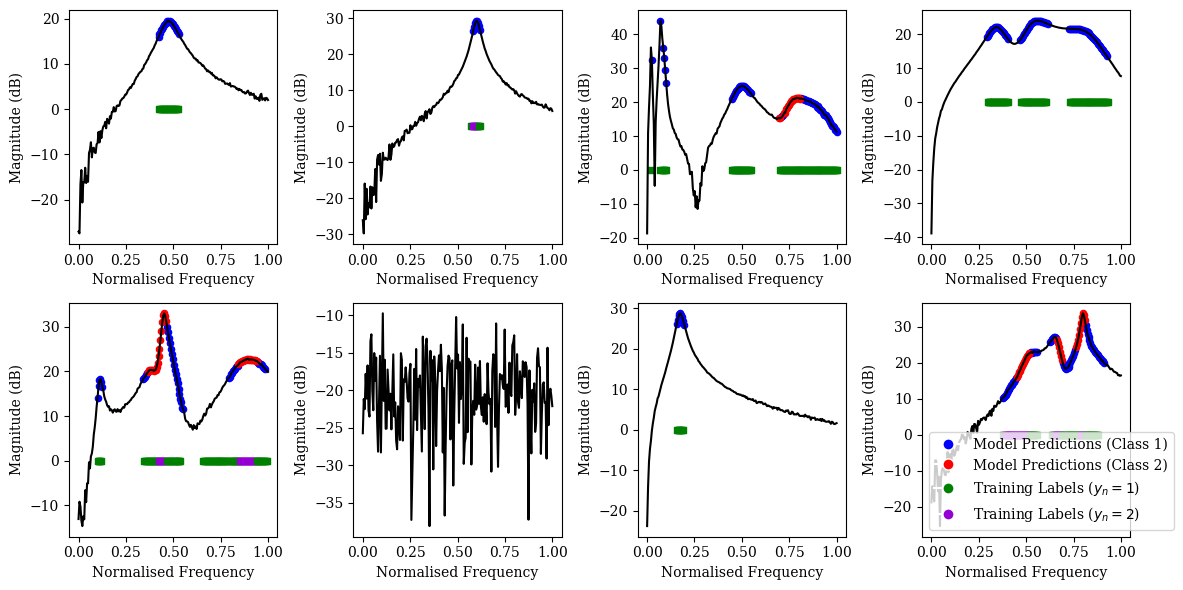

In [3]:
modal.plot_predictions_extended(multiclass, num_w_points=200, normalise=None, neg_an=True, multiclass=True, nrows=2, ncols=4, figsize=(12,6))

In [3]:
lab_tf = lab.load_data()

2024-02-01 18:17:54.623 python[58200:25365106] +[CATransaction synchronize] called within transaction


In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [8]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

In [9]:
def plot_lab_predictive_probs_multiclass(pred):
    plt.figure(figsize=(7,4))
    plt.plot(np.linspace(0,1, pred.shape[0]), softmax(pred)[:,0], label='Class 0', color='blue', alpha=0.7)
    plt.plot(np.linspace(0,1, pred.shape[0]), softmax(pred)[:,1], label='Class 1', color='red', linestyle='--')
    plt.plot(np.linspace(0,1, pred.shape[0]), softmax(pred)[:,2], label='Class 2', color='green')
    plt.xlabel('Normalised Frequency')
    plt.ylabel('Probability')
    plt.legend(loc='right')
    plt.show()

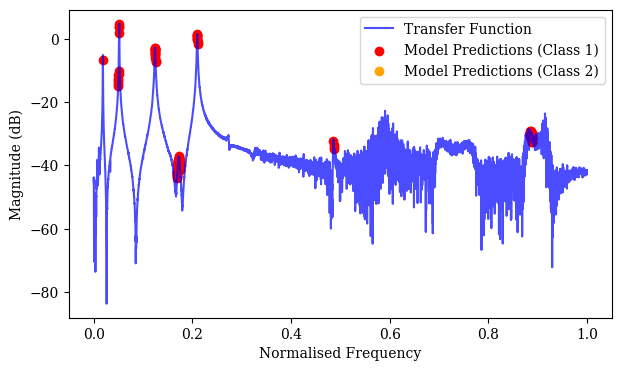

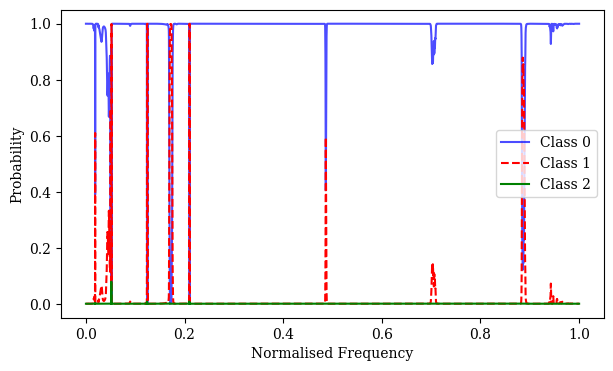

In [8]:
pred = lab.lab_predictions(multiclass, lab_tf, normalise=None, multiclass=True, extended=True)
plot_lab_predictive_probs_multiclass(pred)

In [11]:
lab_tf_noisy = lab.load_data()

2024-02-01 18:15:47.715 python[57758:25359075] +[CATransaction synchronize] called within transaction


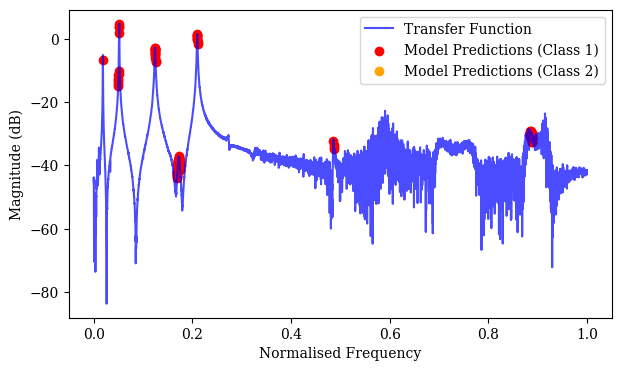

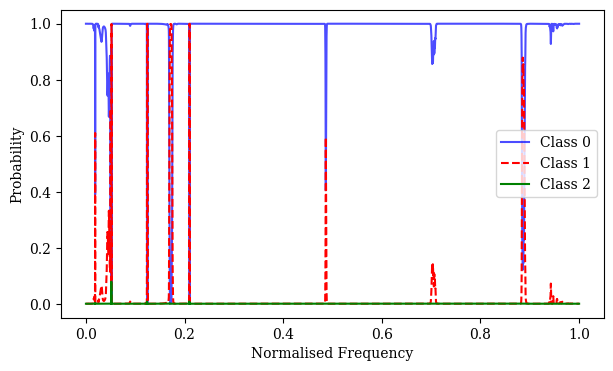

In [9]:
pred_noisy = lab.lab_predictions(multiclass, lab_tf_noisy, normalise=None, multiclass=True, extended=True)
plot_lab_predictive_probs_multiclass(pred_noisy)

In [10]:
def plot_lab_predictive_probs(pred):
    plt.figure(figsize=(7,4))
    plt.plot(np.linspace(0,1, pred.shape[0]), sigmoid(pred), color='black', linestyle='--', label = r'Raw model predictions $p(y_m=1)$')
    plt.xlabel('Normalised Frequency')
    plt.ylabel('Probability')
    plt.legend()
    plt.show()

In [11]:
def lab_predictions(model, tf_arr, multiclass=False, normalise = None, extended=False):
    """Predictions from a trained model on a given transfer function."""

    if extended:
        if normalise is not None:
            tf_arr2 = normalise(tf_arr)
            real_imag = modal.split_real_imag(tf_arr2)
            extended_tf = lab.extend_lab_tf(tf_arr)
            extended_tf[:,0] = real_imag[:,0]
            extended_tf[:,1] = real_imag[:,1]
        else:
            extended_tf = lab.extend_lab_tf(tf_arr)
        lab_tf_tensor = torch.from_numpy(extended_tf).to(torch.float32)
    else:
        lab_tf = modal.split_real_imag(tf_arr).reshape(1, -1, 2)
        if normalise is not None:
            lab_tf = normalise(lab_tf)
        lab_tf_tensor = torch.from_numpy(lab_tf).to(torch.float32)

    model.eval()
    with torch.no_grad():
        lab_tf_output = model(lab_tf_tensor)
    
    if multiclass:
        test_op = np.array(lab_tf_output.numpy())
        predictions = np.argmax(test_op, axis=-1).reshape(-1)
    else:
        test_op = lab_tf_output.numpy().reshape(-1)
        predictions = (test_op > 0.0).astype(int)
    
    input_tf = modal.split_real_imag(tf_arr)
    y = predictions

    fig, ax = plt.subplots(figsize=(7,4))
    w = np.linspace(0, 1, len(y))
    ax.plot(w, modal.to_db(input_tf), label = 'Transfer Function', c='blue', alpha=0.7)
    ax.scatter(w[y == 1], modal.to_db(input_tf)[y == 1], c='red', marker='o', label=r'Model Predictions (Class 1)')
    if multiclass:
        ax.scatter(w[y == 2], modal.to_db(input_tf)[y == 2], c='orange', marker='o', label=r'Model Predictions (Class 2)')
    ax.set_xlabel('Normalised Frequency')
    ax.set_ylabel('Magnitude (dB)')
    ax.legend()
    plt.show()

    return test_op

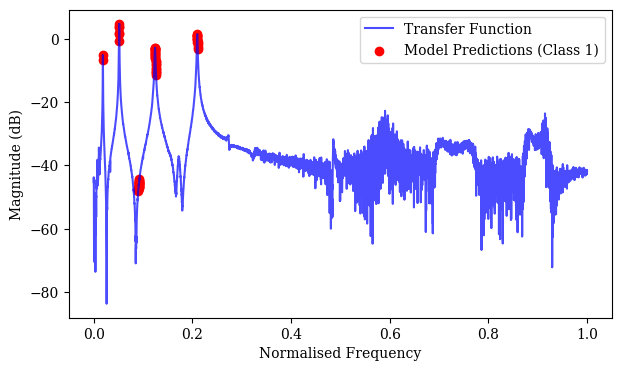

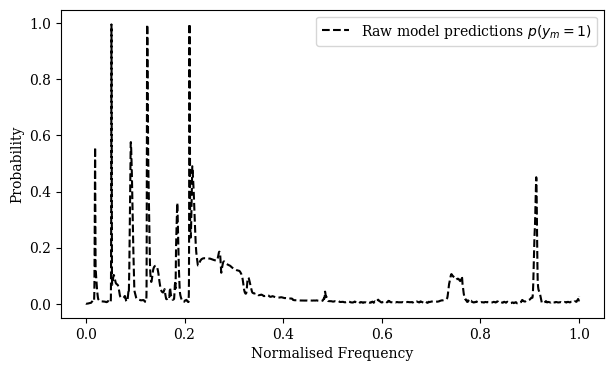

In [18]:
pred_single = lab_predictions(singeclass, lab_tf, normalise=None, multiclass=False, extended=True)
plot_lab_predictive_probs(pred_single)

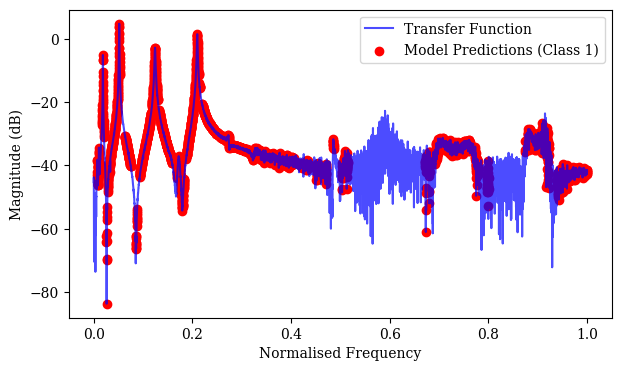

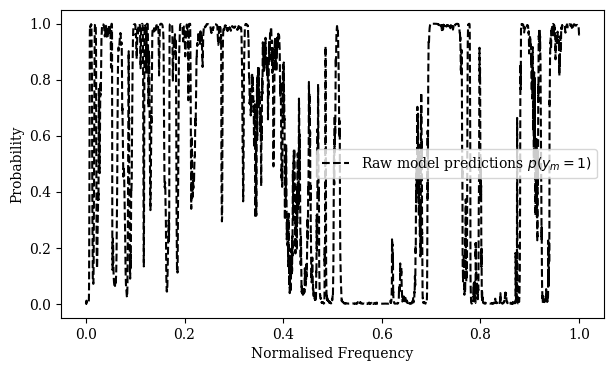

In [23]:
pred_single_norm = lab_predictions(singeclass_norm, lab_tf, normalise=modal.normalise_rms, multiclass=False, extended=True)
plot_lab_predictive_probs(pred_single_norm)

## 06/02

In [5]:
beam_data = scipy.io.loadmat('./Lab Data/Beam/G_set.mat')

In [40]:
print(beam_data.keys())
print(beam_data['yspec'][:, -1].shape)

dict_keys(['__header__', '__version__', '__globals__', 'yspec', 'tfun', 'npts', 'freq', 'dt2'])
(262145,)


In [42]:
print(beam_data['freq'])

[[100000]]


/Users/vaibhav/miniconda3/envs/y4p/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


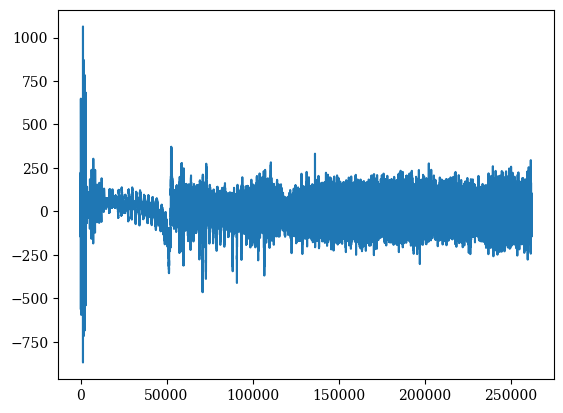

In [7]:
beam_tf = beam_data['yspec'][:, -1] # shape = (262145,)
plt.plot(beam_tf)

In [35]:
print(beam_tf)

[ 12.0295193 -10.49666415j  12.0295193 -10.49666415j
  11.60064039 -6.75721023j ... -45.99147938-15.31917534j
 -39.08921646 -9.14194559j   0.26640915 +0.j        ]


In [2]:
from matplotlib.widgets import Slider

In [3]:
%matplotlib inline

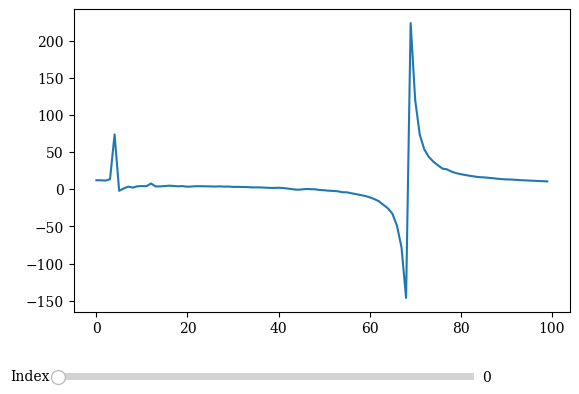

In [8]:
fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.25)

# Plot initial data
line, = plt.plot(beam_tf[:1000])  # Plot only a portion of the data initially

# Define slider properties
ax_slider = plt.axes([0.1, 0.1, 0.65, 0.03], facecolor='lightgoldenrodyellow')
slider = Slider(ax_slider, 'Index', 0, len(beam_tf) - 100, valinit=0, valstep=1)

# Function to update plot based on slider value
def update(val):
    index = int(slider.val)
    line.set_ydata(beam_tf[index:index + 100])
    ax.set_xlim(index, index + 100)
    fig.canvas.draw_idle()

# Register the update function with the slider
slider.on_changed(update)

plt.show(block=False)

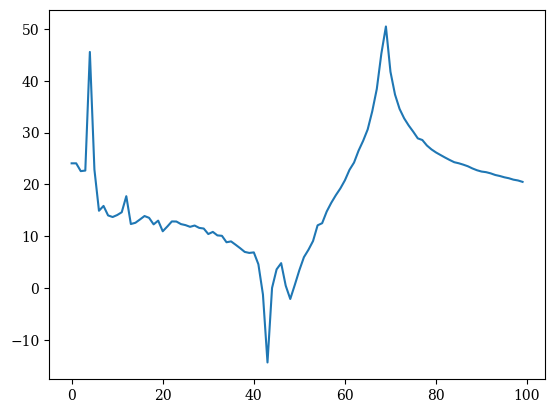

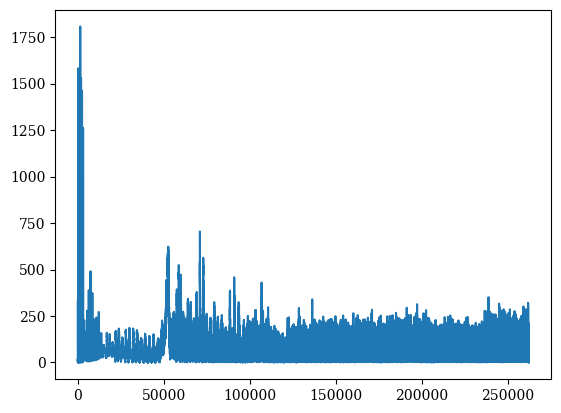

In [56]:
plt.plot(modal.to_db(beam_tf)[:100])
plt.show()
plt.plot(np.linalg.norm(modal.split_real_imag(beam_tf), axis=1))
plt.show()

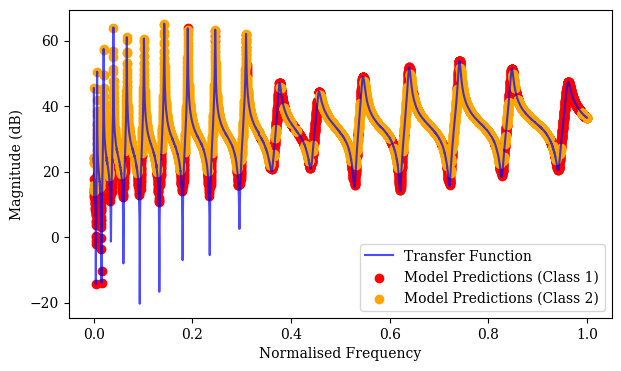

In [43]:
beam_predictions = lab_predictions(multiclass, beam_tf[:10000], normalise=None, multiclass=True, extended=True)


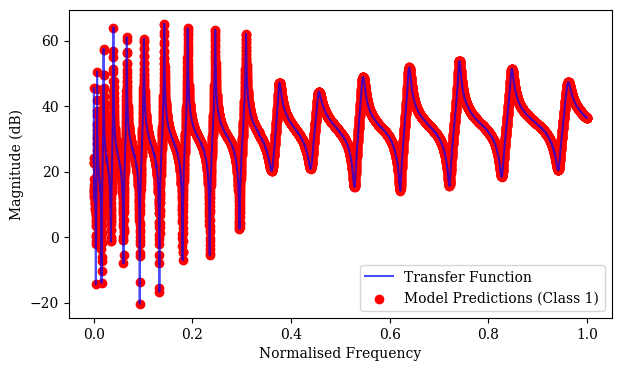

In [33]:
beam_predictions = lab_predictions(singeclass_norm, beam_tf[:10000], normalise=None, multiclass=False, extended=True)


In [53]:
print(beam_tf.shape)

(262145,)


In [69]:
faxis = np.fft.rfftfreq(2 * beam_tf.shape[0] - 1, d=1/100000)
print(faxis)
print(faxis.shape)


[0.00000000e+00 1.90734499e-01 3.81468999e-01 ... 4.99995232e+04
 4.99997139e+04 4.99999046e+04]
(262145,)


[         1      10000      20000 ... 2621420000 2621430000 2621440000]


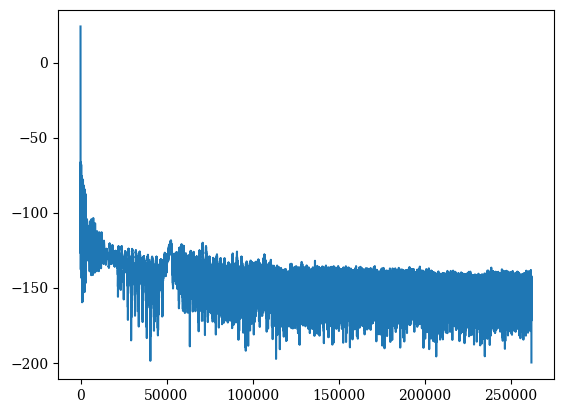

In [63]:
# freqs = np.arange(0, beam_tf.shape[0]*10000, 10000)
# freqs[0]= 1
# print(freqs)
beam_tf_vel = beam_tf / (1j * freqs)
plt.plot(modal.to_db(beam_tf_vel))

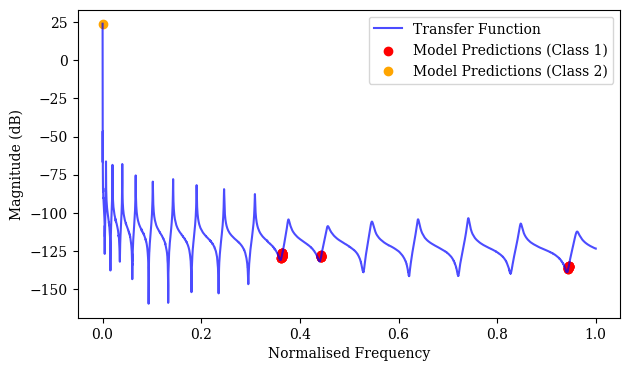

In [65]:
beam_predictions = lab_predictions(multiclass, beam_tf_vel[:10000], normalise=None, multiclass=True, extended=True)


## 07/02

### Training new model, normalise real part, imaginary part and magnitude data by 95% of peak magnitude

In [2]:
def generate_dat_extended(num_data, num_w_points, sigma_max = 0.15, max_modes = 7,
                multiclass = False, normalise = None, neg_an=False, logmag=False, scaled_logmag=False, a_max=2.0):
    """Generate num_data training examples with num_w_points frequency points.
    Pass normalisation function as a parameter. Include phase and magnintude 
    information in the output.
    X: (num_data, num_w_points, 4)
    Y: (num_data, num_w_points)
    ws: (num_data, max_modes)
    zs: (num_data, max_modes)"""
    X = []
    Y = []
    ws = []
    zs = []
    w = np.linspace(0, 1, num_w_points)
    for i in range(num_data):
        num_modes = np.random.randint(0, max_modes + 1)
        w_n = np.random.uniform(0, 1, num_modes)
        if neg_an:
            mag = np.random.uniform(-a_max, a_max, num_modes)
            phase = np.random.normal(0, np.pi / 8, num_modes)
            a_n = mag * np.exp(1j * phase)  # combine mag and phase to make a complex num
        else:
            a_n = np.random.uniform(1, 2, num_modes)
        # z_n = np.random.uniform(0.01, 0.20, num_modes)
        z_n = 10 ** (np.random.uniform(-3, -0.7, num_modes)) # log-uniform sampling of z_n
        sigma = np.random.uniform(0.001, sigma_max)
        out, y = modal.modal_sum(w, a_n, z_n, w_n, sigma, multiclass)

        if normalise is not None:
            out = normalise(out)

        real_imag = modal.split_real_imag(out)
        phase = np.arctan(np.imag(out)/np.real(out))
        # phase = np.mod(phase, 2*np.pi)
        mag = np.abs(out)
        max_mag = np.max(mag)
        mag = mag / (0.95 * max_mag)
        real_imag = real_imag / (0.95 * max_mag)

        if logmag is True:
            logmagnitude = np.log10(mag)
            if scaled_logmag is True:
                logmagnitude = (logmagnitude - np.mean(logmagnitude)) / np.std(logmagnitude)
            extended_op = np.concatenate((real_imag, phase.reshape(-1,1), mag.reshape(-1,1), logmagnitude.reshape(-1,1)), axis=1)
        else:
            extended_op = np.concatenate((real_imag, phase.reshape(-1,1), mag.reshape(-1,1)), axis=1)
        ws.append(w_n)
        zs.append(z_n)
        X.append(extended_op)
        Y.append(y)
    return np.array(X), np.array(Y), ws, zs

In [109]:
X, Y, ws, zs = generate_dat_extended(32*500, 200, multiclass=True, normalise=None, neg_an=True)
Xval, Yval, wsval, zsval = generate_dat_extended(32*125, 200, multiclass=True, normalise=None, neg_an=True)

In [133]:
print(Y.shape)
# count the number of each class in Y
unique, counts = np.unique(Y, return_counts=True)
print(unique, counts)


(16000, 200)
[0. 1. 2.] [2324497  673428  202075]
3200000
3200000


In [144]:
print(np.sum(counts)/counts)

[ 1.37664191  4.75180717 15.83570457]


In [11]:
from sklearn.utils.class_weight import compute_class_weight

In [140]:
weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y), y=Y.reshape(-1))
print(weights)

[0.45888064 1.58393572 5.27856819]


#### Visualising the new data

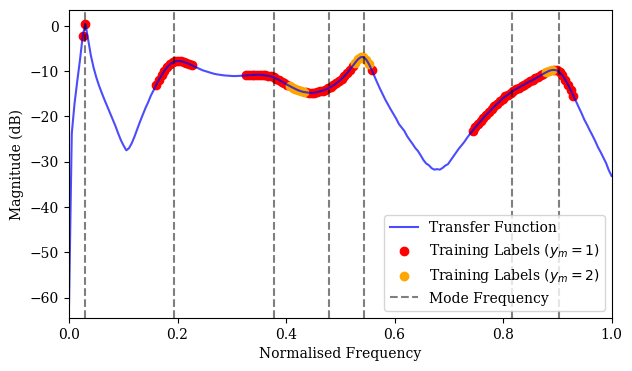

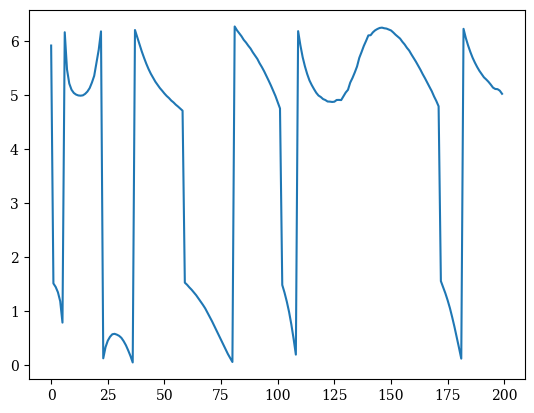

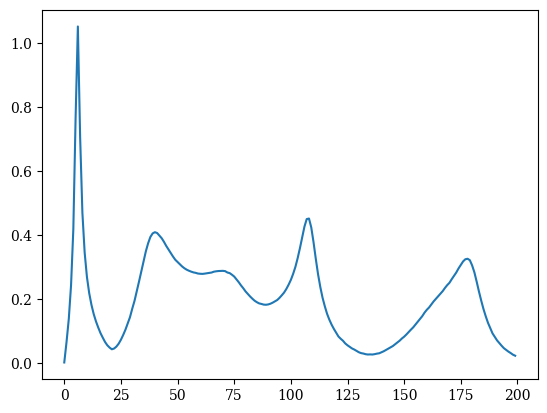

In [104]:
idx = np.random.randint(0, 1000)
# plt.plot(modal.to_db(X[idx, :, :2]))
# plt.show()
modal.plot_tf(X[idx, :, :2], y=Y[idx], ws=ws[idx])
plt.plot(X[idx, :, 2])
plt.show()
plt.plot(X[idx, :, 3])
plt.show()

In [13]:
def train_model_multiclass(model, X, y, valX, valy, name, num_epochs=150,batch_size=32,weights=None, device='cpu'):
    device = torch.device(device)
    model.to(device)
    X = torch.from_numpy(X).to(torch.float32)
    y = torch.from_numpy(y).to(torch.long)
    val_X = torch.from_numpy(valX).to(torch.float32)
    val_y = torch.from_numpy(valy).to(torch.long)

    dataset = TensorDataset(X, y)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)

    val_dataset = TensorDataset(val_X, val_y)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,pin_memory=True, num_workers=4)

    # Define a binary cross-entropy loss function and an optimizer
    # pos_weight > 1 aims to increase recall
    # criterion = nn.CrossEntropyLoss(weight = torch.tensor([1.0, 4.0, 20.0]))  
    # criterion = nn.CrossEntropyLoss(weight = torch.tensor([1.0, 4.0, 15.0])) 
    # criterion = nn.CrossEntropyLoss(weight = torch.tensor([1.0, 4.0, 8.0])) 
    if weights is not None:
        criterion = nn.CrossEntropyLoss(weight = weights.detach().clone())
    else:
        # criterion = nn.CrossEntropyLoss(weight = torch.tensor([1.0, 3.0, 6.5])) 
        criterion = nn.CrossEntropyLoss(weight = torch.tensor([1.0, 3.0, 6.0])) 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    result_dict = {
        'training_loss': [],
        'validation_loss': [],
        'training_precision': [],
        'training_recall': [],
        'validation_precision': [],
        'validation_recall': [],
        'epochs': []
    }

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        total_loss = 0.0
        total_precision = 0.0
        total_recall = 0.0
        total_samples = 0

        total_val_loss = 0.0
        total_val_precision = 0.0
        total_val_recall = 0.0
        total_val_samples = 0

        best_val_loss = float('inf')  # Initialize best validation loss
        no_improvement_count = 0  # Initialize counter for no improvement
        early_stopping_patience = 4  # Number of epochs to wait before early stopping

        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            targets = targets.view(-1)
            targets = targets.to(device)
            loss = criterion(outputs.view(-1, 3), targets)

            loss.backward()
            optimizer.step()

            batch_precision, batch_recall = modal.calculate_precision_and_recall(outputs, targets)
            total_loss += loss.item() * len(inputs)
            total_precision += batch_precision * len(inputs)
            total_recall += batch_recall * len(inputs)
            total_samples += len(inputs)

        model.eval() # !!!
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                targets = targets.view(-1)
                loss = criterion(outputs.view(-1, 3), targets)
                total_val_loss += loss.item() * len(inputs)
                batch_precision, batch_recall = modal.calculate_precision_and_recall(outputs, targets)
                total_val_precision += batch_precision * len(inputs)
                total_val_recall += batch_recall * len(inputs)
                total_val_samples += len(inputs) 

        average_loss = total_loss / total_samples
        average_precision = total_precision / total_samples
        average_recall = total_recall / total_samples
        # average_accuracy = total_accuracy / total_samples
        average_val_loss = total_val_loss / total_val_samples
        average_val_precision = total_val_precision / total_val_samples
        average_val_recall = total_val_recall / total_val_samples

        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}, Accuracy: {average_accuracy}')
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}, Precision: {average_precision}, Recall: {average_recall}')
        print(f'Val Loss: {average_val_loss}, Validation Precision: {average_val_precision}, Validation Recall: {average_val_recall}')

        result_dict['training_loss'].append(average_loss)
        result_dict['validation_loss'].append(average_val_loss)
        result_dict['training_precision'].append(average_precision)
        result_dict['training_recall'].append(average_recall)
        result_dict['validation_precision'].append(average_val_precision)
        result_dict['validation_recall'].append(average_val_recall)
        result_dict['epochs'].append(epoch+1)

        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1
            if no_improvement_count >= early_stopping_patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                torch.save(model, f'{name}.pth')
                return result_dict

    torch.save(model, f'{name}.pth')
    return result_dict

In [50]:
def plot_predictions_extended(model, num_w_points=200, normalise=None, neg_an=True, multiclass=False, nrows=4, ncols=4,s=20, logmag=False, scaled_logmag=False, sigma_max=0.1, max_modes=6, a_max=2):
    """Plot 4x4 grid of predictions on a validation set of data.
    val_inputs: (num_data, num_w_points, 2)
    val_outputs: (num_data, num_w_points)
    val_targets: (num_data, num_w_points)"""

    valX, valy, _, __ = generate_dat_extended(32*1, num_w_points, multiclass=multiclass, normalise=normalise, neg_an=neg_an, logmag=logmag, scaled_logmag=scaled_logmag, sigma_max=sigma_max, max_modes=max_modes, a_max=a_max) 
    # generating data using max norm 
    val_X = torch.from_numpy(valX).to(torch.float32)
    if multiclass:
        val_y = torch.from_numpy(valy).to(torch.long)
    else:
        val_y = torch.from_numpy(valy).to(torch.float32)

    if normalise is not None:
        val_X = normalise(val_X)
    dataset = TensorDataset(val_X, val_y)
    val_loader = DataLoader(dataset, batch_size=32, shuffle=False)

    model.eval()
    for val_inputs, val_targets in val_loader:
        with torch.no_grad():
            val_outputs = model(val_inputs)
    
    print(val_inputs.shape)
    print(val_outputs.shape)

    fig, axs = plt.subplots(nrows =nrows, ncols = ncols, figsize=(12,12))

    w = np.linspace(0, 1, len(val_targets[0]))
    for index, ax in enumerate(axs.flat):

        targets = np.array(val_targets[index].numpy())
        test_op = np.array(val_outputs[index].numpy())

        tf = val_inputs[index].numpy()[:,:2]

        if multiclass:
            predicted = np.argmax(test_op, axis=-1)
            ax.plot(w, modal.to_db(tf), c='black')

            for i in range(len(w)):
                if predicted[i] == 1:
                    ax.scatter(w[i], modal.to_db(tf)[i], c='red', marker='o', label = 'Model Predictions', s=s)
                if predicted[i] == 2:
                    ax.scatter(w[i], modal.to_db(tf)[i], c='orange', marker='o', s=s)
                if targets[i] == 1:
                    ax.scatter(w[i], 0, c='green', marker='o', label=r'Training Labels ($y_n = 1$)', s=s)
                if targets[i] == 2:
                    ax.scatter(w[i], 0, c='blue', marker='o',s=s)

            ax.set_xlabel('Normalised Frequency')
            ax.set_ylabel('Magnitude (dB)')
            # ax.legend()
        else:
            predicted = (test_op > 0.0).astype(int)
            ax.plot(w, modal.to_db(tf), c='black')

            for i in range(len(w)):
                if i==0:
                    if predicted[i] == 1:
                        ax.scatter(w[i], modal.to_db(tf)[i], c='blue', marker='o', label = 'Model Predictions')
                    if targets[i] == 1:
                        ax.scatter(w[i], 0, c='green', marker='o', label=r'Training Labels ($y_n = 1$)')
                else:
                    if predicted[i] == 1:
                        ax.scatter(w[i], modal.to_db(tf)[i], c='blue', marker='o')
                        # ax.legend()
                    if targets[i] == 1:
                        ax.scatter(w[i], 0, c='green', marker='o')
                
            ax.set_xlabel('Normalised Frequency')
            ax.set_ylabel('Magnitude (dB)')
            
    # plt.legend()
    plt.tight_layout()

In [114]:
multiclass_model = BiLSTM(input_size=4, hidden_size=100, num_layers=3, num_classes=3)
multiclass_res = train_model_multiclass(multiclass_model, X, Y, Xval, Yval, name='norm_95_max(07.02)', num_epochs=50, batch_size=128)

  2%|▏         | 1/50 [02:11<1:47:27, 131.58s/it]

Epoch [1/50], Loss: 0.8857048797607422, Precision: 0.8577865634468944, Recall: 0.914422018956291
Validation Precision: 0.8278419769131822, Validation Recall: 0.963941853601561


  4%|▍         | 2/50 [04:22<1:45:00, 131.27s/it]

Epoch [2/50], Loss: 0.7818347973823547, Precision: 0.8735377564858837, Recall: 0.9441593584984752
Validation Precision: 0.9058737192124552, Validation Recall: 0.9569206165141729


  6%|▌         | 3/50 [06:31<1:42:00, 130.23s/it]

Epoch [3/50], Loss: 0.7495594754219055, Precision: 0.8972808908471843, Recall: 0.9481302855340854
Validation Precision: 0.9167788404382385, Validation Recall: 0.9624224619521239


  8%|▊         | 4/50 [08:40<1:39:26, 129.71s/it]

Epoch [4/50], Loss: 0.7099326910972595, Precision: 0.9142876846225367, Recall: 0.9519546598215586
Validation Precision: 0.9210348834802305, Validation Recall: 0.9655132004143163


 10%|█         | 5/50 [10:48<1:36:53, 129.19s/it]

Epoch [5/50], Loss: 0.6893951258659363, Precision: 0.9217072303717478, Recall: 0.9545005024806638
Validation Precision: 0.9493488537103266, Validation Recall: 0.9606553401526076


 12%|█▏        | 6/50 [12:56<1:34:20, 128.66s/it]

Epoch [6/50], Loss: 0.6760082955360412, Precision: 0.9271050284743239, Recall: 0.9555428796735349
Validation Precision: 0.940431088407085, Validation Recall: 0.9671764810165426


 14%|█▍        | 7/50 [15:08<1:32:54, 129.64s/it]

Epoch [7/50], Loss: 0.6656607098579407, Precision: 0.930892284225564, Recall: 0.9564318256719021
Validation Precision: 0.9164932232169286, Validation Recall: 0.974471789023486


 16%|█▌        | 8/50 [17:19<1:31:07, 130.19s/it]

Epoch [8/50], Loss: 0.6542832612991333, Precision: 0.9345063223018034, Recall: 0.9578356433367973
Validation Precision: 0.9398767804461943, Validation Recall: 0.9718668641653028


 18%|█▊        | 9/50 [19:28<1:28:39, 129.74s/it]

Epoch [9/50], Loss: 0.6443375535011292, Precision: 0.9374975051876413, Recall: 0.9585806812791602
Validation Precision: 0.9445399944166776, Validation Recall: 0.9719061379662395


 20%|██        | 10/50 [21:37<1:26:28, 129.70s/it]

Epoch [10/50], Loss: 0.6359798235893249, Precision: 0.9405712130790896, Recall: 0.9587978316308005
Validation Precision: 0.9476983033668936, Validation Recall: 0.9718154337723411


 22%|██▏       | 11/50 [23:46<1:24:04, 129.35s/it]

Epoch [11/50], Loss: 0.6295517220497131, Precision: 0.9414019774865949, Recall: 0.9595316948967673
Validation Precision: 0.9494433158583625, Validation Recall: 0.9717036997179549


 24%|██▍       | 12/50 [25:55<1:21:46, 129.13s/it]

Epoch [12/50], Loss: 0.6214034271240234, Precision: 0.9435627635310874, Recall: 0.9604557443959971
Validation Precision: 0.9359636339446665, Validation Recall: 0.9759115858298885


 26%|██▌       | 13/50 [28:04<1:19:44, 129.30s/it]

Epoch [13/50], Loss: 0.6157288017272949, Precision: 0.9442835223813133, Recall: 0.9607024463284686
Validation Precision: 0.9439674487167873, Validation Recall: 0.9756957070218739


 28%|██▊       | 14/50 [30:13<1:17:31, 129.22s/it]

Epoch [14/50], Loss: 0.6074555020332336, Precision: 0.9464898600155041, Recall: 0.9614758488129376
Validation Precision: 0.9519293226657347, Validation Recall: 0.9750476944266577


 30%|███       | 15/50 [32:25<1:15:52, 130.07s/it]

Epoch [15/50], Loss: 0.5999634585380554, Precision: 0.9481546265077979, Recall: 0.9618836465956838
Validation Precision: 0.9444643966609586, Validation Recall: 0.979154198544949


 32%|███▏      | 16/50 [34:38<1:14:13, 130.98s/it]

Epoch [16/50], Loss: 0.5928677659034729, Precision: 0.9499844117228874, Recall: 0.962561590231454
Validation Precision: 0.9539914821631775, Validation Recall: 0.9761886472539167


 34%|███▍      | 17/50 [36:48<1:11:51, 130.64s/it]

Epoch [17/50], Loss: 0.5894862723350525, Precision: 0.9505650713854682, Recall: 0.96228658249667
Validation Precision: 0.9451783355560166, Validation Recall: 0.9795816867744097


 36%|███▌      | 18/50 [38:57<1:09:26, 130.19s/it]

Epoch [18/50], Loss: 0.5827661824226379, Precision: 0.951514485064891, Recall: 0.9632942673942568
Validation Precision: 0.9646067806415429, Validation Recall: 0.9751857090133842


 38%|███▊      | 19/50 [41:14<1:08:15, 132.10s/it]

Epoch [19/50], Loss: 0.5771679029464721, Precision: 0.9530842782141161, Recall: 0.9634771879666674
Validation Precision: 0.957459641633122, Validation Recall: 0.9766265262542702


 40%|████      | 20/50 [43:29<1:06:28, 132.95s/it]

Epoch [20/50], Loss: 0.5695294709205627, Precision: 0.9538846077380586, Recall: 0.9640448833119569
Validation Precision: 0.9560020864841038, Validation Recall: 0.9786108571228878


 42%|████▏     | 21/50 [45:46<1:04:50, 134.16s/it]

Epoch [21/50], Loss: 0.5663937692642211, Precision: 0.9544917805826116, Recall: 0.9640459015867427
Validation Precision: 0.9580858938258547, Validation Recall: 0.9782049235913036


 44%|████▍     | 22/50 [48:03<1:03:04, 135.18s/it]

Epoch [22/50], Loss: 0.564173391342163, Precision: 0.9549171291281164, Recall: 0.9640136743575504
Validation Precision: 0.9685030413140788, Validation Recall: 0.9755484593356094


 46%|████▌     | 23/50 [50:17<1:00:36, 134.69s/it]

Epoch [23/50], Loss: 0.5585667300224304, Precision: 0.9556361540774574, Recall: 0.9645486494102687
Validation Precision: 0.9614356892140172, Validation Recall: 0.9781972666496386


 48%|████▊     | 24/50 [52:28<57:54, 133.62s/it]  

Epoch [24/50], Loss: 0.5525574944019318, Precision: 0.956768187423455, Recall: 0.964880658940902
Validation Precision: 0.9602996903319393, Validation Recall: 0.9784408530327571


 50%|█████     | 25/50 [54:38<55:15, 132.62s/it]

Epoch [25/50], Loss: 0.5546986341476441, Precision: 0.9566301806899568, Recall: 0.9644427783328883
Validation Precision: 0.9606583475113958, Validation Recall: 0.9785554374848856


 52%|█████▏    | 26/50 [56:50<52:54, 132.25s/it]

Epoch [26/50], Loss: 0.5462746443748474, Precision: 0.9582539775729049, Recall: 0.9652487117597406
Validation Precision: 0.957593884347277, Validation Recall: 0.9796487878202846


 54%|█████▍    | 27/50 [59:03<50:46, 132.44s/it]

Epoch [27/50], Loss: 0.5432501759529114, Precision: 0.9592050829874759, Recall: 0.9651819882192929
Validation Precision: 0.9608727356607545, Validation Recall: 0.9802312483270189


 56%|█████▌    | 28/50 [1:01:13<48:21, 131.90s/it]

Epoch [28/50], Loss: 0.5378561336994171, Precision: 0.9597305767372705, Recall: 0.965723804698105
Validation Precision: 0.9678841137561512, Validation Recall: 0.9771511342337047


 58%|█████▊    | 29/50 [1:03:24<46:05, 131.67s/it]

Epoch [29/50], Loss: 0.5332226655483245, Precision: 0.9602132203925325, Recall: 0.9660086623621135
Validation Precision: 0.9690993992469267, Validation Recall: 0.9776818122866011


 60%|██████    | 30/50 [1:05:39<44:11, 132.57s/it]

Epoch [30/50], Loss: 0.5305490491390228, Precision: 0.9600680636078748, Recall: 0.966039115451331
Validation Precision: 0.9561303837199826, Validation Recall: 0.9814446558553115


 62%|██████▏   | 31/50 [1:07:54<42:15, 133.43s/it]

Epoch [31/50], Loss: 0.5262432236671448, Precision: 0.9606033249269268, Recall: 0.9661185433441576
Validation Precision: 0.963251817976838, Validation Recall: 0.9807904435673701


 64%|██████▍   | 32/50 [1:10:06<39:51, 132.83s/it]

Epoch [32/50], Loss: 0.5209453458786011, Precision: 0.9616456723039413, Recall: 0.96630409095596
Validation Precision: 0.95963104292629, Validation Recall: 0.9808239503638004


 66%|██████▌   | 33/50 [1:12:15<37:21, 131.84s/it]

Epoch [33/50], Loss: 0.5198536200523376, Precision: 0.9615777318491803, Recall: 0.9661491739757383
Validation Precision: 0.9689603414667569, Validation Recall: 0.978389776872706


 68%|██████▊   | 34/50 [1:14:25<34:59, 131.23s/it]

Epoch [34/50], Loss: 0.5187310473918915, Precision: 0.961419752411261, Recall: 0.9662419049629762
Validation Precision: 0.9603311128245854, Validation Recall: 0.9810238689641353


 70%|███████   | 35/50 [1:16:35<32:40, 130.70s/it]

Epoch [35/50], Loss: 0.5156597464084626, Precision: 0.9618311278359293, Recall: 0.9663500667144782
Validation Precision: 0.9622170648709135, Validation Recall: 0.9818933247668634


 72%|███████▏  | 36/50 [1:18:46<30:31, 130.85s/it]

Epoch [36/50], Loss: 0.5082882714271545, Precision: 0.9633601025725462, Recall: 0.9670003701902281
Validation Precision: 0.9597480851254123, Validation Recall: 0.9824552065244716


 74%|███████▍  | 37/50 [1:21:00<28:34, 131.90s/it]

Epoch [37/50], Loss: 0.5048938615322113, Precision: 0.9636068431297361, Recall: 0.9671536041279726
Validation Precision: 0.9581395125702955, Validation Recall: 0.9823543562907509


 76%|███████▌  | 38/50 [1:23:11<26:18, 131.57s/it]

Epoch [38/50], Loss: 0.5044677197933197, Precision: 0.963735953047478, Recall: 0.9670548374217005
Validation Precision: 0.9703422095981313, Validation Recall: 0.9758668697687469


 78%|███████▊  | 39/50 [1:25:24<24:13, 132.11s/it]

Epoch [39/50], Loss: 0.5091923432350158, Precision: 0.962741259522454, Recall: 0.9667286234599681
Validation Precision: 0.9675969904390297, Validation Recall: 0.9805476847724479


 80%|████████  | 40/50 [1:27:38<22:06, 132.60s/it]

Epoch [40/50], Loss: 0.4963337070941925, Precision: 0.9644315463700781, Recall: 0.9674118253737684
Validation Precision: 0.9664400369521436, Validation Recall: 0.9807134861116493


 82%|████████▏ | 41/50 [1:29:53<20:00, 133.35s/it]

Epoch [41/50], Loss: 0.4960421814918518, Precision: 0.9644597564519217, Recall: 0.9672855254492198
Validation Precision: 0.9661499096137108, Validation Recall: 0.9812271868581304


 84%|████████▍ | 42/50 [1:32:03<17:38, 132.27s/it]

Epoch [42/50], Loss: 0.49071683144569395, Precision: 0.964583654020468, Recall: 0.9674747976640043
Validation Precision: 0.9612627325369666, Validation Recall: 0.9818061335643786


 86%|████████▌ | 43/50 [1:56:25<1:01:58, 531.25s/it]

Epoch [43/50], Loss: 0.489028653383255, Precision: 0.9641935781636388, Recall: 0.9677513267158482
Validation Precision: 0.9723915128080604, Validation Recall: 0.9789133823329894


 88%|████████▊ | 44/50 [2:17:18<1:14:45, 747.59s/it]

Epoch [44/50], Loss: 0.48770248889923096, Precision: 0.9642659129474968, Recall: 0.9673911941734485
Validation Precision: 0.9654982954508367, Validation Recall: 0.981129857221052


 90%|█████████ | 45/50 [2:28:21<1:00:12, 722.44s/it]

Epoch [45/50], Loss: 0.4842229616641998, Precision: 0.9648943379947165, Recall: 0.9675525443301176
Validation Precision: 0.9654417758027074, Validation Recall: 0.9818079477682263


 92%|█████████▏| 46/50 [2:30:35<36:23, 545.94s/it]  

Epoch [46/50], Loss: 0.4778570649623871, Precision: 0.9654706740108903, Recall: 0.9679341834107754
Validation Precision: 0.9677153520720154, Validation Recall: 0.9803873000451239


 94%|█████████▍| 47/50 [2:32:51<21:08, 422.81s/it]

Epoch [47/50], Loss: 0.47478873300552366, Precision: 0.9653904844364651, Recall: 0.9680022805038401
Validation Precision: 0.9666910173487981, Validation Recall: 0.9818297898202722


 96%|█████████▌| 48/50 [2:35:10<11:15, 337.64s/it]

Epoch [48/50], Loss: 0.47234293031692504, Precision: 0.965871428679012, Recall: 0.9678923300430256
Validation Precision: 0.9613098183762352, Validation Recall: 0.98355545092443


 98%|█████████▊| 49/50 [2:37:29<04:38, 278.11s/it]

Epoch [49/50], Loss: 0.4979936921596527, Precision: 0.9623216970522573, Recall: 0.966981973049664
Validation Precision: 0.9504072756939186, Validation Recall: 0.9845158771857552


100%|██████████| 50/50 [2:39:50<00:00, 191.81s/it]

Epoch [50/50], Loss: 0.47613416504859923, Precision: 0.9652036862921192, Recall: 0.9678980540543729
Validation Precision: 0.9613543644992482, Validation Recall: 0.9826598755095558


In [123]:
print(multiclass_res.keys())

dict_keys(['training_loss', 'validation_loss', 'training_precision', 'training_recall', 'validation_precision', 'validation_recall', 'epochs'])


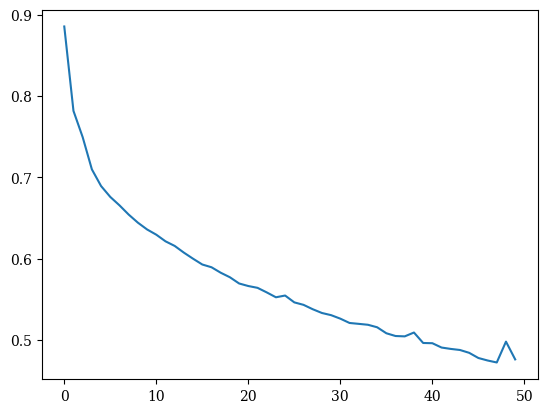

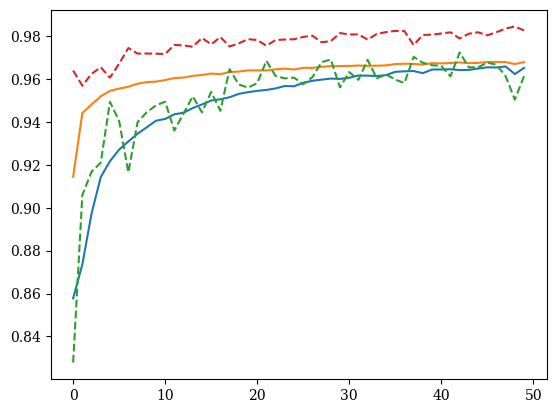

In [124]:
plt.plot(multiclass_res['training_loss'], label='Training Loss')
plt.show()
plt.plot(multiclass_res['training_precision'], label='Tr Precision')
plt.plot(multiclass_res['training_recall'], label='Tr Recall')
plt.plot(multiclass_res['validation_precision'], label='Val Precision', linestyle='--')
plt.plot(multiclass_res['validation_recall'], label='Val Recall', linestyle='--')
plt.show()

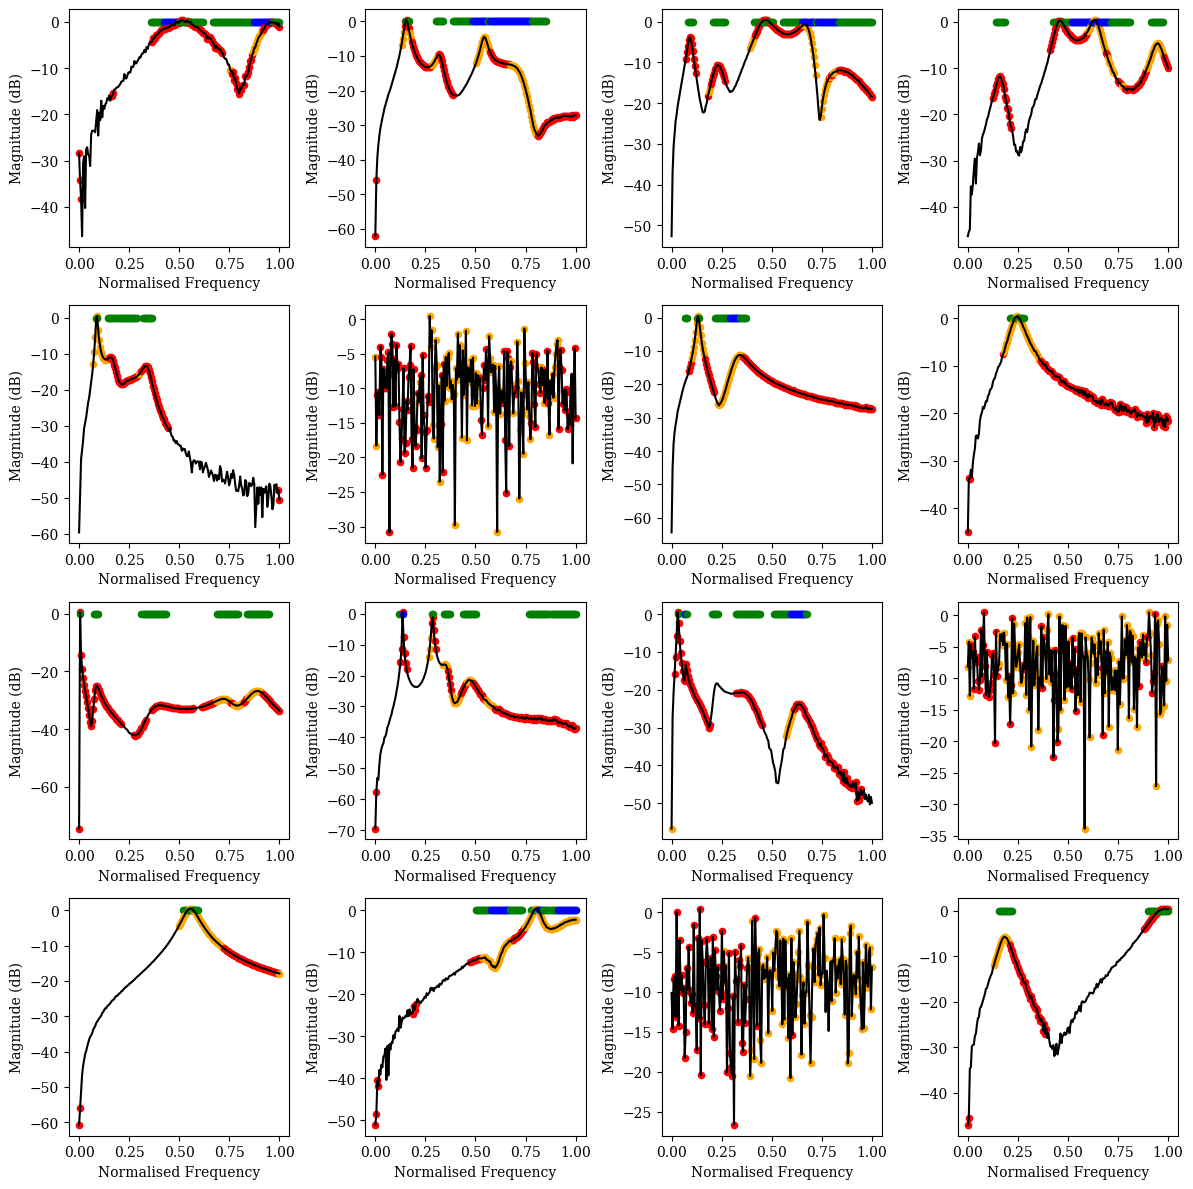

In [191]:
plot_predictions_extended(multiclass_model, num_w_points=200, normalise=None, neg_an=True, multiclass=True, nrows=4, ncols=4)

### Retrying this model with different class weights and more powerful model and more data
#### Also phase now between -pi pi instead of 0 2pi

In [149]:
X, Y, ws, zs = generate_dat_extended(32*1000, 200, multiclass=True, normalise=None, neg_an=True)
Xval, Yval, wsval, zsval = generate_dat_extended(32*250, 200, multiclass=True, normalise=None, neg_an=True)

In [158]:
weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y), y=Y.reshape(-1))
weights=torch.tensor(weights, dtype=torch.float32)
print(weights)

tensor([0.4576, 1.5853, 5.4438])


In [163]:
maxnorm_model_2 = BiLSTM(input_size=4, hidden_size=100, num_layers=3, num_classes=3)
maxnorm_res_2 = train_model_multiclass(maxnorm_model_2, X, Y, Xval, Yval, name='norm_95_max(08.02)', num_epochs=100, batch_size=128,  weights=weights)

  1%|          | 1/100 [04:14<6:59:32, 254.26s/it]

Epoch [1/100], Loss: 0.9471117069721222, Precision: 0.8716091312265924, Recall: 0.9119326421116897
Validation Precision: 0.8844356094265219, Validation Recall: 0.9439155153279558


  2%|▏         | 2/100 [08:26<6:53:33, 253.20s/it]

Epoch [2/100], Loss: 0.8043354151248931, Precision: 0.901532101800901, Recall: 0.9486355506975266
Validation Precision: 0.8801011186964919, Validation Recall: 0.9699214154646955


  3%|▎         | 3/100 [12:40<6:50:03, 253.65s/it]

Epoch [3/100], Loss: 0.7744409122467041, Precision: 0.9093485084939406, Recall: 0.9527156930803147
Validation Precision: 0.9122376414992086, Validation Recall: 0.9709931385956647


  4%|▍         | 4/100 [16:50<6:43:28, 252.17s/it]

Epoch [4/100], Loss: 0.7245640716552735, Precision: 0.9318165367444132, Recall: 0.9572800411564423
Validation Precision: 0.9484073196487599, Validation Recall: 0.9671643798128695


  5%|▌         | 5/100 [20:59<6:37:10, 250.84s/it]

Epoch [5/100], Loss: 0.6979463887214661, Precision: 0.9380807068541631, Recall: 0.9600066269255805
Validation Precision: 0.9214656822541919, Validation Recall: 0.979476357697642


  6%|▌         | 6/100 [25:07<6:31:19, 249.78s/it]

Epoch [6/100], Loss: 0.6760055584907532, Precision: 0.9398424473454896, Recall: 0.9621752160373155
Validation Precision: 0.938755684781381, Validation Recall: 0.9783946387568284


  7%|▋         | 7/100 [29:15<6:26:43, 249.50s/it]

Epoch [7/100], Loss: 0.6757724823951721, Precision: 0.9391098389202088, Recall: 0.9615099864724969
Validation Precision: 0.9494944553224739, Validation Recall: 0.975220794799499


  8%|▊         | 8/100 [33:21<6:20:51, 248.39s/it]

Epoch [8/100], Loss: 0.6544107668399811, Precision: 0.9436747254050974, Recall: 0.9636456563957272
Validation Precision: 0.9412765499604175, Validation Recall: 0.9793504744792101


  9%|▉         | 9/100 [37:29<6:16:26, 248.20s/it]

Epoch [9/100], Loss: 0.6374912421703338, Precision: 0.9468487731499964, Recall: 0.9647583050894214
Validation Precision: 0.9540678973827211, Validation Recall: 0.9786765704742003


 10%|█         | 10/100 [41:36<6:11:41, 247.79s/it]

Epoch [10/100], Loss: 0.6274459924697876, Precision: 0.9491247810843436, Recall: 0.9655850055905262
Validation Precision: 0.9420037414109452, Validation Recall: 0.9819797467003613


 11%|█         | 11/100 [45:50<6:10:20, 249.67s/it]

Epoch [11/100], Loss: 0.6200219144821167, Precision: 0.9505566643787648, Recall: 0.9658863126781082
Validation Precision: 0.9627386214736577, Validation Recall: 0.97852099374442


 12%|█▏        | 12/100 [50:02<6:07:25, 250.51s/it]

Epoch [12/100], Loss: 0.6071053807735443, Precision: 0.9534153503130669, Recall: 0.9665983460482105
Validation Precision: 0.9537177381783648, Validation Recall: 0.9816954808052629


 13%|█▎        | 13/100 [54:14<6:03:52, 250.95s/it]

Epoch [13/100], Loss: 0.5987965655326843, Precision: 0.9543502210263749, Recall: 0.9671882001042044
Validation Precision: 0.9664502484249775, Validation Recall: 0.9781289161224496


 14%|█▍        | 14/100 [58:24<5:58:54, 250.40s/it]

Epoch [14/100], Loss: 0.591262264251709, Precision: 0.9563781180011431, Recall: 0.9675029907647805
Validation Precision: 0.9523327123756644, Validation Recall: 0.9820909180242884


 15%|█▌        | 15/100 [1:02:36<5:55:31, 250.96s/it]

Epoch [15/100], Loss: 0.5849159359931946, Precision: 0.9577568337637503, Recall: 0.9676662885161237
Validation Precision: 0.9439157486119779, Validation Recall: 0.9853385212093673


 16%|█▌        | 16/100 [1:06:47<5:51:33, 251.11s/it]

Epoch [16/100], Loss: 0.5778547070026397, Precision: 0.9589287576626112, Recall: 0.9679075821350311
Validation Precision: 0.9538271199997074, Validation Recall: 0.9839662651778688


 17%|█▋        | 17/100 [1:11:00<5:48:12, 251.71s/it]

Epoch [17/100], Loss: 0.5717806298732757, Precision: 0.9599276598189092, Recall: 0.9682411202479715
Validation Precision: 0.957544630800916, Validation Recall: 0.983681812633145


 18%|█▊        | 18/100 [1:15:13<5:44:21, 251.97s/it]

Epoch [18/100], Loss: 0.5686252939701081, Precision: 0.9600965825549789, Recall: 0.9684873345974289
Validation Precision: 0.969108385139716, Validation Recall: 0.9827479436507436


 19%|█▉        | 19/100 [1:19:24<5:39:46, 251.69s/it]

Epoch [19/100], Loss: 0.56027616584301, Precision: 0.961948030295241, Recall: 0.9686427830970294
Validation Precision: 0.9669311594865635, Validation Recall: 0.9832863298382233


 20%|██        | 20/100 [1:23:37<5:36:00, 252.00s/it]

Epoch [20/100], Loss: 0.5534495241641998, Precision: 0.962640844411054, Recall: 0.9691455874983186
Validation Precision: 0.9616336590197035, Validation Recall: 0.9847319890859768


 21%|██        | 21/100 [1:27:50<5:32:10, 252.28s/it]

Epoch [21/100], Loss: 0.5498722943067551, Precision: 0.9626661112091296, Recall: 0.9690801159218506
Validation Precision: 0.9660558208359276, Validation Recall: 0.9821548669179465


 22%|██▏       | 22/100 [1:32:02<5:27:55, 252.25s/it]

Epoch [22/100], Loss: 0.5452787249088288, Precision: 0.9631909467719959, Recall: 0.969291480143902
Validation Precision: 0.9736444739684331, Validation Recall: 0.9814548907561035


 23%|██▎       | 23/100 [1:36:17<5:24:59, 253.24s/it]

Epoch [23/100], Loss: 0.5416794021129608, Precision: 0.964422294485259, Recall: 0.9694973935093412
Validation Precision: 0.9751854249392681, Validation Recall: 0.9830785894165164


 24%|██▍       | 24/100 [1:40:30<5:20:28, 253.00s/it]

Epoch [24/100], Loss: 0.5384438009262085, Precision: 0.9652768907834557, Recall: 0.9696524806795398
Validation Precision: 0.9563387087546353, Validation Recall: 0.9878183652321857


 25%|██▌       | 25/100 [1:44:42<5:15:46, 252.61s/it]

Epoch [25/100], Loss: 0.5321086740493775, Precision: 0.9660415904561953, Recall: 0.9699433286979449
Validation Precision: 0.9783850126316028, Validation Recall: 0.9819034114764643


 26%|██▌       | 26/100 [1:48:56<5:12:04, 253.04s/it]

Epoch [26/100], Loss: 0.5297154799699784, Precision: 0.9664863675945857, Recall: 0.969934258317924
Validation Precision: 0.9749431323827819, Validation Recall: 0.9840023051282333


 27%|██▋       | 27/100 [1:53:11<5:08:41, 253.72s/it]

Epoch [27/100], Loss: 0.5246320499181747, Precision: 0.9668284602730146, Recall: 0.9701445252038262
Validation Precision: 0.9684413791871883, Validation Recall: 0.984843115925549


 28%|██▊       | 28/100 [1:57:27<5:05:23, 254.50s/it]

Epoch [28/100], Loss: 0.5226246923208236, Precision: 0.9669681043972301, Recall: 0.9700415419641295
Validation Precision: 0.9647473098873004, Validation Recall: 0.9851954668108559


 29%|██▉       | 29/100 [2:01:43<5:01:34, 254.85s/it]

Epoch [29/100], Loss: 0.5184464601278305, Precision: 0.9676106923154728, Recall: 0.9701709219929178
Validation Precision: 0.9669975920300619, Validation Recall: 0.9863423009989959


 30%|███       | 30/100 [2:06:01<4:58:19, 255.71s/it]

Epoch [30/100], Loss: 0.5149146221876144, Precision: 0.9678591278387636, Recall: 0.9705262896672013
Validation Precision: 0.9699155201928358, Validation Recall: 0.9860333408494263


 31%|███       | 31/100 [2:10:16<4:54:05, 255.73s/it]

Epoch [31/100], Loss: 0.5124169656038284, Precision: 0.968310780818849, Recall: 0.9704396353519186
Validation Precision: 0.9574620093269555, Validation Recall: 0.987222584468154


 32%|███▏      | 32/100 [2:14:31<4:49:33, 255.49s/it]

Epoch [32/100], Loss: 0.5106133886575699, Precision: 0.9683257889036914, Recall: 0.9705218388166033
Validation Precision: 0.9729126261111195, Validation Recall: 0.9850555722628995


 33%|███▎      | 33/100 [2:18:45<4:44:39, 254.92s/it]

Epoch [33/100], Loss: 0.5082758183479309, Precision: 0.968686031658745, Recall: 0.9705336338700068
Validation Precision: 0.9708291719654428, Validation Recall: 0.9850933082199629


 34%|███▍      | 34/100 [2:22:58<4:39:47, 254.35s/it]

Epoch [34/100], Loss: 0.5041481961011887, Precision: 0.9692472856659469, Recall: 0.9706176947280312
Validation Precision: 0.9686156818735934, Validation Recall: 0.9870215664828395


 35%|███▌      | 35/100 [2:27:11<4:35:03, 253.89s/it]

Epoch [35/100], Loss: 0.500042683839798, Precision: 0.9695327744752499, Recall: 0.9706741815093147
Validation Precision: 0.9686628580209831, Validation Recall: 0.9876968697539704


 36%|███▌      | 36/100 [2:31:22<4:30:07, 253.24s/it]

Epoch [36/100], Loss: 0.49767169177532194, Precision: 0.9697331770092132, Recall: 0.9708132723794582
Validation Precision: 0.96746607661002, Validation Recall: 0.9863001767798111


 37%|███▋      | 37/100 [2:35:37<4:26:26, 253.76s/it]

Epoch [37/100], Loss: 0.49667225086688993, Precision: 0.9700590651962683, Recall: 0.9707783758252191
Validation Precision: 0.9727131425278894, Validation Recall: 0.9854993597856844


 38%|███▊      | 38/100 [2:39:50<4:21:51, 253.42s/it]

Epoch [38/100], Loss: 0.4926592605113983, Precision: 0.9701170959925122, Recall: 0.9709068545992132
Validation Precision: 0.9700789270552366, Validation Recall: 0.9871791496276734


 39%|███▉      | 39/100 [2:44:04<4:17:57, 253.73s/it]

Epoch [39/100], Loss: 0.4895726366043091, Precision: 0.9704786217119346, Recall: 0.9710236142814762
Validation Precision: 0.9790715274476602, Validation Recall: 0.9842035557983184


 40%|████      | 40/100 [2:48:26<4:16:07, 256.13s/it]

Epoch [40/100], Loss: 0.48488585305213927, Precision: 0.9711365920431806, Recall: 0.971134481007937
Validation Precision: 0.9777770890417233, Validation Recall: 0.9852932213317331


 41%|████      | 41/100 [2:52:44<4:12:12, 256.49s/it]

Epoch [41/100], Loss: 0.48368851459026335, Precision: 0.9715401267246137, Recall: 0.9713002640341267
Validation Precision: 0.9702104933861415, Validation Recall: 0.987006127191285


 42%|████▏     | 42/100 [2:56:59<4:07:39, 256.19s/it]

Epoch [42/100], Loss: 0.47910442090034483, Precision: 0.9714982037416441, Recall: 0.971327716972776
Validation Precision: 0.9707701052069303, Validation Recall: 0.9868734573943407


 43%|████▎     | 43/100 [3:01:15<4:03:17, 256.10s/it]

Epoch [43/100], Loss: 0.47746293926239014, Precision: 0.9713446855729717, Recall: 0.9712371114677012
Validation Precision: 0.9733492062470099, Validation Recall: 0.9866208547398515


 44%|████▍     | 44/100 [3:05:30<3:58:48, 255.86s/it]

Epoch [44/100], Loss: 0.47519282686710357, Precision: 0.9717419059318618, Recall: 0.9713096954626563
Validation Precision: 0.9710110953425141, Validation Recall: 0.9870593952138382


 45%|████▌     | 45/100 [3:09:49<3:55:16, 256.66s/it]

Epoch [45/100], Loss: 0.4723890414237976, Precision: 0.9722252376127712, Recall: 0.9714324338189771
Validation Precision: 0.9738816955477881, Validation Recall: 0.9874047049838555


 46%|████▌     | 46/100 [3:14:05<3:50:46, 256.42s/it]

Epoch [46/100], Loss: 0.4716012791395187, Precision: 0.9717842904353616, Recall: 0.9713736979285701
Validation Precision: 0.9738320987670239, Validation Recall: 0.9874127068431309


 47%|████▋     | 47/100 [3:18:20<3:46:09, 256.03s/it]

Epoch [47/100], Loss: 0.4677302567958832, Precision: 0.9719263232792011, Recall: 0.9715620184940078
Validation Precision: 0.9721354271990704, Validation Recall: 0.9863755717632459


 48%|████▊     | 48/100 [3:22:33<3:41:06, 255.13s/it]

Epoch [48/100], Loss: 0.4639763396978378, Precision: 0.9721213654129921, Recall: 0.9716635349374364
Validation Precision: 0.9803204703767746, Validation Recall: 0.9843524461409512


 49%|████▉     | 49/100 [3:26:45<3:36:08, 254.29s/it]

Epoch [49/100], Loss: 0.46153736209869384, Precision: 0.9724280975882413, Recall: 0.9715193742204803
Validation Precision: 0.9727351616492388, Validation Recall: 0.9870278599989526


 50%|█████     | 50/100 [3:31:01<3:32:12, 254.65s/it]

Epoch [50/100], Loss: 0.4594781074523926, Precision: 0.972344236898972, Recall: 0.9716223747983239
Validation Precision: 0.9744264291156035, Validation Recall: 0.9871687941015895


 51%|█████     | 51/100 [3:35:15<3:27:54, 254.59s/it]

Epoch [51/100], Loss: 0.4570981113910675, Precision: 0.9726427460712708, Recall: 0.9717165987534822
Validation Precision: 0.9773712781237053, Validation Recall: 0.985547012586576


 52%|█████▏    | 52/100 [3:39:29<3:23:33, 254.45s/it]

Epoch [52/100], Loss: 0.4558759255409241, Precision: 0.9725349163495468, Recall: 0.9716060384707591
Validation Precision: 0.9729021741660081, Validation Recall: 0.9872059092055867


 53%|█████▎    | 53/100 [3:43:44<3:19:27, 254.62s/it]

Epoch [53/100], Loss: 0.45291099417209624, Precision: 0.9727066603186887, Recall: 0.9716307211853437
Validation Precision: 0.96761149590667, Validation Recall: 0.9874614535931407


 54%|█████▍    | 54/100 [3:48:00<3:15:34, 255.11s/it]

Epoch [54/100], Loss: 0.45044549703598025, Precision: 0.9727329966233872, Recall: 0.971730984769203
Validation Precision: 0.9710941888796155, Validation Recall: 0.9877110806603192


 55%|█████▌    | 55/100 [3:52:21<3:12:31, 256.70s/it]

Epoch [55/100], Loss: 0.44641464281082155, Precision: 0.9725746789671497, Recall: 0.9717266810271972
Validation Precision: 0.973238921141845, Validation Recall: 0.9863986086045227


 56%|█████▌    | 56/100 [3:56:37<3:08:09, 256.58s/it]

Epoch [56/100], Loss: 0.4458452421426773, Precision: 0.9724831179838516, Recall: 0.9717949319592849
Validation Precision: 0.9734842280813174, Validation Recall: 0.9871847655933097


 57%|█████▋    | 57/100 [4:00:51<3:03:20, 255.83s/it]

Epoch [57/100], Loss: 0.4430948895215988, Precision: 0.9730198344077433, Recall: 0.9717715591122668
Validation Precision: 0.9663077596075208, Validation Recall: 0.988639683354413


 58%|█████▊    | 58/100 [4:05:06<2:58:48, 255.45s/it]

Epoch [58/100], Loss: 0.43844466292858125, Precision: 0.9730254722359005, Recall: 0.9718957441182972
Validation Precision: 0.9684450535387542, Validation Recall: 0.9890102059601382


 59%|█████▉    | 59/100 [4:09:19<2:54:10, 254.89s/it]

Epoch [59/100], Loss: 0.4332612088918686, Precision: 0.9733486750891609, Recall: 0.9719897420541234
Validation Precision: 0.9754219563661699, Validation Recall: 0.9873683401362708


 60%|██████    | 60/100 [4:13:35<2:50:05, 255.13s/it]

Epoch [60/100], Loss: 0.4331277641057968, Precision: 0.9734515518508854, Recall: 0.9718719748221046
Validation Precision: 0.9759356822671704, Validation Recall: 0.9871077813633595


 61%|██████    | 61/100 [4:17:53<2:46:23, 255.99s/it]

Epoch [61/100], Loss: 0.4336573493480682, Precision: 0.9734089615798593, Recall: 0.9720138210686647
Validation Precision: 0.9760087585343702, Validation Recall: 0.9870219106397287


 62%|██████▏   | 62/100 [4:22:08<2:41:52, 255.60s/it]

Epoch [62/100], Loss: 0.4268417119979858, Precision: 0.9734492170117155, Recall: 0.9721036269331447
Validation Precision: 0.9755286567013395, Validation Recall: 0.9867225698392073


 63%|██████▎   | 63/100 [4:26:19<2:36:44, 254.18s/it]

Epoch [63/100], Loss: 0.4301145457029343, Precision: 0.9730299681054945, Recall: 0.9717428691606846
Validation Precision: 0.9695038601049251, Validation Recall: 0.988497212160216


 64%|██████▍   | 64/100 [4:30:33<2:32:30, 254.17s/it]

Epoch [64/100], Loss: 0.4239473092556, Precision: 0.9735351440091077, Recall: 0.9720542816839628
Validation Precision: 0.97405760864361, Validation Recall: 0.9874697317148147


 65%|██████▌   | 65/100 [4:34:47<2:28:13, 254.11s/it]

Epoch [65/100], Loss: 0.42197073030471804, Precision: 0.9737100686421089, Recall: 0.9720008140802896
Validation Precision: 0.976625795599721, Validation Recall: 0.9868860379064112


 66%|██████▌   | 66/100 [4:39:02<2:24:09, 254.41s/it]

Epoch [66/100], Loss: 0.4182809051275253, Precision: 0.9734160278838813, Recall: 0.9720851862742138
Validation Precision: 0.9703695199636655, Validation Recall: 0.9882403171298196


 67%|██████▋   | 67/100 [4:43:16<2:19:51, 254.30s/it]

Epoch [67/100], Loss: 0.42014067256450655, Precision: 0.9735081841609106, Recall: 0.9719633608091472
Validation Precision: 0.9732116631985426, Validation Recall: 0.9878341168955566


 68%|██████▊   | 68/100 [4:47:30<2:15:35, 254.22s/it]

Epoch [68/100], Loss: 0.4146181967258453, Precision: 0.9739445020266865, Recall: 0.9722210010320147
Validation Precision: 0.9701162808397651, Validation Recall: 0.9882332856757708


 69%|██████▉   | 69/100 [4:51:45<2:11:25, 254.36s/it]

Epoch [69/100], Loss: 0.40999690878391265, Precision: 0.9739745616871812, Recall: 0.9722187981672629
Validation Precision: 0.9697442853202414, Validation Recall: 0.9884462472672976


 70%|███████   | 70/100 [4:55:58<2:06:58, 253.96s/it]

Epoch [70/100], Loss: 0.4101141581535339, Precision: 0.9735428154042988, Recall: 0.9720544883155035
Validation Precision: 0.9670747996089935, Validation Recall: 0.9888217272072807


 71%|███████   | 71/100 [5:00:14<2:03:07, 254.76s/it]

Epoch [71/100], Loss: 0.4066541246175766, Precision: 0.9742216507304824, Recall: 0.972131069743512
Validation Precision: 0.9709925051268952, Validation Recall: 0.9881537330634862


 72%|███████▏  | 72/100 [5:04:32<1:59:19, 255.71s/it]

Epoch [72/100], Loss: 0.40606974160671233, Precision: 0.9737777552328695, Recall: 0.9725013777075953
Validation Precision: 0.9720087826191753, Validation Recall: 0.988138586824749


 73%|███████▎  | 73/100 [5:08:50<1:55:20, 256.33s/it]

Epoch [73/100], Loss: 0.4032135201692581, Precision: 0.9740350954971791, Recall: 0.9723725240072383
Validation Precision: 0.9721202296762086, Validation Recall: 0.9871248862663575


 74%|███████▍  | 74/100 [5:13:16<1:52:23, 259.35s/it]

Epoch [74/100], Loss: 0.4034416873455048, Precision: 0.9740389977242043, Recall: 0.9722354617964796
Validation Precision: 0.9709120566876666, Validation Recall: 0.9879127412976343


 75%|███████▌  | 75/100 [5:17:37<1:48:10, 259.63s/it]

Epoch [75/100], Loss: 0.3986318472623825, Precision: 0.9741274583695148, Recall: 0.9725891139360388
Validation Precision: 0.9688376207180299, Validation Recall: 0.9886650073134478


 76%|███████▌  | 76/100 [5:22:00<1:44:15, 260.65s/it]

Epoch [76/100], Loss: 0.40068595838546756, Precision: 0.9739849274896242, Recall: 0.9722669076869759
Validation Precision: 0.9759399809591114, Validation Recall: 0.9868035842930455


 77%|███████▋  | 77/100 [5:26:23<1:40:10, 261.32s/it]

Epoch [77/100], Loss: 0.3925259894132614, Precision: 0.9745259613778707, Recall: 0.9724020882028093
Validation Precision: 0.97405233538717, Validation Recall: 0.9871211951395851


 78%|███████▊  | 78/100 [5:30:44<1:35:50, 261.37s/it]

Epoch [78/100], Loss: 0.3971198275089264, Precision: 0.9738024490557334, Recall: 0.9722847290219724
Validation Precision: 0.9749416487139453, Validation Recall: 0.9872668469937035


 79%|███████▉  | 79/100 [5:35:08<1:31:43, 262.05s/it]

Epoch [79/100], Loss: 0.3935137102603912, Precision: 0.9740598056212066, Recall: 0.97238009235958
Validation Precision: 0.9708663613071888, Validation Recall: 0.9882261697188879


 80%|████████  | 80/100 [5:39:32<1:27:37, 262.87s/it]

Epoch [80/100], Loss: 0.39465570414066314, Precision: 0.9739759464967539, Recall: 0.9722725300571174
Validation Precision: 0.9727204915557751, Validation Recall: 0.9878897081061621


 81%|████████  | 81/100 [5:43:56<1:23:16, 262.99s/it]

Epoch [81/100], Loss: 0.38635429298877716, Precision: 0.9742663618474608, Recall: 0.9725762245346813
Validation Precision: 0.9724774070074779, Validation Recall: 0.9878611995966436


 82%|████████▏ | 82/100 [5:48:17<1:18:47, 262.63s/it]

Epoch [82/100], Loss: 0.3859389917850494, Precision: 0.9743575125673578, Recall: 0.972410918262949
Validation Precision: 0.9769338864996415, Validation Recall: 0.9870796738047168


 83%|████████▎ | 83/100 [5:52:33<1:13:49, 260.57s/it]

Epoch [83/100], Loss: 0.38062089920043946, Precision: 0.9745516370803615, Recall: 0.9725920925868684
Validation Precision: 0.9676645708705096, Validation Recall: 0.9872978354042066


 84%|████████▍ | 84/100 [5:56:47<1:08:56, 258.55s/it]

Epoch [84/100], Loss: 0.3808059309720993, Precision: 0.9744896829828722, Recall: 0.9725311156533752
Validation Precision: 0.9738317491281033, Validation Recall: 0.9872554040481


 85%|████████▌ | 85/100 [6:01:04<1:04:28, 257.92s/it]

Epoch [85/100], Loss: 0.38306385374069213, Precision: 0.9744741815488458, Recall: 0.9726585750271819
Validation Precision: 0.9752841588796566, Validation Recall: 0.9871628998396557


 86%|████████▌ | 86/100 [6:05:23<1:00:17, 258.42s/it]

Epoch [86/100], Loss: 0.3754627009630203, Precision: 0.9747843181111763, Recall: 0.9728436363711771
Validation Precision: 0.9730253552102939, Validation Recall: 0.987714411885782


 87%|████████▋ | 87/100 [6:09:42<55:59, 258.45s/it]  

Epoch [87/100], Loss: 0.37351755154132843, Precision: 0.9747679550942272, Recall: 0.972698251314718
Validation Precision: 0.9745003408170386, Validation Recall: 0.9874227239399127


 88%|████████▊ | 88/100 [6:14:00<51:41, 258.45s/it]

Epoch [88/100], Loss: 0.3715920740365982, Precision: 0.9749129326494818, Recall: 0.9727803652102845
Validation Precision: 0.9757919527784582, Validation Recall: 0.986787954075142


 89%|████████▉ | 89/100 [6:18:18<47:19, 258.16s/it]

Epoch [89/100], Loss: 0.3742447724342346, Precision: 0.9744340684526058, Recall: 0.9726487093248715
Validation Precision: 0.9758588613175306, Validation Recall: 0.9866748907338412


 90%|█████████ | 90/100 [6:22:36<43:01, 258.16s/it]

Epoch [90/100], Loss: 0.3701530327796936, Precision: 0.9747824472539796, Recall: 0.9726870949191742
Validation Precision: 0.9750204077579948, Validation Recall: 0.9871130722427987


 91%|█████████ | 91/100 [6:26:52<38:38, 257.58s/it]

Epoch [91/100], Loss: 0.36708336853981016, Precision: 0.9750335150654978, Recall: 0.9728442720450473
Validation Precision: 0.9728267039767298, Validation Recall: 0.9878347276852958


 92%|█████████▏| 92/100 [6:31:11<34:23, 257.93s/it]

Epoch [92/100], Loss: 0.36451955473423003, Precision: 0.9750979480055327, Recall: 0.9728867779563894
Validation Precision: 0.9677067986920059, Validation Recall: 0.9869375226776516


 93%|█████████▎| 93/100 [6:35:29<30:07, 258.15s/it]

Epoch [93/100], Loss: 0.3633943622112274, Precision: 0.9749441435567896, Recall: 0.9729314919475291
Validation Precision: 0.9729948822097068, Validation Recall: 0.9874085763583592


 94%|█████████▍| 94/100 [6:39:48<25:49, 258.26s/it]

Epoch [94/100], Loss: 0.36330686044692995, Precision: 0.9750501851509557, Recall: 0.9728866710332075
Validation Precision: 0.9747084082728698, Validation Recall: 0.9872561760183048


 95%|█████████▌| 95/100 [6:44:07<21:31, 258.37s/it]

Epoch [95/100], Loss: 0.3651142644882202, Precision: 0.9747423781228806, Recall: 0.9728546829000048
Validation Precision: 0.9731604084558945, Validation Recall: 0.9875372864163228


 96%|█████████▌| 96/100 [6:48:25<17:13, 258.42s/it]

Epoch [96/100], Loss: 0.3614124907255173, Precision: 0.9752168244029047, Recall: 0.9729364253281374
Validation Precision: 0.9718196228759355, Validation Recall: 0.9876784968353308


 97%|█████████▋| 97/100 [6:52:44<12:55, 258.65s/it]

Epoch [97/100], Loss: 0.35803028869628906, Precision: 0.9751847153984219, Recall: 0.9731252208182553
Validation Precision: 0.9760653221311381, Validation Recall: 0.986842622777833


 98%|█████████▊| 98/100 [6:57:03<08:37, 258.55s/it]

Epoch [98/100], Loss: 0.3607189007997513, Precision: 0.97500296713819, Recall: 0.97289630417326
Validation Precision: 0.9757716978075618, Validation Recall: 0.9863302218543454


 99%|█████████▉| 99/100 [7:01:19<04:18, 258.00s/it]

Epoch [99/100], Loss: 0.35703750550746916, Precision: 0.9747656082453492, Recall: 0.9729538218760246
Validation Precision: 0.9742822752461592, Validation Recall: 0.9871698964520845


100%|██████████| 100/100 [7:05:36<00:00, 255.37s/it]

Epoch [100/100], Loss: 0.3524008288383484, Precision: 0.975135649161997, Recall: 0.9729541915457047
Validation Precision: 0.9744591420780584, Validation Recall: 0.986937664476792


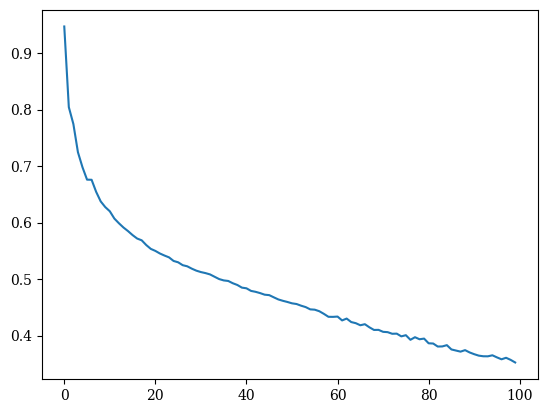

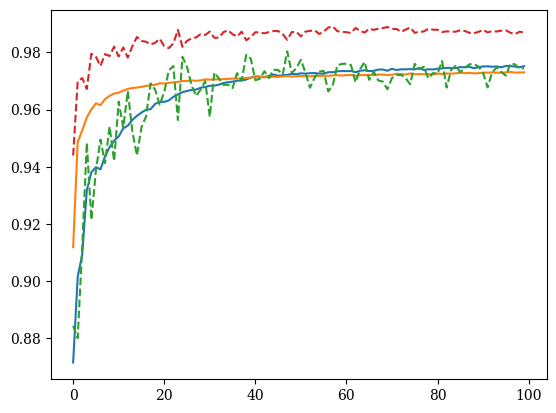

In [164]:
plt.plot(maxnorm_res_2['training_loss'], label='Training Loss')
plt.show()
plt.plot(maxnorm_res_2['training_precision'], label='Tr Precision')
plt.plot(maxnorm_res_2['training_recall'], label='Tr Recall')
plt.plot(maxnorm_res_2['validation_precision'], label='Val Precision', linestyle='--')
plt.plot(maxnorm_res_2['validation_recall'], label='Val Recall', linestyle='--')
plt.show()

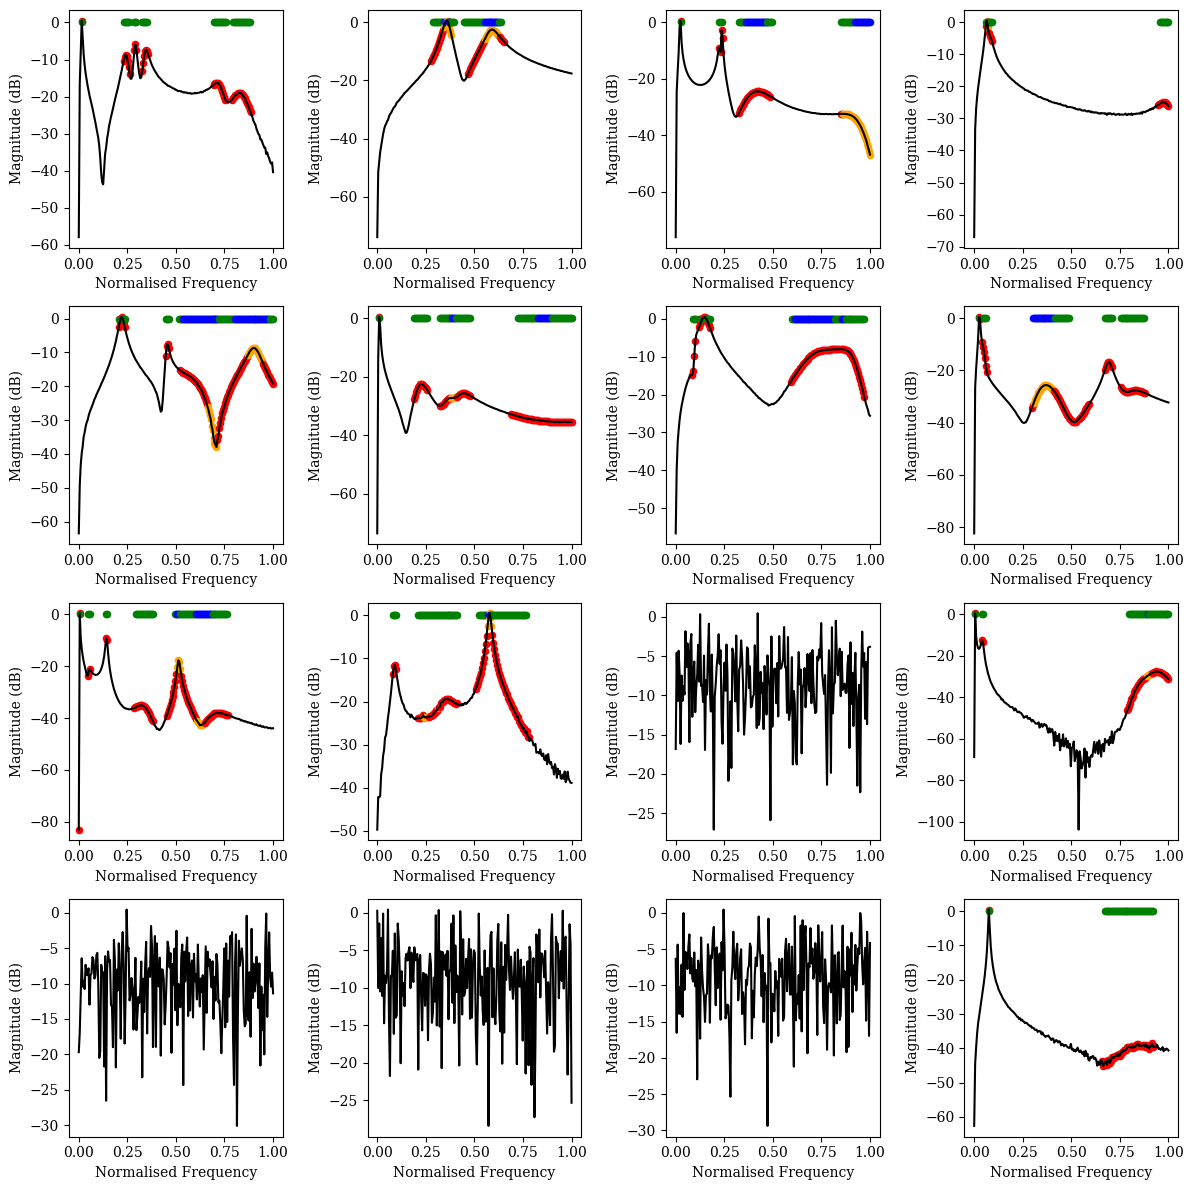

In [184]:
plot_predictions_extended(maxnorm_model_2, num_w_points=200, normalise=None, neg_an=True, multiclass=True, nrows=4, ncols=4)

## 09/02

In [194]:
X, Y, ws, zs = generate_dat_extended(32*1000, 200, multiclass=True, normalise=None, neg_an=True)
Xval, Yval, wsval, zsval = generate_dat_extended(32*250, 200, multiclass=True, normalise=None, neg_an=True)

In [192]:
print(weights)

tensor([0.4576, 1.5853, 5.4438])


In [195]:
weights_2 = torch.tensor([0.45, 1.0, 3.0])

In [196]:
maxnorm_model_3 = BiLSTM(input_size=4, hidden_size=120, num_layers=3, num_classes=3)
maxnorm_res_3 = train_model_multiclass(maxnorm_model_3, X, Y, Xval, Yval, name='norm_95_max(09.02)', num_epochs=100, batch_size=128, weights=weights_2)

  1%|          | 1/100 [04:58<8:12:31, 298.50s/it]

Epoch [1/100], Loss: 0.8456931903362274, Precision: 0.9270298988442833, Recall: 0.9061949744485222
Val Loss: 0.6463958907127381, Validation Precision: 0.95990092566212, Validation Recall: 0.9419502719236167


  2%|▏         | 2/100 [10:03<8:14:16, 302.62s/it]

Epoch [2/100], Loss: 0.707644737958908, Precision: 0.944116694054653, Recall: 0.9451611458906117
Val Loss: 0.588594030380249, Validation Precision: 0.9521467160272384, Validation Recall: 0.9623363815654397


  3%|▎         | 3/100 [15:06<8:09:07, 302.55s/it]

Epoch [3/100], Loss: 0.6746669421195984, Precision: 0.9517269794516807, Recall: 0.9480918537801207
Val Loss: 0.5584196128845215, Validation Precision: 0.9602879689787632, Validation Recall: 0.960115853994216


  4%|▍         | 4/100 [20:14<8:07:35, 304.75s/it]

Epoch [4/100], Loss: 0.6332658290863037, Precision: 0.9598779932856218, Recall: 0.9538518456592024
Val Loss: 0.5306835732460022, Validation Precision: 0.9601640172243523, Validation Recall: 0.9657272798433453


  5%|▌         | 5/100 [25:24<8:05:32, 306.66s/it]

Epoch [5/100], Loss: 0.6056869139671326, Precision: 0.9631034188953241, Recall: 0.9569258966011538
Val Loss: 0.48584410357475283, Validation Precision: 0.969587037115798, Validation Recall: 0.9715204763092957


  6%|▌         | 6/100 [30:37<8:03:30, 308.62s/it]

Epoch [6/100], Loss: 0.5847181267738343, Precision: 0.9655556120398224, Recall: 0.958987865406157
Val Loss: 0.4694097566604614, Validation Precision: 0.9727598070574333, Validation Recall: 0.9718579307669684


  7%|▋         | 7/100 [35:51<8:01:06, 310.39s/it]

Epoch [7/100], Loss: 0.5701902267932892, Precision: 0.9670039851834457, Recall: 0.960277563956432
Val Loss: 0.45530261301994324, Validation Precision: 0.9752456252575714, Validation Recall: 0.9718196464736639


  8%|▊         | 8/100 [41:05<7:57:58, 311.72s/it]

Epoch [8/100], Loss: 0.55694555747509, Precision: 0.9691095018905164, Recall: 0.9612349914015721
Val Loss: 0.44248986315727235, Validation Precision: 0.9678437594197937, Validation Recall: 0.9773026779345885


  9%|▉         | 9/100 [46:22<7:54:58, 313.17s/it]

Epoch [9/100], Loss: 0.5412242892980575, Precision: 0.9706423488354289, Recall: 0.9625261687215139
Val Loss: 0.4315161156654358, Validation Precision: 0.971225647577113, Validation Recall: 0.978726201303934


 10%|█         | 10/100 [51:38<7:51:14, 314.17s/it]

Epoch [10/100], Loss: 0.5326714185476303, Precision: 0.9719760304874623, Recall: 0.9632408272973195
Val Loss: 0.41693103265762327, Validation Precision: 0.9704778881287136, Validation Recall: 0.979453561684691


 11%|█         | 11/100 [56:52<7:45:54, 314.09s/it]

Epoch [11/100], Loss: 0.5240234825611114, Precision: 0.973239009949483, Recall: 0.9637059243065892
Val Loss: 0.40499533295631407, Validation Precision: 0.9731709708642714, Validation Recall: 0.9804191057175192


 12%|█▏        | 12/100 [1:02:03<7:39:19, 313.17s/it]

Epoch [12/100], Loss: 0.5150221074819565, Precision: 0.9738784737875047, Recall: 0.9643246618243175
Val Loss: 0.4109299964904785, Validation Precision: 0.9710635447040705, Validation Recall: 0.9811879791721156


 13%|█▎        | 13/100 [1:07:12<7:32:28, 312.05s/it]

Epoch [13/100], Loss: 0.5082997012138367, Precision: 0.9743542285697796, Recall: 0.9649143670155019
Val Loss: 0.397244439125061, Validation Precision: 0.9788829733118596, Validation Recall: 0.979087210952381


 14%|█▍        | 14/100 [1:12:24<7:26:58, 311.85s/it]

Epoch [14/100], Loss: 0.501089813709259, Precision: 0.9757632529058413, Recall: 0.9652912736045546
Val Loss: 0.39425041508674624, Validation Precision: 0.978710937430191, Validation Recall: 0.9801050188614367


 15%|█▌        | 15/100 [1:17:35<7:21:26, 311.61s/it]

Epoch [15/100], Loss: 0.49423290705680845, Precision: 0.9757188021277802, Recall: 0.966013286096461
Val Loss: 0.37662758922576905, Validation Precision: 0.9800341833548852, Validation Recall: 0.9799095943083214


 16%|█▌        | 16/100 [1:22:45<7:15:28, 311.06s/it]

Epoch [16/100], Loss: 0.490147407412529, Precision: 0.976519473802308, Recall: 0.9660678824192444
Val Loss: 0.394606232881546, Validation Precision: 0.9793463343111206, Validation Recall: 0.9782479667546705


 17%|█▋        | 17/100 [1:27:56<7:10:27, 311.17s/it]

Epoch [17/100], Loss: 0.48434671807289126, Precision: 0.9772036022349471, Recall: 0.9666125268706989
Val Loss: 0.3754759109020233, Validation Precision: 0.981963414917411, Validation Recall: 0.9806366023176413


 18%|█▊        | 18/100 [1:33:06<7:04:38, 310.71s/it]

Epoch [18/100], Loss: 0.47890666460990905, Precision: 0.9773818913217208, Recall: 0.9669503645563348
Val Loss: 0.3698753321170807, Validation Precision: 0.9821632589414253, Validation Recall: 0.9816914979774672


 19%|█▉        | 19/100 [1:38:12<6:57:50, 309.51s/it]

Epoch [19/100], Loss: 0.4726420392990112, Precision: 0.9783305334512872, Recall: 0.9672554406452754
Val Loss: 0.3700464901924133, Validation Precision: 0.9754047767164471, Validation Recall: 0.9836173562919108


 20%|██        | 20/100 [1:43:22<6:52:33, 309.42s/it]

Epoch [20/100], Loss: 0.4698135050535202, Precision: 0.9787030884863608, Recall: 0.9672939733276561
Val Loss: 0.3629727191925049, Validation Precision: 0.9763503928764002, Validation Recall: 0.9839566180269766


 21%|██        | 21/100 [1:48:29<6:46:29, 308.73s/it]

Epoch [21/100], Loss: 0.4651548345088959, Precision: 0.9787328694364875, Recall: 0.9676199048554163
Val Loss: 0.3594708046913147, Validation Precision: 0.9842075102003253, Validation Recall: 0.9809051014407005


 22%|██▏       | 22/100 [1:53:33<6:39:47, 307.54s/it]

Epoch [22/100], Loss: 0.4619365068674087, Precision: 0.9789537090106712, Recall: 0.967704795080927
Val Loss: 0.3654163472652435, Validation Precision: 0.9787113488512736, Validation Recall: 0.9827475274151198


 23%|██▎       | 23/100 [1:58:40<6:34:14, 307.20s/it]

Epoch [23/100], Loss: 0.45670345962047576, Precision: 0.9795908831637706, Recall: 0.9680660869522408
Val Loss: 0.3560227451324463, Validation Precision: 0.9771980925635692, Validation Recall: 0.9849861608444416


 24%|██▍       | 24/100 [2:03:54<6:31:53, 309.38s/it]

Epoch [24/100], Loss: 0.45210589373111726, Precision: 0.9798542871962814, Recall: 0.9684598474068749
Val Loss: 0.3551518602371216, Validation Precision: 0.9823356792791493, Validation Recall: 0.9831299427240372


 25%|██▌       | 25/100 [2:09:09<6:28:52, 311.10s/it]

Epoch [25/100], Loss: 0.4506523598432541, Precision: 0.9797203370069223, Recall: 0.9682690462119986
Val Loss: 0.34951191759109496, Validation Precision: 0.9848600135828853, Validation Recall: 0.9837564739641965


 26%|██▌       | 26/100 [2:14:22<6:24:15, 311.56s/it]

Epoch [26/100], Loss: 0.4458250288963318, Precision: 0.9801414928182384, Recall: 0.9685879713136182
Val Loss: 0.3470502128601074, Validation Precision: 0.9772854992523915, Validation Recall: 0.9859228944033689


 27%|██▋       | 27/100 [2:19:37<6:20:07, 312.44s/it]

Epoch [27/100], Loss: 0.443922576546669, Precision: 0.9802885225596814, Recall: 0.9687143390481358
Val Loss: 0.34811336660385134, Validation Precision: 0.9827553497436975, Validation Recall: 0.9834638840956156


 28%|██▊       | 28/100 [2:24:50<6:15:15, 312.71s/it]

Epoch [28/100], Loss: 0.4468838099241257, Precision: 0.9798406517083328, Recall: 0.9683147629714532
Val Loss: 0.34845297026634214, Validation Precision: 0.9819588585303859, Validation Recall: 0.9836969121520438


 29%|██▉       | 29/100 [2:30:02<6:09:46, 312.49s/it]

Epoch [29/100], Loss: 0.4406119207143784, Precision: 0.9805841273091649, Recall: 0.9686273855617686
Val Loss: 0.34203504943847657, Validation Precision: 0.9829021999792448, Validation Recall: 0.984601606829504


 30%|███       | 30/100 [2:35:09<6:02:49, 310.99s/it]

Epoch [30/100], Loss: 0.43456647264957426, Precision: 0.981146689877104, Recall: 0.9691320713443003
Val Loss: 0.33791328954696653, Validation Precision: 0.9825498645141194, Validation Recall: 0.9852527437461386


 31%|███       | 31/100 [2:40:17<5:56:21, 309.88s/it]

Epoch [31/100], Loss: 0.4332430385351181, Precision: 0.9806742274502066, Recall: 0.9690707239848368
Val Loss: 0.34992757892608645, Validation Precision: 0.9831238927759182, Validation Recall: 0.9838496563707253


 32%|███▏      | 32/100 [2:45:27<5:51:28, 310.12s/it]

Epoch [32/100], Loss: 0.4289555819034576, Precision: 0.9812669059016043, Recall: 0.9692825280383397
Val Loss: 0.3476757159233093, Validation Precision: 0.9792092844615521, Validation Recall: 0.9853214982040394


 33%|███▎      | 33/100 [2:50:35<5:45:32, 309.44s/it]

Epoch [33/100], Loss: 0.4254089221954346, Precision: 0.9815103367896537, Recall: 0.9691932952428858
Val Loss: 0.33905454421043396, Validation Precision: 0.9846127068353191, Validation Recall: 0.9843948196917235


 34%|███▍      | 34/100 [2:55:42<5:39:39, 308.78s/it]

Epoch [34/100], Loss: 0.42345127379894254, Precision: 0.9814500292491756, Recall: 0.96945968864628
Val Loss: 0.3370783131122589, Validation Precision: 0.9794988060010992, Validation Recall: 0.9864164540562069


 35%|███▌      | 35/100 [3:00:54<5:35:18, 309.51s/it]

Epoch [35/100], Loss: 0.4201977264881134, Precision: 0.9813434770208775, Recall: 0.9695144421010627
Val Loss: 0.34524229645729065, Validation Precision: 0.9796063108217253, Validation Recall: 0.9859715716290753


 36%|███▌      | 36/100 [3:06:12<5:33:06, 312.29s/it]

Epoch [36/100], Loss: 0.41748596012592315, Precision: 0.9815833069874518, Recall: 0.9697332063386798
Val Loss: 0.3406222295761108, Validation Precision: 0.9863480120564878, Validation Recall: 0.9836716691704975


 37%|███▋      | 37/100 [3:11:29<5:29:06, 313.44s/it]

Epoch [37/100], Loss: 0.41252642941474915, Precision: 0.9818404126978324, Recall: 0.9698166704894402
Val Loss: 0.34456648731231687, Validation Precision: 0.9788128694204241, Validation Recall: 0.9857697966204092


 38%|███▊      | 38/100 [3:16:44<5:24:34, 314.11s/it]

Epoch [38/100], Loss: 0.41115870940685273, Precision: 0.9818911676601028, Recall: 0.9697014624049111
Val Loss: 0.3427343168258667, Validation Precision: 0.9816478150042065, Validation Recall: 0.9856156588829607


 39%|███▉      | 39/100 [3:22:02<5:20:20, 315.10s/it]

Epoch [39/100], Loss: 0.40888808119297027, Precision: 0.9816901308568892, Recall: 0.9698047090257701
Val Loss: 0.3391963937282562, Validation Precision: 0.982015504471566, Validation Recall: 0.9864913137682604


 40%|████      | 40/100 [3:27:19<5:15:51, 315.87s/it]

Epoch [40/100], Loss: 0.40576411998271944, Precision: 0.9819428762963871, Recall: 0.9697912628855299
Val Loss: 0.33891813158988954, Validation Precision: 0.9819154008997791, Validation Recall: 0.9860532625094909


 41%|████      | 41/100 [3:32:30<5:08:57, 314.19s/it]

Epoch [41/100], Loss: 0.40419028425216674, Precision: 0.9818922925158838, Recall: 0.9698194722591116
Val Loss: 0.34695363211631775, Validation Precision: 0.9818312245480104, Validation Recall: 0.985234486085721


 42%|████▏     | 42/100 [3:37:37<5:01:42, 312.12s/it]

Epoch [42/100], Loss: 0.3991585532426834, Precision: 0.982096106130563, Recall: 0.9700177826198518
Val Loss: 0.34626942372322084, Validation Precision: 0.9857820843889042, Validation Recall: 0.9846455527899503


 43%|████▎     | 43/100 [3:42:45<4:55:22, 310.92s/it]

Epoch [43/100], Loss: 0.39660055315494536, Precision: 0.9821457807413873, Recall: 0.9700478992917776
Val Loss: 0.34996612882614136, Validation Precision: 0.9843865415556297, Validation Recall: 0.9840224039446384


 44%|████▍     | 44/100 [3:47:53<4:49:14, 309.90s/it]

Epoch [44/100], Loss: 0.39402045953273773, Precision: 0.9819578217354414, Recall: 0.9702951919769663
Val Loss: 0.3509587686061859, Validation Precision: 0.9817244338363595, Validation Recall: 0.9857618695141597


 45%|████▌     | 45/100 [3:52:57<4:42:27, 308.14s/it]

Epoch [45/100], Loss: 0.39361282062530517, Precision: 0.9819437304268908, Recall: 0.9701985723075083
Val Loss: 0.34920725440979006, Validation Precision: 0.981377713438456, Validation Recall: 0.9860905249751521


 46%|████▌     | 46/100 [3:58:03<4:36:47, 307.54s/it]

Epoch [46/100], Loss: 0.3877206418514252, Precision: 0.9823236057664833, Recall: 0.9704516834130573
Val Loss: 0.35188101840019226, Validation Precision: 0.9819823861120206, Validation Recall: 0.9866187129932418


 47%|████▋     | 47/100 [4:03:06<4:30:32, 306.28s/it]

Epoch [47/100], Loss: 0.3857900280952454, Precision: 0.9822938893567946, Recall: 0.9703617911285952
Val Loss: 0.35714292907714845, Validation Precision: 0.9817848704473465, Validation Recall: 0.9858468723275529


 48%|████▊     | 48/100 [4:08:13<4:25:43, 306.61s/it]

Epoch [48/100], Loss: 0.38349709939956667, Precision: 0.9824880582146144, Recall: 0.9705220547815239
Val Loss: 0.35041370463371274, Validation Precision: 0.9824843951755229, Validation Recall: 0.9858586975604743


 49%|████▉     | 49/100 [4:13:28<4:22:34, 308.90s/it]

Epoch [49/100], Loss: 0.3819541119337082, Precision: 0.9823573649885599, Recall: 0.9704013012074648
Val Loss: 0.3577085933685303, Validation Precision: 0.9826467195605945, Validation Recall: 0.9853856543158981


 50%|█████     | 50/100 [4:18:38<4:17:51, 309.43s/it]

Epoch [50/100], Loss: 0.37950593054294585, Precision: 0.9823042830752104, Recall: 0.9705121470629445
Val Loss: 0.3634790005683899, Validation Precision: 0.9857693086264449, Validation Recall: 0.9831338650570789


 51%|█████     | 51/100 [4:23:48<4:12:52, 309.64s/it]

Epoch [51/100], Loss: 0.37421835017204286, Precision: 0.9824937594968473, Recall: 0.9705815321115501
Val Loss: 0.3617585282325745, Validation Precision: 0.9798837036366252, Validation Recall: 0.9870945806841688


 52%|█████▏    | 52/100 [4:28:57<4:07:26, 309.31s/it]

Epoch [52/100], Loss: 0.3705918600559235, Precision: 0.9826443726912972, Recall: 0.9706911861257203
Val Loss: 0.3697334218025208, Validation Precision: 0.9818287768224123, Validation Recall: 0.9861014637490747


 53%|█████▎    | 53/100 [4:34:08<4:02:39, 309.78s/it]

Epoch [53/100], Loss: 0.36893457543849945, Precision: 0.9827180650168146, Recall: 0.9706292488757433
Val Loss: 0.38127212643623354, Validation Precision: 0.9828944443656169, Validation Recall: 0.9849391028046236


 54%|█████▍    | 54/100 [4:39:22<3:58:26, 311.00s/it]

Epoch [54/100], Loss: 0.3657666577100754, Precision: 0.9826853347890001, Recall: 0.9707906136370528
Val Loss: 0.3626660482883453, Validation Precision: 0.9769079898187463, Validation Recall: 0.9883531678914033


 55%|█████▌    | 55/100 [4:44:33<3:53:24, 311.22s/it]

Epoch [55/100], Loss: 0.36738774383068085, Precision: 0.9823662972855464, Recall: 0.9706804803791869
Val Loss: 0.3711994903087616, Validation Precision: 0.983146607443313, Validation Recall: 0.9850074548142459


 56%|█████▌    | 56/100 [4:49:40<3:47:07, 309.71s/it]

Epoch [56/100], Loss: 0.3607418249845505, Precision: 0.9827911184545222, Recall: 0.9708686395599005
Val Loss: 0.37230458068847655, Validation Precision: 0.9836118281527558, Validation Recall: 0.9854244435076868


 57%|█████▋    | 57/100 [4:54:47<3:41:26, 308.99s/it]

Epoch [57/100], Loss: 0.35757874143123625, Precision: 0.9826395392009339, Recall: 0.9709442294380981
Val Loss: 0.3756449062824249, Validation Precision: 0.9830365121675905, Validation Recall: 0.9859046423738076


 58%|█████▊    | 58/100 [4:59:56<3:36:13, 308.89s/it]

Epoch [58/100], Loss: 0.3541740262508392, Precision: 0.9827898648460014, Recall: 0.9711100894328444
Val Loss: 0.382460037946701, Validation Precision: 0.9833884181127517, Validation Recall: 0.9851294761062731


 59%|█████▉    | 59/100 [5:05:05<3:31:12, 309.08s/it]

Epoch [59/100], Loss: 0.35336292958259585, Precision: 0.9826435946573246, Recall: 0.971089676658989
Val Loss: 0.37494525480270385, Validation Precision: 0.9795967379358701, Validation Recall: 0.9872784679163391


 60%|██████    | 60/100 [5:10:14<3:26:01, 309.05s/it]

Epoch [60/100], Loss: 0.35001392936706544, Precision: 0.9829435748051885, Recall: 0.9711087355779892
Val Loss: 0.3827601079940796, Validation Precision: 0.9775780050651152, Validation Recall: 0.986979548016267


 61%|██████    | 61/100 [5:15:20<3:20:21, 308.24s/it]

Epoch [61/100], Loss: 0.3507448830604553, Precision: 0.9828684521213107, Recall: 0.9709699082061038
Val Loss: 0.38011358737945555, Validation Precision: 0.9801185799650809, Validation Recall: 0.9868956322313993


 62%|██████▏   | 62/100 [5:20:29<3:15:17, 308.35s/it]

Epoch [62/100], Loss: 0.3456021146774292, Precision: 0.9829737785489225, Recall: 0.9712136279238899
Val Loss: 0.38758276534080505, Validation Precision: 0.9776621618436474, Validation Recall: 0.9876492425297981


 63%|██████▎   | 63/100 [5:25:38<3:10:13, 308.48s/it]

Epoch [63/100], Loss: 0.3484078608751297, Precision: 0.982876387260652, Recall: 0.9710460525228263
Val Loss: 0.4039714479446411, Validation Precision: 0.9839523529174578, Validation Recall: 0.9855489295722831


 64%|██████▍   | 64/100 [5:30:46<3:04:58, 308.29s/it]

Epoch [64/100], Loss: 0.34692193853855136, Precision: 0.9825847713595666, Recall: 0.970981976690729
Val Loss: 0.3969532940387726, Validation Precision: 0.9812295599611085, Validation Recall: 0.9858770350196128


 65%|██████▌   | 65/100 [5:35:54<2:59:45, 308.15s/it]

Epoch [65/100], Loss: 0.3395042450428009, Precision: 0.9829813274842394, Recall: 0.9712973220005183
Val Loss: 0.4086558661460876, Validation Precision: 0.9830962003107742, Validation Recall: 0.9852633372199067


 66%|██████▌   | 66/100 [5:41:01<2:54:32, 308.02s/it]

Epoch [66/100], Loss: 0.3385419944524765, Precision: 0.98300453621025, Recall: 0.9714318260451965
Val Loss: 0.3967168917655945, Validation Precision: 0.9806007931781578, Validation Recall: 0.9861546286265139


 67%|██████▋   | 67/100 [5:46:05<2:48:38, 306.62s/it]

Epoch [67/100], Loss: 0.3397019909620285, Precision: 0.9826020673340058, Recall: 0.9713077262036554
Val Loss: 0.3988416509628296, Validation Precision: 0.9816905594288352, Validation Recall: 0.9861599804732778


 68%|██████▊   | 68/100 [5:51:09<2:43:11, 305.97s/it]

Epoch [68/100], Loss: 0.3327572391033173, Precision: 0.9829897489247454, Recall: 0.9715404651275751
Val Loss: 0.39684334921836856, Validation Precision: 0.9802724553581004, Validation Recall: 0.9869776695377214


 69%|██████▉   | 69/100 [5:56:13<2:37:50, 305.50s/it]

Epoch [69/100], Loss: 0.32976077175140384, Precision: 0.9833292333570183, Recall: 0.9716259441411718
Val Loss: 0.4219744484424591, Validation Precision: 0.9835925268921819, Validation Recall: 0.9852083310405957


 70%|███████   | 70/100 [6:01:19<2:32:44, 305.47s/it]

Epoch [70/100], Loss: 0.32956910514831544, Precision: 0.9830778883029545, Recall: 0.9713828553506744
Val Loss: 0.42057364583015444, Validation Precision: 0.982653326288423, Validation Recall: 0.9855944445314314


 71%|███████   | 71/100 [6:06:23<2:27:30, 305.19s/it]

Epoch [71/100], Loss: 0.3272882301807404, Precision: 0.9831024710371026, Recall: 0.971499180970683
Val Loss: 0.4182890033721924, Validation Precision: 0.9833645774144079, Validation Recall: 0.9858716718679537


 72%|███████▏  | 72/100 [6:11:31<2:22:47, 306.00s/it]

Epoch [72/100], Loss: 0.3254328343868256, Precision: 0.9832808493874797, Recall: 0.9716141294072118
Val Loss: 0.409751948595047, Validation Precision: 0.9802848030514251, Validation Recall: 0.9864714485340669


 73%|███████▎  | 73/100 [6:16:42<2:18:19, 307.38s/it]

Epoch [73/100], Loss: 0.3192206697463989, Precision: 0.9832935481040932, Recall: 0.971879576668787
Val Loss: 0.43181891083717344, Validation Precision: 0.9809276157898121, Validation Recall: 0.986702581106953


 74%|███████▍  | 74/100 [6:21:49<2:13:10, 307.33s/it]

Epoch [74/100], Loss: 0.32045265758037567, Precision: 0.9832784397165767, Recall: 0.9717538874060894
Val Loss: 0.4192936320304871, Validation Precision: 0.9815156681006435, Validation Recall: 0.9867411929220633


 75%|███████▌  | 75/100 [6:26:53<2:07:40, 306.40s/it]

Epoch [75/100], Loss: 0.3176332341432571, Precision: 0.9832863240871699, Recall: 0.9717593944562284
Val Loss: 0.43963232016563414, Validation Precision: 0.9771239569833072, Validation Recall: 0.9873791075559396


 76%|███████▌  | 76/100 [6:31:59<2:02:26, 306.09s/it]

Epoch [76/100], Loss: 0.3162247161865234, Precision: 0.983266110990137, Recall: 0.9716749652547878
Val Loss: 0.4441229281425476, Validation Precision: 0.9827387214837837, Validation Recall: 0.985477492647895


 77%|███████▋  | 77/100 [6:37:03<1:57:09, 305.64s/it]

Epoch [77/100], Loss: 0.3264519966840744, Precision: 0.9827327379809024, Recall: 0.9714028861611074
Val Loss: 0.44055198001861573, Validation Precision: 0.9804780255895785, Validation Recall: 0.9865455496791169


 78%|███████▊  | 78/100 [6:42:11<1:52:18, 306.28s/it]

Epoch [78/100], Loss: 0.3151954263448715, Precision: 0.9835055204445279, Recall: 0.9718919917913392
Val Loss: 0.434552405834198, Validation Precision: 0.9802031957996413, Validation Recall: 0.9866474566777873


 79%|███████▉  | 79/100 [6:47:17<1:47:12, 306.31s/it]

Epoch [79/100], Loss: 0.31325365018844603, Precision: 0.9833221984226872, Recall: 0.9720190923454635
Val Loss: 0.4309017550945282, Validation Precision: 0.9788176105354695, Validation Recall: 0.9871669019698502


 80%|████████  | 80/100 [6:52:21<1:41:50, 305.50s/it]

Epoch [80/100], Loss: 0.3101099885702133, Precision: 0.983423493104577, Recall: 0.9721212406023442
Val Loss: 0.4447735493183136, Validation Precision: 0.9818291073894557, Validation Recall: 0.9860357145558685


 81%|████████  | 81/100 [6:57:27<1:36:49, 305.75s/it]

Epoch [81/100], Loss: 0.3102299418449402, Precision: 0.9834425288772085, Recall: 0.9721093306724251
Val Loss: 0.42902844071388246, Validation Precision: 0.9822500444768936, Validation Recall: 0.9856139219192804


 82%|████████▏ | 82/100 [7:02:30<1:31:26, 304.81s/it]

Epoch [82/100], Loss: 0.30891985499858854, Precision: 0.983263918508268, Recall: 0.9720548126544193
Val Loss: 0.44465086960792544, Validation Precision: 0.9813416769508796, Validation Recall: 0.9870471762888584


 83%|████████▎ | 83/100 [7:07:35<1:26:22, 304.84s/it]

Epoch [83/100], Loss: 0.3064523591995239, Precision: 0.9836054479196996, Recall: 0.972071594092991
Val Loss: 0.4620947940349579, Validation Precision: 0.9802561846569132, Validation Recall: 0.9866547383271121


 84%|████████▍ | 84/100 [7:12:41<1:21:21, 305.08s/it]

Epoch [84/100], Loss: 0.304441712975502, Precision: 0.9834352243849961, Recall: 0.972291395639181
Val Loss: 0.4506137158870697, Validation Precision: 0.9784329952804423, Validation Recall: 0.9870761924064869


 85%|████████▌ | 85/100 [7:17:45<1:16:14, 304.94s/it]

Epoch [85/100], Loss: 0.3005547057390213, Precision: 0.9835623799367083, Recall: 0.9722414129452428
Val Loss: 0.4569348406791687, Validation Precision: 0.9795500186475572, Validation Recall: 0.9868515628908483


 86%|████████▌ | 86/100 [7:22:48<1:11:00, 304.33s/it]

Epoch [86/100], Loss: 0.2998298758268356, Precision: 0.9835645785408119, Recall: 0.9723091737717523
Val Loss: 0.4426758658885956, Validation Precision: 0.9820415914942606, Validation Recall: 0.9858720837213191


 87%|████████▋ | 87/100 [7:27:53<1:05:58, 304.46s/it]

Epoch [87/100], Loss: 0.30146812736988066, Precision: 0.9836552976260587, Recall: 0.9723969272165065
Val Loss: 0.45297557735443117, Validation Precision: 0.9806984696746432, Validation Recall: 0.9869930427406642


 88%|████████▊ | 88/100 [7:32:57<1:00:51, 304.31s/it]

Epoch [88/100], Loss: 0.293879510641098, Precision: 0.9839255845653441, Recall: 0.9725728044170759
Val Loss: 0.4548836393356323, Validation Precision: 0.9794897662629941, Validation Recall: 0.9874979291336657


 89%|████████▉ | 89/100 [7:38:02<55:49, 304.55s/it]  

Epoch [89/100], Loss: 0.29629031574726106, Precision: 0.9836423585679798, Recall: 0.9724988575862491
Val Loss: 0.45674499988555906, Validation Precision: 0.9819005219887528, Validation Recall: 0.9858456518135854


 90%|█████████ | 90/100 [7:43:11<50:59, 305.93s/it]

Epoch [90/100], Loss: 0.29446330964565276, Precision: 0.9838040605740221, Recall: 0.9725214249325085
Val Loss: 0.4512923972606659, Validation Precision: 0.9841944921753655, Validation Recall: 0.9849356623693442


 91%|█████████ | 91/100 [7:48:17<45:54, 306.03s/it]

Epoch [91/100], Loss: 0.2913880562186241, Precision: 0.9840956268685267, Recall: 0.9727081933206863
Val Loss: 0.47523374199867247, Validation Precision: 0.9826315251631709, Validation Recall: 0.9862982934468616


 92%|█████████▏| 92/100 [7:53:24<40:48, 306.10s/it]

Epoch [92/100], Loss: 0.28906773853302004, Precision: 0.9838727314631288, Recall: 0.9728118633525262
Val Loss: 0.48451001596450805, Validation Precision: 0.9799684712971412, Validation Recall: 0.9869951021603373


 93%|█████████▎| 93/100 [7:58:31<35:46, 306.62s/it]

Epoch [93/100], Loss: 0.2909611560106277, Precision: 0.9840089926251119, Recall: 0.9726023377798703
Val Loss: 0.4965032832622528, Validation Precision: 0.978770781329236, Validation Recall: 0.9866271926112826


 94%|█████████▍| 94/100 [8:03:37<30:38, 306.38s/it]

Epoch [94/100], Loss: 0.2929560215473175, Precision: 0.9838481664763767, Recall: 0.9726768795024792
Val Loss: 0.48839588165283204, Validation Precision: 0.9703476148059181, Validation Recall: 0.9876353607213155


 95%|█████████▌| 95/100 [8:08:40<25:26, 305.35s/it]

Epoch [95/100], Loss: 0.2861244332194328, Precision: 0.9841130691491843, Recall: 0.9729073142580311
Val Loss: 0.4632567849159241, Validation Precision: 0.9836943324800024, Validation Recall: 0.985486861069679


 96%|█████████▌| 96/100 [8:13:42<20:17, 304.29s/it]

Epoch [96/100], Loss: 0.2898778903484345, Precision: 0.983843043351252, Recall: 0.9726502381349402
Val Loss: 0.48477806067466733, Validation Precision: 0.9808955440796328, Validation Recall: 0.9866423567831987


 97%|█████████▋| 97/100 [8:18:44<15:10, 303.55s/it]

Epoch [97/100], Loss: 0.2840832559466362, Precision: 0.9841013651124892, Recall: 0.9728348235454093
Val Loss: 0.4843053758144379, Validation Precision: 0.978097479112101, Validation Recall: 0.9870906669540748


 98%|█████████▊| 98/100 [8:23:47<10:06, 303.34s/it]

Epoch [98/100], Loss: 0.28209043592214583, Precision: 0.9842449719722879, Recall: 0.972878321711907
Val Loss: 0.49887795257568357, Validation Precision: 0.9807686161325574, Validation Recall: 0.9862803945185071


 99%|█████████▉| 99/100 [8:28:51<05:03, 303.74s/it]

Epoch [99/100], Loss: 0.2860772614479065, Precision: 0.9837498981935169, Recall: 0.9728363445532966
Val Loss: 0.5074639296531678, Validation Precision: 0.9809215353000686, Validation Recall: 0.985382806479036


100%|██████████| 100/100 [8:34:04<00:00, 308.44s/it]

Epoch [100/100], Loss: 0.283120854973793, Precision: 0.9841780639427475, Recall: 0.9727909415082489
Val Loss: 0.4797347011566162, Validation Precision: 0.9814607614918237, Validation Recall: 0.9864576417911496


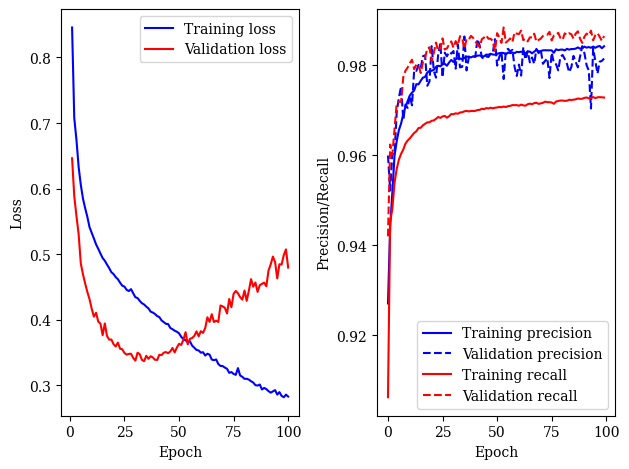

In [197]:
modal.plot_results(maxnorm_res_3)

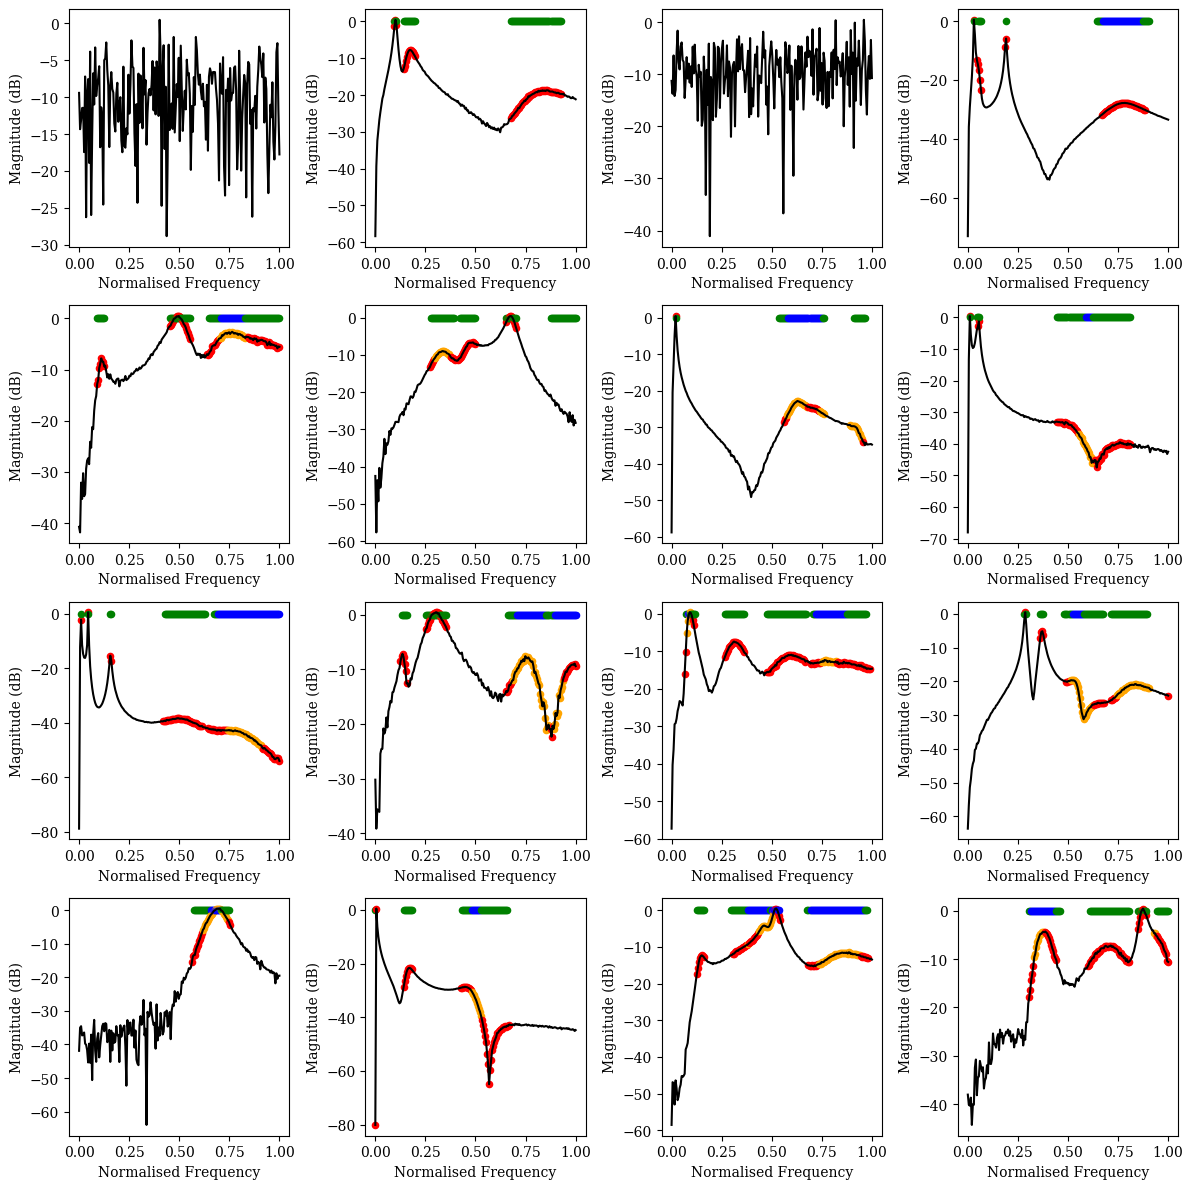

In [198]:
plot_predictions_extended(maxnorm_model_3, num_w_points=200, normalise=None, neg_an=True, multiclass=True, nrows=4, ncols=4)

## 10/02

### Training new model, with mag, phase and logmag as inputs 

In [230]:
Xlog, ylog, _, __ = generate_dat_extended(32*3000, 200, multiclass=True, normalise=None, neg_an=True, logmag=True)
Xlogval, ylogval, _, __ = generate_dat_extended(32*250, 200, multiclass=True, normalise=None, neg_an=True, logmag=True)

In [45]:
class BiLSTM2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        # calls parent class constructor
        super(BiLSTM2, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=0.0)
        # hidden_size * 2 because we are using a bidirectional RNN (double the length of the hidden state)
        self.fc = nn.Linear(hidden_size*2, num_classes)
        self.droput = nn.Dropout(0.3)
        # self.bn = nn.BatchNorm1d(hidden_size*2)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        # out = out.permute(0, 2, 1)
        # out = self.bn(out)
        # sequence-to-sequence classification problem where you want to classify each time step in the sequence independently.
        # Pass each time step's output through a fully connected layer
        out = self.fc(out)
        out = self.droput(out)
        return out

In [247]:
maxnorm_model_4 = BiLSTM2(input_size=5, hidden_size=45, num_layers=3, num_classes=3)
print(sum(p.numel() for p in maxnorm_model_4.parameters() if p.requires_grad))


117633


In [248]:
maxnorm_res_4 = train_model_multiclass(maxnorm_model_4, Xlog, ylog, Xlogval, ylogval, name='norm_95_max(10.02)', num_epochs=30, batch_size=128, weights=weights_2)

  3%|▎         | 1/30 [05:36<2:42:37, 336.45s/it]

Epoch [1/30], Loss: 0.7563061239719391, Precision: 0.9377301792731986, Recall: 0.9294565643919692
Val Loss: 0.5718660054206848, Validation Precision: 0.9716530229124114, Validation Recall: 0.954595775006952


  7%|▋         | 2/30 [11:14<2:37:26, 337.38s/it]

Epoch [2/30], Loss: 0.6275033554236095, Precision: 0.9611126588370953, Recall: 0.9549365910486284
Val Loss: 0.502716875553131, Validation Precision: 0.9698191365605155, Validation Recall: 0.9677330010341674


 10%|█         | 3/30 [16:53<2:32:03, 337.90s/it]

Epoch [3/30], Loss: 0.5808681336243947, Precision: 0.9662352230512673, Recall: 0.9596298166797578
Val Loss: 0.463195540189743, Validation Precision: 0.9763524961891136, Validation Recall: 0.9702743507590386


 13%|█▎        | 4/30 [22:35<2:27:10, 339.64s/it]

Epoch [4/30], Loss: 0.5466145547628403, Precision: 0.9703346647530875, Recall: 0.9624441634391915
Val Loss: 0.4274472284317017, Validation Precision: 0.9753267331645642, Validation Recall: 0.9756750349762673


 17%|█▋        | 5/30 [28:17<2:21:50, 340.43s/it]

Epoch [5/30], Loss: 0.5219648810625076, Precision: 0.9732130169498467, Recall: 0.9643807391829405
Val Loss: 0.4028426899909973, Validation Precision: 0.9772587596126762, Validation Recall: 0.9780946985405704


 20%|██        | 6/30 [34:02<2:16:48, 342.04s/it]

Epoch [6/30], Loss: 0.5070653655131658, Precision: 0.9751069782635309, Recall: 0.9655049351059538
Val Loss: 0.3967544591426849, Validation Precision: 0.9749328175160255, Validation Recall: 0.9802357639561665


 23%|██▎       | 7/30 [39:43<2:11:02, 341.85s/it]

Epoch [7/30], Loss: 0.4941698690255483, Precision: 0.9768789256290347, Recall: 0.9664118700405405
Val Loss: 0.37533363938331604, Validation Precision: 0.9805211753314445, Validation Recall: 0.9804924935031037


 27%|██▋       | 8/30 [45:21<2:04:55, 340.69s/it]

Epoch [8/30], Loss: 0.4838184598684311, Precision: 0.9777459002350388, Recall: 0.9669813485509713
Val Loss: 0.3658005163669586, Validation Precision: 0.9767545277240802, Validation Recall: 0.9832818189640131


 30%|███       | 9/30 [51:04<1:59:23, 341.11s/it]

Epoch [9/30], Loss: 0.47566361848513283, Precision: 0.9786808700101115, Recall: 0.9675290940524354
Val Loss: 0.36368890714645385, Validation Precision: 0.9728817926414716, Validation Recall: 0.9849946616281832


 33%|███▎      | 10/30 [56:41<1:53:19, 340.00s/it]

Epoch [10/30], Loss: 0.4673531972169876, Precision: 0.9795678761779908, Recall: 0.9681189429096034
Val Loss: 0.3488175604343414, Validation Precision: 0.9833014563450324, Validation Recall: 0.9818419825329266


 37%|███▋      | 11/30 [1:02:21<1:47:41, 340.10s/it]

Epoch [11/30], Loss: 0.4608146416346232, Precision: 0.980103967356673, Recall: 0.9683925983425641
Val Loss: 0.35133626198768614, Validation Precision: 0.9845883945794892, Validation Recall: 0.9809514786585266


 40%|████      | 12/30 [1:08:01<1:41:58, 339.92s/it]

Epoch [12/30], Loss: 0.45511993726094563, Precision: 0.9809849056052884, Recall: 0.968765986301762
Val Loss: 0.34787227272987364, Validation Precision: 0.9827596719591103, Validation Recall: 0.9829849796170538


 43%|████▎     | 13/30 [1:13:37<1:35:59, 338.80s/it]

Epoch [13/30], Loss: 0.44996126532554626, Precision: 0.9814270617636117, Recall: 0.9691369058440731
Val Loss: 0.3384851677417755, Validation Precision: 0.9817280823041835, Validation Recall: 0.9842725523869186


 47%|████▋     | 14/30 [1:19:15<1:30:14, 338.41s/it]

Epoch [14/30], Loss: 0.4458719304402669, Precision: 0.9819123908871877, Recall: 0.969328325807808
Val Loss: 0.3338312211036682, Validation Precision: 0.9796853974622436, Validation Recall: 0.9853547889223092


 50%|█████     | 15/30 [1:24:53<1:24:36, 338.45s/it]

Epoch [15/30], Loss: 0.4413042418162028, Precision: 0.9823389678244254, Recall: 0.9696335684576263
Val Loss: 0.32290350294113157, Validation Precision: 0.9808454169853436, Validation Recall: 0.9866636752034065


 53%|█████▎    | 16/30 [1:30:28<1:18:45, 337.52s/it]

Epoch [16/30], Loss: 0.4384700593551, Precision: 0.9826103051064353, Recall: 0.969763460204582
Val Loss: 0.3259997045993805, Validation Precision: 0.9867556937132295, Validation Recall: 0.983832343388922


 57%|█████▋    | 17/30 [1:36:06<1:13:08, 337.61s/it]

Epoch [17/30], Loss: 0.434327294031779, Precision: 0.9832328500955605, Recall: 0.9701304263615236
Val Loss: 0.31957140398025513, Validation Precision: 0.9848191123326118, Validation Recall: 0.9850755024217642


 60%|██████    | 18/30 [1:41:43<1:07:27, 337.31s/it]

Epoch [18/30], Loss: 0.43023180071512857, Precision: 0.9834556591534336, Recall: 0.9702918800504617
Val Loss: 0.3211279904842377, Validation Precision: 0.981267546225303, Validation Recall: 0.9872969588623889


 63%|██████▎   | 19/30 [1:47:15<1:01:34, 335.88s/it]

Epoch [19/30], Loss: 0.4278354035615921, Precision: 0.9836835292879335, Recall: 0.9704729495958789
Val Loss: 0.3129286937713623, Validation Precision: 0.9879079737104317, Validation Recall: 0.9844221086961435


 67%|██████▋   | 20/30 [1:52:49<55:52, 335.25s/it]  

Epoch [20/30], Loss: 0.42512146091461184, Precision: 0.9840009546850415, Recall: 0.9705385228775943
Val Loss: 0.3419888868331909, Validation Precision: 0.9695293282731478, Validation Recall: 0.9869212175324988


 70%|███████   | 21/30 [1:58:26<50:21, 335.68s/it]

Epoch [21/30], Loss: 0.42180276560783386, Precision: 0.9842117325323808, Recall: 0.9707353955778962
Val Loss: 0.31236584901809694, Validation Precision: 0.9827349055469724, Validation Recall: 0.9869155135407767


 73%|███████▎  | 22/30 [2:03:59<44:38, 334.79s/it]

Epoch [22/30], Loss: 0.41895668224493665, Precision: 0.9845490406381426, Recall: 0.9709538355548839
Val Loss: 0.3096944162845612, Validation Precision: 0.9817716715504892, Validation Recall: 0.9882791731445634


 77%|███████▋  | 23/30 [2:09:32<39:01, 334.46s/it]

Epoch [23/30], Loss: 0.4163468913634618, Precision: 0.9846677052759072, Recall: 0.9710982944351769
Val Loss: 0.3027427408695221, Validation Precision: 0.9828158029257706, Validation Recall: 0.9875384113874504


 80%|████████  | 24/30 [2:15:06<33:25, 334.32s/it]

Epoch [24/30], Loss: 0.4141240918636322, Precision: 0.9848951090514336, Recall: 0.9711469608737311
Val Loss: 0.30514817094802854, Validation Precision: 0.9834552904272515, Validation Recall: 0.9874184379798976


 83%|████████▎ | 25/30 [2:20:37<27:46, 333.28s/it]

Epoch [25/30], Loss: 0.41188514375686647, Precision: 0.9851040393774568, Recall: 0.9712765660643975
Val Loss: 0.29823842930793765, Validation Precision: 0.9854473640478774, Validation Recall: 0.9875326606988729


 87%|████████▋ | 26/30 [2:26:09<22:10, 332.74s/it]

Epoch [26/30], Loss: 0.4103114224274953, Precision: 0.9852264511046327, Recall: 0.9714246095460243
Val Loss: 0.30304055666923524, Validation Precision: 0.982081820901875, Validation Recall: 0.9884391347080798


 90%|█████████ | 27/30 [2:31:43<16:40, 333.37s/it]

Epoch [27/30], Loss: 0.4081372847159704, Precision: 0.9853718262713267, Recall: 0.97150773707346
Val Loss: 0.2979044029712677, Validation Precision: 0.9888074622517936, Validation Recall: 0.9861538810554156


 93%|█████████▎| 28/30 [2:37:15<11:05, 332.77s/it]

Epoch [28/30], Loss: 0.40645657149950665, Precision: 0.9855332331748232, Recall: 0.9715914167172646
Val Loss: 0.2976950695514679, Validation Precision: 0.9882203706560097, Validation Recall: 0.9868827280482512


 97%|█████████▋| 29/30 [2:42:57<05:35, 335.70s/it]

Epoch [29/30], Loss: 0.4038247851530711, Precision: 0.9857819742040039, Recall: 0.9717536861923457
Val Loss: 0.28905692529678345, Validation Precision: 0.9875684241425329, Validation Recall: 0.9875592740493384


100%|██████████| 30/30 [2:48:46<00:00, 337.54s/it]

Epoch [30/30], Loss: 0.40191885352134704, Precision: 0.9858849248534338, Recall: 0.9717572771477617
Val Loss: 0.2948418345451355, Validation Precision: 0.9873908383951511, Validation Recall: 0.9870445250632153


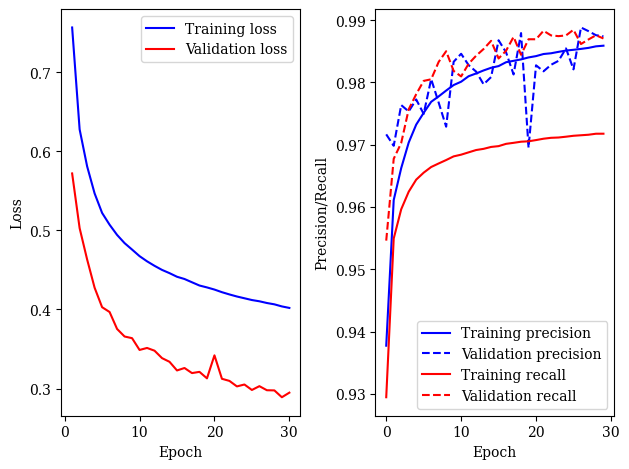

In [249]:
modal.plot_results(maxnorm_res_4)

In [250]:
maxnorm_res_5 = train_model_multiclass(maxnorm_model_4, Xlog, ylog, Xlogval, ylogval, name='norm_95_max(10.02)_50epochs', num_epochs=20, batch_size=128, weights=weights_2)

  5%|▌         | 1/20 [05:46<1:49:37, 346.21s/it]

Epoch [1/20], Loss: 0.40196501378218336, Precision: 0.9857321495184617, Recall: 0.9718221833294312
Val Loss: 0.2882947714328766, Validation Precision: 0.9867059464394572, Validation Recall: 0.9880841533717896


 10%|█         | 2/20 [11:28<1:43:09, 343.86s/it]

Epoch [2/20], Loss: 0.3996206976970037, Precision: 0.9860765470822144, Recall: 0.971889140849543
Val Loss: 0.2890773551464081, Validation Precision: 0.9878275502578502, Validation Recall: 0.987357596239185


 15%|█▌        | 3/20 [17:07<1:36:48, 341.67s/it]

Epoch [3/20], Loss: 0.3978950200080872, Precision: 0.9861303190416837, Recall: 0.9720371267681114
Val Loss: 0.2847380771636963, Validation Precision: 0.9859973553932144, Validation Recall: 0.9885699428291367


 20%|██        | 4/20 [22:44<1:30:39, 339.97s/it]

Epoch [4/20], Loss: 0.39721846477190653, Precision: 0.9861777395260335, Recall: 0.9720634175442587
Val Loss: 0.29893386077880857, Validation Precision: 0.9874213667242285, Validation Recall: 0.9869124682856625


 25%|██▌       | 5/20 [28:20<1:24:36, 338.43s/it]

Epoch [5/20], Loss: 0.39369796339670815, Precision: 0.9863660068520741, Recall: 0.9721710216340965
Val Loss: 0.2888037753105164, Validation Precision: 0.9860976677435211, Validation Recall: 0.9884398279465995


 30%|███       | 6/20 [33:55<1:18:41, 337.23s/it]

Epoch [6/20], Loss: 0.3933380651871363, Precision: 0.9863516774896163, Recall: 0.9722573691426034
Val Loss: 0.2873229253292084, Validation Precision: 0.9881726790193278, Validation Recall: 0.9874574331730038


 35%|███▌      | 7/20 [39:30<1:12:54, 336.48s/it]

Epoch [7/20], Loss: 0.3920225386619568, Precision: 0.986536118251444, Recall: 0.9723223610583933
Val Loss: 0.2989040284156799, Validation Precision: 0.983861813516373, Validation Recall: 0.9882216964879201


 40%|████      | 8/20 [45:05<1:07:11, 335.99s/it]

Epoch [8/20], Loss: 0.39089585379759473, Precision: 0.9865442610206325, Recall: 0.9723385566751402
Val Loss: 0.2977809412479401, Validation Precision: 0.9864276213499992, Validation Recall: 0.9868568744075517


 45%|████▌     | 9/20 [50:41<1:01:38, 336.20s/it]

Epoch [9/20], Loss: 0.38920112760861714, Precision: 0.9866437066671832, Recall: 0.9723533846017283
Val Loss: 0.28419931077957156, Validation Precision: 0.9858153343832871, Validation Recall: 0.988314488344919


 50%|█████     | 10/20 [56:22<56:13, 337.39s/it] 

Epoch [10/20], Loss: 0.3890449501276016, Precision: 0.9867037595452345, Recall: 0.9723799922952918
Val Loss: 0.28527653646469114, Validation Precision: 0.9879889584908547, Validation Recall: 0.987980361263194


 55%|█████▌    | 11/20 [1:02:02<50:43, 338.22s/it]

Epoch [11/20], Loss: 0.3857772701581319, Precision: 0.9868542485056929, Recall: 0.9725310967658974
Val Loss: 0.28694845986366274, Validation Precision: 0.989177992449531, Validation Recall: 0.9869344658846484


 60%|██████    | 12/20 [1:07:43<45:13, 339.18s/it]

Epoch [12/20], Loss: 0.38641261601448057, Precision: 0.9868552882466617, Recall: 0.9724823566165739
Val Loss: 0.2807123565673828, Validation Precision: 0.9882320025676185, Validation Recall: 0.9878623400207892


 65%|██████▌   | 13/20 [1:13:23<39:36, 339.50s/it]

Epoch [13/20], Loss: 0.38480282787481945, Precision: 0.9869904112750669, Recall: 0.972539446190965
Val Loss: 0.27770223808288574, Validation Precision: 0.9880750535504866, Validation Recall: 0.988534851285309


 70%|███████   | 14/20 [1:19:04<33:58, 339.77s/it]

Epoch [14/20], Loss: 0.38298627984523775, Precision: 0.9870392360342553, Recall: 0.9726603199729401
Val Loss: 0.28005164456367493, Validation Precision: 0.9881727726164514, Validation Recall: 0.9880046828526696


 75%|███████▌  | 15/20 [1:24:37<28:09, 337.93s/it]

Epoch [15/20], Loss: 0.3822876818974813, Precision: 0.9869853625790026, Recall: 0.9726910277153321
Val Loss: 0.27562586569786074, Validation Precision: 0.9878975622831446, Validation Recall: 0.988764475123907


 80%|████████  | 16/20 [1:30:10<22:25, 336.47s/it]

Epoch [16/20], Loss: 0.38121172273159026, Precision: 0.9871270408406128, Recall: 0.9727214161345153
Val Loss: 0.28574292969703674, Validation Precision: 0.9838024082782186, Validation Recall: 0.9887542231540635


 85%|████████▌ | 17/20 [1:35:49<16:50, 336.96s/it]

Epoch [17/20], Loss: 0.3801380068858465, Precision: 0.9871644110251047, Recall: 0.9727485555559631
Val Loss: 0.2856870422363281, Validation Precision: 0.9843938226746698, Validation Recall: 0.988811694570475


 90%|█████████ | 18/20 [1:41:25<11:13, 336.78s/it]

Epoch [18/20], Loss: 0.37903183833758036, Precision: 0.9872089971797757, Recall: 0.972816798634158
Val Loss: 0.28030564165115357, Validation Precision: 0.9848549062053616, Validation Recall: 0.9894375576659354


 95%|█████████▌| 19/20 [1:46:59<05:35, 335.99s/it]

Epoch [19/20], Loss: 0.37854602591196695, Precision: 0.9872276352330891, Recall: 0.9728856483813186
Val Loss: 0.27791121006011965, Validation Precision: 0.9883968469901241, Validation Recall: 0.9885699949081735


100%|██████████| 20/20 [1:52:35<00:00, 337.78s/it]

Epoch [20/20], Loss: 0.3770472988684972, Precision: 0.9873695681065954, Recall: 0.972933365105916
Val Loss: 0.27793540930747984, Validation Precision: 0.9860713036432086, Validation Recall: 0.9894758590396902


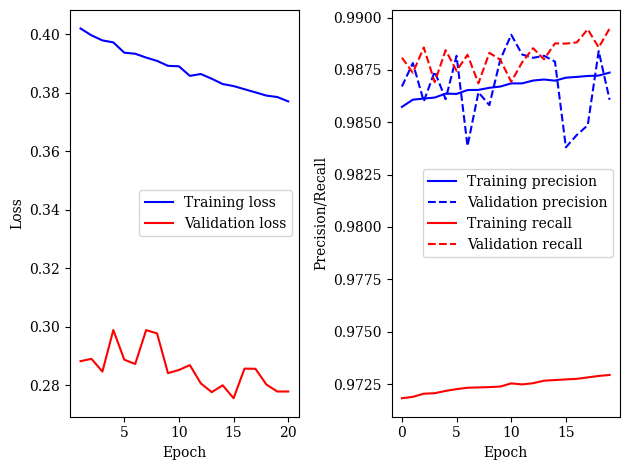

In [251]:
modal.plot_results(maxnorm_res_5)

### With log mag as feature, increased model params again

In [252]:
Xlog, ylog, _, __ = generate_dat_extended(32*2000, 200, multiclass=True, normalise=None, neg_an=True, logmag=True)
Xlogval, ylogval, _, __ = generate_dat_extended(32*250, 200, multiclass=True, normalise=None, neg_an=True, logmag=True)

In [254]:
maxnorm_model_6 = BiLSTM2(input_size=5, hidden_size=100, num_layers=3, num_classes=3)
maxnorm_res_6 = train_model_multiclass(maxnorm_model_6, Xlog, ylog, Xlogval, ylogval, name='norm_95_max(11.02)', num_epochs=30, batch_size=128, weights=weights_2)

  3%|▎         | 1/30 [07:31<3:38:08, 451.34s/it]

Epoch [1/30], Loss: 0.7865322203636169, Precision: 0.9335258847430378, Recall: 0.9221094582442061
Val Loss: 0.5947093276977539, Validation Precision: 0.9644604964338617, Validation Recall: 0.9537341321468212


  7%|▋         | 2/30 [15:16<3:34:19, 459.27s/it]

Epoch [2/30], Loss: 0.6403220146894455, Precision: 0.9602924455743788, Recall: 0.9521839593735832
Val Loss: 0.4974972238540649, Validation Precision: 0.9677477924127044, Validation Recall: 0.9703888850805419


 10%|█         | 3/30 [22:52<3:25:59, 457.74s/it]

Epoch [3/30], Loss: 0.5796424707174301, Precision: 0.9682386549824789, Recall: 0.9592016639695312
Val Loss: 0.45174286055564883, Validation Precision: 0.9594544234737719, Validation Recall: 0.9796283453252265


 13%|█▎        | 4/30 [30:34<3:19:05, 459.43s/it]

Epoch [4/30], Loss: 0.5363318848609925, Precision: 0.9728171828075477, Recall: 0.9628014725856483
Val Loss: 0.41106240916252135, Validation Precision: 0.9729540110873719, Validation Recall: 0.9801579716103406


 17%|█▋        | 5/30 [38:09<3:10:50, 458.03s/it]

Epoch [5/30], Loss: 0.50888289052248, Precision: 0.9759444739059606, Recall: 0.9648016160524456
Val Loss: 0.3931108820438385, Validation Precision: 0.9723179153463596, Validation Recall: 0.9814149933283111


 20%|██        | 6/30 [45:52<3:03:55, 459.80s/it]

Epoch [6/30], Loss: 0.49204345369338987, Precision: 0.977755209161612, Recall: 0.9660511765088784
Val Loss: 0.39455120253562925, Validation Precision: 0.9813374289192486, Validation Recall: 0.9782622640825157


 23%|██▎       | 7/30 [53:27<2:55:37, 458.17s/it]

Epoch [7/30], Loss: 0.4769272715449333, Precision: 0.9790995778595513, Recall: 0.9671350120823468
Val Loss: 0.3680902955532074, Validation Precision: 0.9746813546430961, Validation Recall: 0.9839302908254608


 27%|██▋       | 8/30 [1:01:00<2:47:19, 456.35s/it]

Epoch [8/30], Loss: 0.4642470262646675, Precision: 0.9806832174022176, Recall: 0.9680889392286387
Val Loss: 0.3549985041618347, Validation Precision: 0.9833252611540476, Validation Recall: 0.9825420391735066


 30%|███       | 9/30 [1:08:30<2:39:05, 454.56s/it]

Epoch [9/30], Loss: 0.4561833161711693, Precision: 0.9812371552136184, Recall: 0.9686441187991047
Val Loss: 0.3387884209156036, Validation Precision: 0.985927525502306, Validation Recall: 0.9829884534952437


 33%|███▎      | 10/30 [1:16:02<2:31:11, 453.57s/it]

Epoch [10/30], Loss: 0.44602149522304535, Precision: 0.9821422270539583, Recall: 0.9692524885251382
Val Loss: 0.34561673665046694, Validation Precision: 0.9796119598582917, Validation Recall: 0.9858024822864629


 37%|███▋      | 11/30 [1:23:36<2:23:43, 453.86s/it]

Epoch [11/30], Loss: 0.4408214243650436, Precision: 0.9828779408522818, Recall: 0.9695072357006874
Val Loss: 0.3301010186672211, Validation Precision: 0.9826344141858567, Validation Recall: 0.986090420856382


 40%|████      | 12/30 [1:31:10<2:16:09, 453.84s/it]

Epoch [12/30], Loss: 0.43400952219963074, Precision: 0.9835077203684798, Recall: 0.970097087543118
Val Loss: 0.3250035905838013, Validation Precision: 0.9809390600340618, Validation Recall: 0.9863171744938151


 43%|████▎     | 13/30 [1:38:42<2:08:27, 453.38s/it]

Epoch [13/30], Loss: 0.42826510506868365, Precision: 0.9840364410521746, Recall: 0.9703172671711773
Val Loss: 0.3267232322692871, Validation Precision: 0.9855239936113699, Validation Recall: 0.9838761872660763


 47%|████▋     | 14/30 [1:46:14<2:00:43, 452.75s/it]

Epoch [14/30], Loss: 0.4256969393491745, Precision: 0.9844100654624353, Recall: 0.9704688588147304
Val Loss: 0.33044790172576904, Validation Precision: 0.9847766103246706, Validation Recall: 0.984994300128521


 50%|█████     | 15/30 [1:53:46<1:53:09, 452.61s/it]

Epoch [15/30], Loss: 0.4197621403336525, Precision: 0.9846150305137713, Recall: 0.9707146147204438
Val Loss: 0.31552642345428467, Validation Precision: 0.9818961915339688, Validation Recall: 0.9875363305677507


 53%|█████▎    | 16/30 [2:01:17<1:45:31, 452.26s/it]

Epoch [16/30], Loss: 0.4151324353218079, Precision: 0.9851474803843477, Recall: 0.9709352892253899
Val Loss: 0.3116700978279114, Validation Precision: 0.9848492624549152, Validation Recall: 0.9862446374337459


 57%|█████▋    | 17/30 [2:08:50<1:37:59, 452.28s/it]

Epoch [17/30], Loss: 0.41174590557813645, Precision: 0.9852991696677107, Recall: 0.9710468928686503
Val Loss: 0.31131655526161195, Validation Precision: 0.9844795275315911, Validation Recall: 0.9867181058676086


 60%|██████    | 18/30 [2:16:21<1:30:25, 452.12s/it]

Epoch [18/30], Loss: 0.40868540078401566, Precision: 0.9853942915324547, Recall: 0.9711884220300437
Val Loss: 0.3033127562999725, Validation Precision: 0.9823556560311043, Validation Recall: 0.9880185694198419


 63%|██████▎   | 19/30 [2:23:52<1:22:48, 451.67s/it]

Epoch [19/30], Loss: 0.40448077881336214, Precision: 0.9856334718425406, Recall: 0.9713596948612998
Val Loss: 0.3047028942108154, Validation Precision: 0.9852175904960851, Validation Recall: 0.9873376614760022


 67%|██████▋   | 20/30 [2:31:25<1:15:20, 452.08s/it]

Epoch [20/30], Loss: 0.40173527818918225, Precision: 0.9858252438221046, Recall: 0.9716555142721355
Val Loss: 0.30087326979637147, Validation Precision: 0.9833861739201436, Validation Recall: 0.9880794659453175


 70%|███████   | 21/30 [2:38:59<1:07:53, 452.58s/it]

Epoch [21/30], Loss: 0.3971670261025429, Precision: 0.9861817820926663, Recall: 0.9717343097092127
Val Loss: 0.29876806497573855, Validation Precision: 0.9882272037328533, Validation Recall: 0.9867950120944978


 73%|███████▎  | 22/30 [2:46:33<1:00:24, 453.11s/it]

Epoch [22/30], Loss: 0.3940030692815781, Precision: 0.98638683681356, Recall: 0.9718211479728225
Val Loss: 0.2956378171443939, Validation Precision: 0.9836480593892638, Validation Recall: 0.988799448834723


 77%|███████▋  | 23/30 [2:54:08<52:55, 453.63s/it]  

Epoch [23/30], Loss: 0.39074611037969587, Precision: 0.986484329974999, Recall: 0.9720123826460622
Val Loss: 0.2911770396232605, Validation Precision: 0.9868813923641006, Validation Recall: 0.9881896735732859


 80%|████████  | 24/30 [3:01:43<45:24, 454.04s/it]

Epoch [24/30], Loss: 0.389431099653244, Precision: 0.9867213434836936, Recall: 0.9719712791203153
Val Loss: 0.29130633497238156, Validation Precision: 0.9866037103176242, Validation Recall: 0.9877320541111526


 83%|████████▎ | 25/30 [3:09:17<37:49, 453.93s/it]

Epoch [25/30], Loss: 0.38561452412605285, Precision: 0.9866460169719898, Recall: 0.9722776649008171
Val Loss: 0.2946736009120941, Validation Precision: 0.9870424580355587, Validation Recall: 0.9880548962509482


 87%|████████▋ | 26/30 [3:16:50<30:15, 453.89s/it]

Epoch [26/30], Loss: 0.3823565804362297, Precision: 0.9868696369949576, Recall: 0.9722598495462362
Val Loss: 0.2972495765686035, Validation Precision: 0.9879536687948377, Validation Recall: 0.9873306015867568


 90%|█████████ | 27/30 [3:24:26<22:43, 454.40s/it]

Epoch [27/30], Loss: 0.3799142612814903, Precision: 0.9868807290434787, Recall: 0.9724578642142323
Val Loss: 0.2876765925884247, Validation Precision: 0.985347690259567, Validation Recall: 0.989227257284835


 93%|█████████▎| 28/30 [3:32:01<15:09, 454.68s/it]

Epoch [28/30], Loss: 0.3757368165850639, Precision: 0.9870817195880714, Recall: 0.9725316467440299
Val Loss: 0.2945013246536255, Validation Precision: 0.9879791370970005, Validation Recall: 0.9878572830160455


 97%|█████████▋| 29/30 [3:39:39<07:35, 455.55s/it]

Epoch [29/30], Loss: 0.37441606998443605, Precision: 0.9870440384257283, Recall: 0.9724486213637897
Val Loss: 0.2953127646446228, Validation Precision: 0.9885988776474245, Validation Recall: 0.9873758920399612


100%|██████████| 30/30 [3:47:15<00:00, 454.51s/it]

Epoch [30/30], Loss: 0.37254478281736375, Precision: 0.9870427870918489, Recall: 0.9725650141728035
Val Loss: 0.2958346881866455, Validation Precision: 0.9871407178110909, Validation Recall: 0.9876959751067161


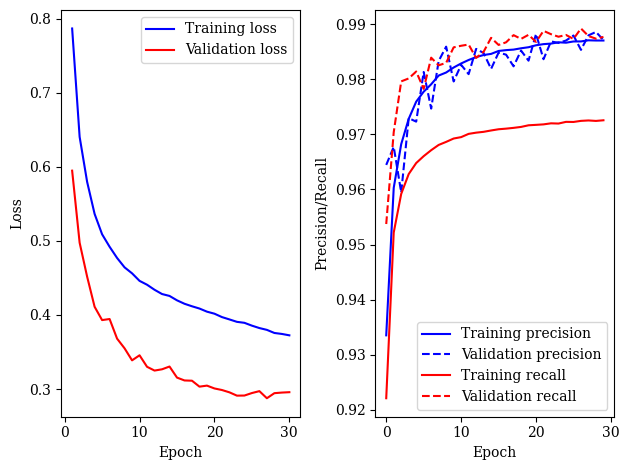

In [255]:
modal.plot_results(maxnorm_res_6)

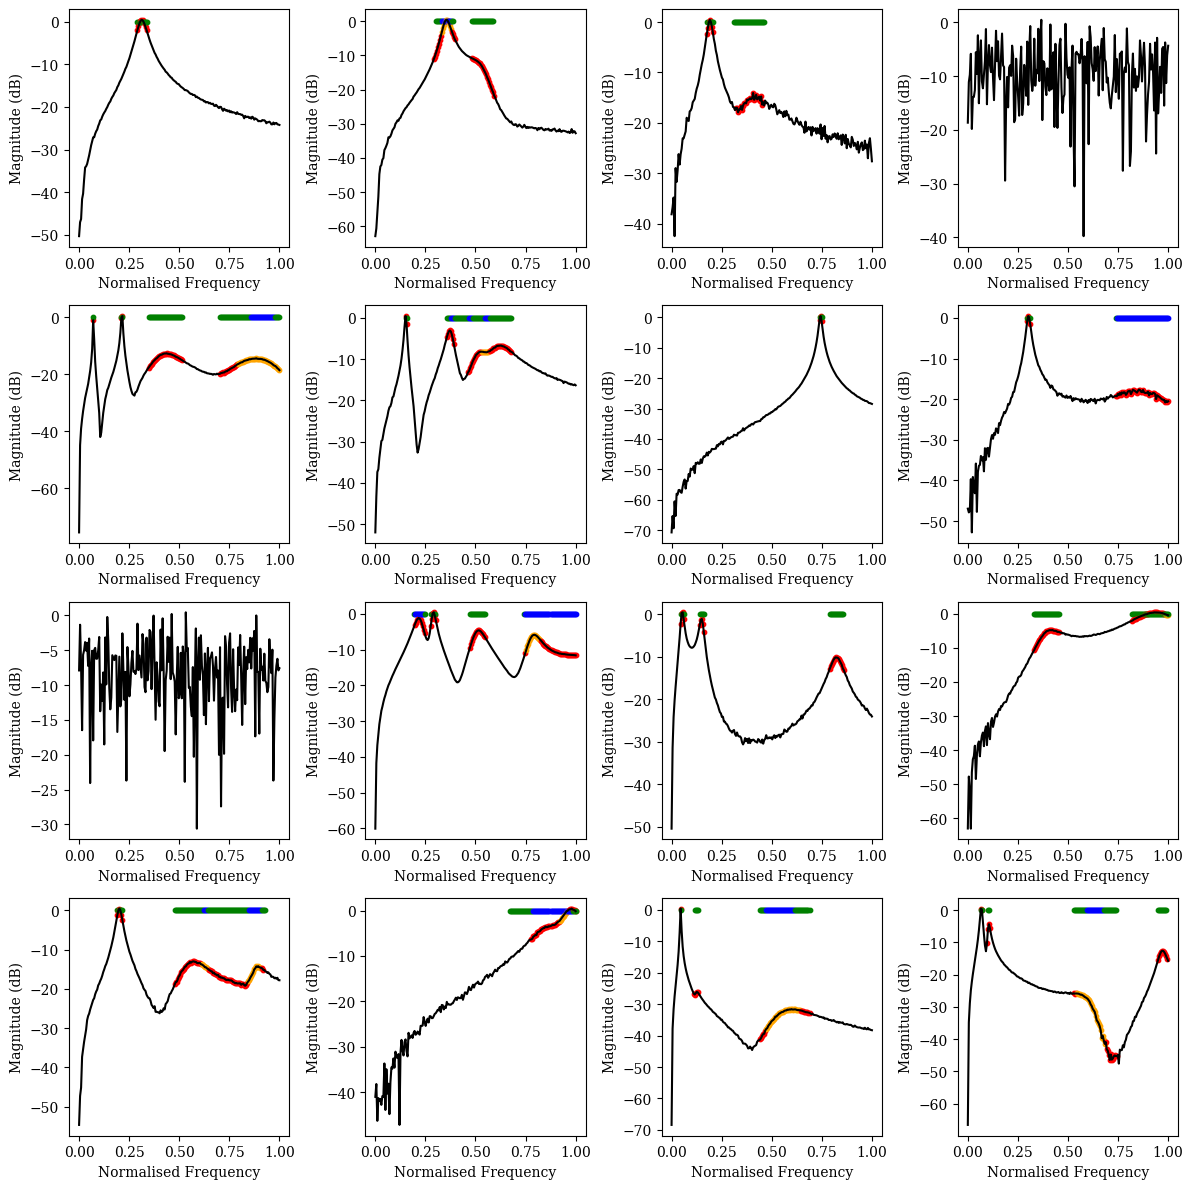

In [258]:
plot_predictions_extended(maxnorm_model_6, num_w_points=200, normalise=None, neg_an=True, multiclass=True, nrows=4, ncols=4, s=10, logmag=True)

## 15/02

### Train with logmag but now scaled to zero mean and unit variance (also using default weights), add back dropout

In [266]:
Xlog2, ylog2, _, __ = generate_dat_extended(32*2000, 200, multiclass=True, normalise=None, neg_an=True, logmag=True, scaled_logmag=True)
Xlogval2, ylogval2, _, __ = generate_dat_extended(32*250, 200, multiclass=True, normalise=None, neg_an=True, logmag=True, scaled_logmag=True)

In [268]:
maxnorm_model_7 = BiLSTM(input_size=5, hidden_size=100, num_layers=3, num_classes=3)
maxnorm_res_7 = train_model_multiclass(maxnorm_model_7, Xlog2, ylog2, Xlogval2, ylogval2, name='norm_95_max(15.02)', num_epochs=30, batch_size=128)

  3%|▎         | 1/30 [08:17<4:00:34, 497.76s/it]

Epoch [1/30], Loss: 0.7754574593305588, Precision: 0.8956733959701185, Recall: 0.9388812964148625
Val Loss: 0.6180760803222656, Validation Precision: 0.9529173171079299, Validation Recall: 0.9536798401236881


  7%|▋         | 2/30 [16:36<3:52:37, 498.49s/it]

Epoch [2/30], Loss: 0.6471445652246475, Precision: 0.9428296724018457, Recall: 0.9572439552996336
Val Loss: 0.5094512434005737, Validation Precision: 0.9494418122970986, Validation Recall: 0.9757644173676435


 10%|█         | 3/30 [24:53<3:43:56, 497.66s/it]

Epoch [3/30], Loss: 0.5898668587207794, Precision: 0.9554548490391561, Recall: 0.9621815531154405
Val Loss: 0.46177646732330324, Validation Precision: 0.9701725214116513, Validation Recall: 0.976986493839125


 13%|█▎        | 4/30 [32:58<3:33:29, 492.66s/it]

Epoch [4/30], Loss: 0.5558910649418831, Precision: 0.9611562538543506, Recall: 0.9647192186782938
Val Loss: 0.4363630151748657, Validation Precision: 0.9628189621777327, Validation Recall: 0.9822424976631456


 17%|█▋        | 5/30 [41:19<3:26:34, 495.79s/it]

Epoch [5/30], Loss: 0.5358005111813545, Precision: 0.9648580353096973, Recall: 0.965833983674404
Val Loss: 0.4232642095088959, Validation Precision: 0.9771253096033422, Validation Recall: 0.9769638333339438


 20%|██        | 6/30 [49:38<3:18:45, 496.90s/it]

Epoch [6/30], Loss: 0.517255342066288, Precision: 0.9674750044085852, Recall: 0.9669825868122293
Val Loss: 0.3890522985458374, Validation Precision: 0.9707896181024948, Validation Recall: 0.9839447314855507


 23%|██▎       | 7/30 [57:59<3:11:00, 498.27s/it]

Epoch [7/30], Loss: 0.506107042491436, Precision: 0.9692264975774239, Recall: 0.9674554310882236
Val Loss: 0.3941104962825775, Validation Precision: 0.9657001445432039, Validation Recall: 0.9848663772815003


 27%|██▋       | 8/30 [1:06:09<3:01:40, 495.47s/it]

Epoch [8/30], Loss: 0.49295975321531293, Precision: 0.9710203557536534, Recall: 0.9682811775109735
Val Loss: 0.37880023145675656, Validation Precision: 0.9739230705617148, Validation Recall: 0.9847773084198915


 30%|███       | 9/30 [1:14:22<2:53:07, 494.64s/it]

Epoch [9/30], Loss: 0.4858745789527893, Precision: 0.9721661881081327, Recall: 0.9687032886479544
Val Loss: 0.3653021409511566, Validation Precision: 0.972706392531015, Validation Recall: 0.9859258612372817


 33%|███▎      | 10/30 [1:22:46<2:45:52, 497.64s/it]

Epoch [10/30], Loss: 0.4765354824066162, Precision: 0.9734580809525221, Recall: 0.9690556280192154
Val Loss: 0.3814070348739624, Validation Precision: 0.972174605290255, Validation Recall: 0.9845858137819714


 37%|███▋      | 11/30 [1:31:13<2:38:28, 500.46s/it]

Epoch [11/30], Loss: 0.47122027003765105, Precision: 0.974059070996845, Recall: 0.9694507610152311
Val Loss: 0.35376875233650207, Validation Precision: 0.9784758951082587, Validation Recall: 0.9861375911633173


 40%|████      | 12/30 [1:39:42<2:30:53, 502.97s/it]

Epoch [12/30], Loss: 0.4651007113456726, Precision: 0.9749540643503315, Recall: 0.9697541609525162
Val Loss: 0.35898031973838807, Validation Precision: 0.9727783212684254, Validation Recall: 0.9864947563599317


 43%|████▎     | 13/30 [1:48:02<2:22:14, 502.05s/it]

Epoch [13/30], Loss: 0.4604085371494293, Precision: 0.9752041892239469, Recall: 0.9700043331546121
Val Loss: 0.35671018505096436, Validation Precision: 0.973707295944659, Validation Recall: 0.9868061086385467


 47%|████▋     | 14/30 [1:56:51<2:16:05, 510.34s/it]

Epoch [14/30], Loss: 0.45402136093378065, Precision: 0.9759870069289788, Recall: 0.970335036194062
Val Loss: 0.3386404240131378, Validation Precision: 0.9794672195312165, Validation Recall: 0.9870105840489133


 50%|█████     | 15/30 [2:05:34<2:08:33, 514.26s/it]

Epoch [15/30], Loss: 0.4511661568284035, Precision: 0.9765481125328233, Recall: 0.9705084837975412
Val Loss: 0.33870186972618105, Validation Precision: 0.9742486596392128, Validation Recall: 0.988130661001242


 53%|█████▎    | 16/30 [2:14:17<2:00:36, 516.86s/it]

Epoch [16/30], Loss: 0.4467919169068337, Precision: 0.9770782785743892, Recall: 0.9707202468998025
Val Loss: 0.3360342519283295, Validation Precision: 0.9804439109682012, Validation Recall: 0.9875091556915995


 57%|█████▋    | 17/30 [2:22:48<1:51:34, 514.94s/it]

Epoch [17/30], Loss: 0.4432183929085732, Precision: 0.9776064714940104, Recall: 0.9708474508832272
Val Loss: 0.33270316052436827, Validation Precision: 0.9766851458674983, Validation Recall: 0.9884221481933617


 60%|██████    | 18/30 [2:31:20<1:42:48, 514.07s/it]

Epoch [18/30], Loss: 0.43994012278318406, Precision: 0.9778087633579424, Recall: 0.9709994445811465
Val Loss: 0.33589097881317137, Validation Precision: 0.9800919304644872, Validation Recall: 0.9868740130310866


 63%|██████▎   | 19/30 [2:39:54<1:34:15, 514.17s/it]

Epoch [19/30], Loss: 0.4371986063122749, Precision: 0.9777732254175691, Recall: 0.9711292719164034
Val Loss: 0.32953586339950564, Validation Precision: 0.9818898939745426, Validation Recall: 0.9881509911147325


 67%|██████▋   | 20/30 [2:48:32<1:25:53, 515.39s/it]

Epoch [20/30], Loss: 0.4338566010594368, Precision: 0.9784731391503783, Recall: 0.9713165757762487
Val Loss: 0.3271948516368866, Validation Precision: 0.978573274223943, Validation Recall: 0.9882819132692728


 70%|███████   | 21/30 [2:57:07<1:17:15, 515.03s/it]

Epoch [21/30], Loss: 0.43106271970272064, Precision: 0.9784822069064694, Recall: 0.9714734248857955
Val Loss: 0.3238427641391754, Validation Precision: 0.9778344719543391, Validation Recall: 0.9887921574426701


 73%|███████▎  | 22/30 [3:05:35<1:08:23, 512.97s/it]

Epoch [22/30], Loss: 0.42883659100532534, Precision: 0.9786703365350806, Recall: 0.9714645237559978
Val Loss: 0.3263935215473175, Validation Precision: 0.9761449666314247, Validation Recall: 0.9892420893742824


 77%|███████▋  | 23/30 [3:14:06<59:47, 512.57s/it]  

Epoch [23/30], Loss: 0.4241322294473648, Precision: 0.9790419215973969, Recall: 0.9717097014259515
Val Loss: 0.3272571215629578, Validation Precision: 0.9815782488238824, Validation Recall: 0.9877269823401389


 80%|████████  | 24/30 [3:22:38<51:14, 512.37s/it]

Epoch [24/30], Loss: 0.4224569981098175, Precision: 0.9792444983300068, Recall: 0.9717766992064811
Val Loss: 0.3215700435638428, Validation Precision: 0.9812789852702959, Validation Recall: 0.9884101824688667


 83%|████████▎ | 25/30 [3:31:11<42:42, 512.54s/it]

Epoch [25/30], Loss: 0.4197030011415482, Precision: 0.9792782564141487, Recall: 0.9719066303651029
Val Loss: 0.31908232665061953, Validation Precision: 0.9824164508844732, Validation Recall: 0.9884914967232061


 87%|████████▋ | 26/30 [3:39:44<34:10, 512.70s/it]

Epoch [26/30], Loss: 0.4173756639957428, Precision: 0.9795844044291802, Recall: 0.9719551661838859
Val Loss: 0.3183097665309906, Validation Precision: 0.9739254577393534, Validation Recall: 0.9902564860654852


 90%|█████████ | 27/30 [3:48:18<25:39, 513.06s/it]

Epoch [27/30], Loss: 0.4163966355919838, Precision: 0.9795713821906996, Recall: 0.97186137679955
Val Loss: 0.32380549669265746, Validation Precision: 0.9762683887626336, Validation Recall: 0.9890010987401624


 93%|█████████▎| 28/30 [3:56:58<17:10, 515.11s/it]

Epoch [28/30], Loss: 0.4136465972661972, Precision: 0.9797482759608439, Recall: 0.9719860103160043
Val Loss: 0.3132639870643616, Validation Precision: 0.9813095256115834, Validation Recall: 0.9889976254491786


 97%|█████████▋| 29/30 [4:05:29<08:33, 513.78s/it]

Epoch [29/30], Loss: 0.41008470064401625, Precision: 0.9800927184195162, Recall: 0.9722690427109469
Val Loss: 0.32132109904289247, Validation Precision: 0.9819040734966067, Validation Recall: 0.9881927221297895


100%|██████████| 30/30 [4:13:57<00:00, 507.91s/it]

Epoch [30/30], Loss: 0.4087431616783142, Precision: 0.9801125814556149, Recall: 0.972273928119087
Val Loss: 0.31685921812057494, Validation Precision: 0.9864407494471111, Validation Recall: 0.986754508205404


In [274]:
weights = compute_class_weight(class_weight='balanced', classes=np.unique(ylog2), y=ylog2.reshape(-1))
print(weights / weights[0])

[ 1.          3.4801822  11.75024347]


In [276]:
a,b = np.unique(ylog2, return_counts=True)
print(1 / (b/b[0]))

[ 1.          3.4801822  11.75024347]


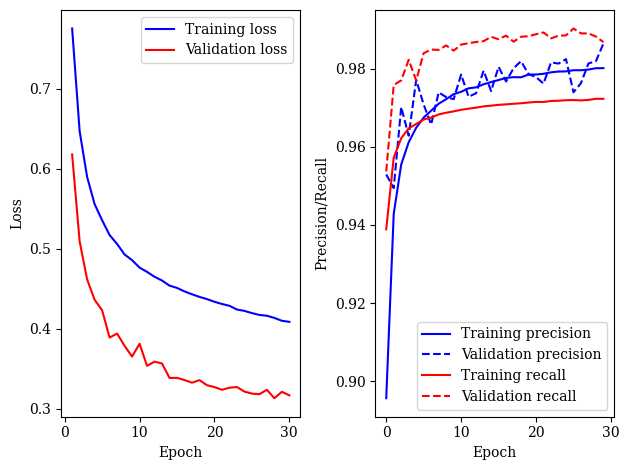

In [269]:
modal.plot_results(maxnorm_res_7)

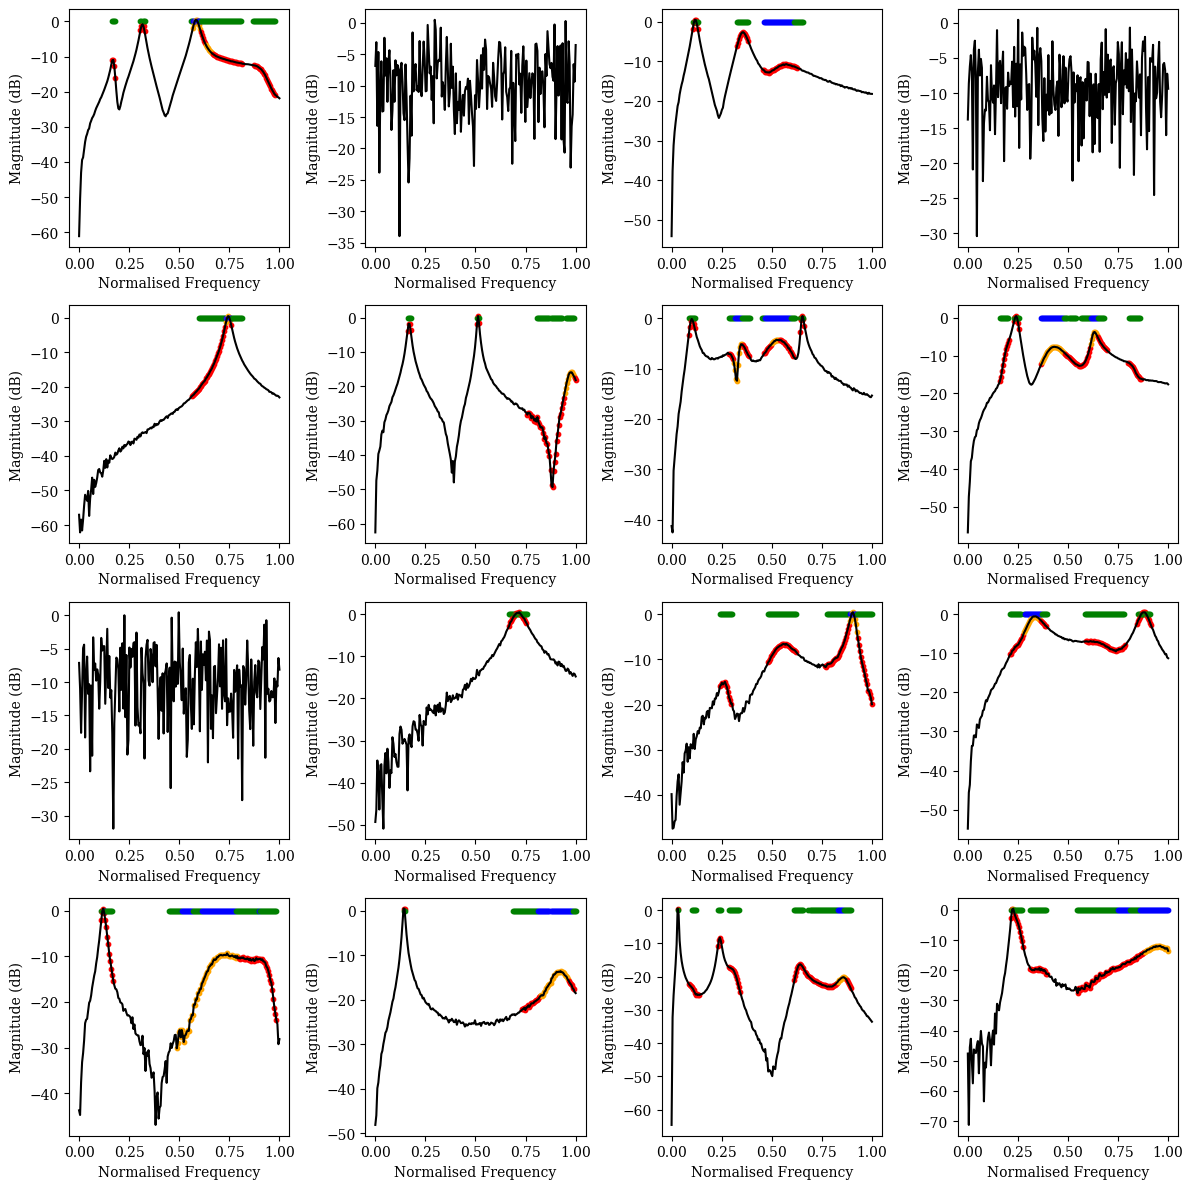

In [279]:
plot_predictions_extended(maxnorm_model_7, num_w_points=200, normalise=None, neg_an=True, multiclass=True, nrows=4, ncols=4, s=10, logmag=True, scaled_logmag=True)

In [282]:
maxnorm_res_7_2 = train_model_multiclass(maxnorm_model_7, Xlog2, ylog2, Xlogval2, ylogval2, name='norm_95_max(15.02)_50epochs', num_epochs=20, batch_size=128)

  5%|▌         | 1/20 [08:22<2:39:03, 502.31s/it]

Epoch [1/20], Loss: 0.40573370933532715, Precision: 0.9803068106169976, Recall: 0.9724034217362649
Val Loss: 0.3170873155593872, Validation Precision: 0.9804398029376054, Validation Recall: 0.9890717444346446


 10%|█         | 2/20 [16:41<2:30:04, 500.26s/it]

Epoch [2/20], Loss: 0.4049448925256729, Precision: 0.9802737244766019, Recall: 0.9723531979544379
Val Loss: 0.32799058175086976, Validation Precision: 0.9737553461858304, Validation Recall: 0.9903057813068895


 15%|█▌        | 3/20 [24:54<2:20:54, 497.30s/it]

Epoch [3/20], Loss: 0.4022336007356644, Precision: 0.9804525226741936, Recall: 0.9723958125043953
Val Loss: 0.31705942130088804, Validation Precision: 0.9745582074277174, Validation Recall: 0.9909102014840919


 20%|██        | 4/20 [33:12<2:12:38, 497.41s/it]

Epoch [4/20], Loss: 0.400836145222187, Precision: 0.9805639438478573, Recall: 0.9725149988753152
Val Loss: 0.32119314432144164, Validation Precision: 0.9809908417973134, Validation Recall: 0.98859408338396


 25%|██▌       | 5/20 [41:27<2:04:05, 496.37s/it]

Epoch [5/20], Loss: 0.3975333386063576, Precision: 0.9805902731168914, Recall: 0.972614862985577
Val Loss: 0.3212608790397644, Validation Precision: 0.9811185117712966, Validation Recall: 0.9883872106400952


 30%|███       | 6/20 [49:37<1:55:22, 494.44s/it]

Epoch [6/20], Loss: 0.3948567020893097, Precision: 0.9806999768516406, Recall: 0.9726305398013912
Val Loss: 0.31856321811676025, Validation Precision: 0.9808224003162589, Validation Recall: 0.9892133698860369


 35%|███▌      | 7/20 [57:45<1:46:41, 492.42s/it]

Epoch [7/20], Loss: 0.39246471083164214, Precision: 0.9807911291104722, Recall: 0.9728682864834121
Val Loss: 0.3179726095199585, Validation Precision: 0.983696549999025, Validation Recall: 0.9882638531001274


 40%|████      | 8/20 [1:05:54<1:38:13, 491.10s/it]

Epoch [8/20], Loss: 0.39189678233861924, Precision: 0.980754645356792, Recall: 0.9726133855795274
Val Loss: 0.31908862352371214, Validation Precision: 0.985772776971306, Validation Recall: 0.9876074204388497


 45%|████▌     | 9/20 [1:14:00<1:29:45, 489.63s/it]

Epoch [9/20], Loss: 0.3902403680086136, Precision: 0.9809869420689223, Recall: 0.9726996370645538
Val Loss: 0.31884330344200135, Validation Precision: 0.978341890952018, Validation Recall: 0.9902441351617298


 50%|█████     | 10/20 [1:22:11<1:21:41, 490.16s/it]

Epoch [10/20], Loss: 0.38643130415678023, Precision: 0.9809853534065847, Recall: 0.9728410520809098
Val Loss: 0.31549886631965635, Validation Precision: 0.9807599514476502, Validation Recall: 0.9896640739056705


 55%|█████▌    | 11/20 [1:30:22<1:13:33, 490.38s/it]

Epoch [11/20], Loss: 0.38380548149347304, Precision: 0.9811159995444066, Recall: 0.97295337045418
Val Loss: 0.3254135015010834, Validation Precision: 0.9816556734189197, Validation Recall: 0.9892140221604399


 60%|██████    | 12/20 [1:38:31<1:05:19, 489.89s/it]

Epoch [12/20], Loss: 0.38359221267700194, Precision: 0.9810737220765535, Recall: 0.972884237930341
Val Loss: 0.3210814220905304, Validation Precision: 0.9780521943549092, Validation Recall: 0.9902757676817608


 65%|██████▌   | 13/20 [1:46:40<57:07, 489.69s/it]  

Epoch [13/20], Loss: 0.380675547003746, Precision: 0.980968639897471, Recall: 0.9730196081972927
Val Loss: 0.3226723620891571, Validation Precision: 0.984541186693434, Validation Recall: 0.9886321892612908


 70%|███████   | 14/20 [1:54:55<49:07, 491.20s/it]

Epoch [14/20], Loss: 0.3789081502556801, Precision: 0.9811973613530147, Recall: 0.9729629079196294
Val Loss: 0.32235564398765565, Validation Precision: 0.9808082154204677, Validation Recall: 0.9898392531093501


 75%|███████▌  | 15/20 [2:03:11<41:02, 492.53s/it]

Epoch [15/20], Loss: 0.37750015157461164, Precision: 0.9810907904781905, Recall: 0.973051924210573
Val Loss: 0.3260666484832764, Validation Precision: 0.9812220351576443, Validation Recall: 0.9895634864061933


 80%|████████  | 16/20 [2:11:23<32:49, 492.32s/it]

Epoch [16/20], Loss: 0.3753874552845955, Precision: 0.9810060208542344, Recall: 0.973147013886552
Val Loss: 0.3175222849845886, Validation Precision: 0.9819970732387401, Validation Recall: 0.9893125953938372


 85%|████████▌ | 17/20 [2:19:36<24:37, 492.67s/it]

Epoch [17/20], Loss: 0.37231961023807525, Precision: 0.9812387014018961, Recall: 0.9731862818504832
Val Loss: 0.3226506819725037, Validation Precision: 0.9799151715149843, Validation Recall: 0.9898370891886017


 90%|█████████ | 18/20 [2:27:53<16:27, 493.92s/it]

Epoch [18/20], Loss: 0.37111689192056657, Precision: 0.9812408162229859, Recall: 0.9732872913442493
Val Loss: 0.3220140392780304, Validation Precision: 0.9792849921262374, Validation Recall: 0.9900746873123574


 95%|█████████▌| 19/20 [2:36:06<08:13, 493.75s/it]

Epoch [19/20], Loss: 0.3693534985780716, Precision: 0.9812988005952431, Recall: 0.9732037997993199
Val Loss: 0.3263869743347168, Validation Precision: 0.9820927852213498, Validation Recall: 0.9894396559106989


100%|██████████| 20/20 [2:44:17<00:00, 492.86s/it]

Epoch [20/20], Loss: 0.3681204081773758, Precision: 0.9812054678530969, Recall: 0.973306853992072
Val Loss: 0.3296906077861786, Validation Precision: 0.9834838899297146, Validation Recall: 0.9889009386764798


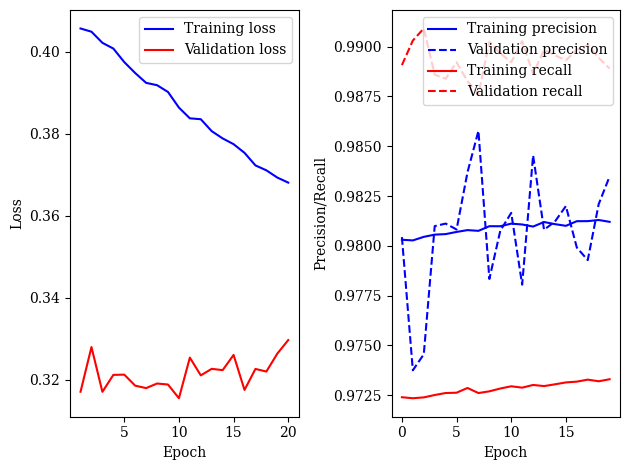

In [286]:
modal.plot_results(maxnorm_res_7_2)

### Trying with fewer model params

In [283]:
maxnorm_model_8 = BiLSTM(input_size=5, hidden_size=30, num_layers=2, num_classes=3)
maxnorm_res_8 = train_model_multiclass(maxnorm_model_8, Xlog2, ylog2, Xlogval2, ylogval2, name='norm_95_max(16.02)', num_epochs=50, batch_size=128)

  2%|▏         | 1/50 [02:07<1:44:24, 127.85s/it]

Epoch [1/50], Loss: 0.8010722138881683, Precision: 0.8814181043258704, Recall: 0.934882577022992
Val Loss: 0.6476568241119385, Validation Precision: 0.8840259887166353, Validation Recall: 0.9693171519951184


  4%|▍         | 2/50 [04:15<1:42:21, 127.95s/it]

Epoch [2/50], Loss: 0.7044893485307694, Precision: 0.9190294085507408, Recall: 0.9527460565001857
Val Loss: 0.6136347489356995, Validation Precision: 0.9435717261025764, Validation Recall: 0.960347637171949


  6%|▌         | 3/50 [06:23<1:40:16, 128.02s/it]

Epoch [3/50], Loss: 0.6814989405870437, Precision: 0.9305274120284543, Recall: 0.9542276985933771
Val Loss: 0.5787373762130738, Validation Precision: 0.9444488089138658, Validation Recall: 0.9672078082284805


  8%|▊         | 4/50 [08:32<1:38:15, 128.16s/it]

Epoch [4/50], Loss: 0.6604711961746216, Precision: 0.9375726839733828, Recall: 0.9565682753179465
Val Loss: 0.5574857196807861, Validation Precision: 0.9465078138671085, Validation Recall: 0.9693157967463971


 10%|█         | 5/50 [10:40<1:36:13, 128.29s/it]

Epoch [5/50], Loss: 0.6428951952457428, Precision: 0.9426815559747431, Recall: 0.9584237671994437
Val Loss: 0.5409100570678711, Validation Precision: 0.9568635523795215, Validation Recall: 0.9702422076663721


 12%|█▏        | 6/50 [12:49<1:34:07, 128.36s/it]

Epoch [6/50], Loss: 0.6298904062509537, Precision: 0.9464751983448141, Recall: 0.9596091800215563
Val Loss: 0.5323384718894959, Validation Precision: 0.94017929737935, Validation Recall: 0.9782553228813685


 14%|█▍        | 7/50 [14:57<1:32:00, 128.39s/it]

Epoch [7/50], Loss: 0.6171318317651748, Precision: 0.9499801708976994, Recall: 0.9608500526197945
Val Loss: 0.5218324608802796, Validation Precision: 0.9403291924093548, Validation Recall: 0.9781838354611276


 16%|█▌        | 8/50 [17:06<1:29:56, 128.50s/it]

Epoch [8/50], Loss: 0.6077566220760345, Precision: 0.9520430070689401, Recall: 0.9618501631555356
Val Loss: 0.49909139108657835, Validation Precision: 0.960295893954719, Validation Recall: 0.9758155950200936


 18%|█▊        | 9/50 [19:15<1:27:52, 128.59s/it]

Epoch [9/50], Loss: 0.5975048351287842, Precision: 0.9541245629535708, Recall: 0.9626983975881283
Val Loss: 0.4940054292678833, Validation Precision: 0.9678158966394429, Validation Recall: 0.9744764136457362


 20%|██        | 10/50 [21:24<1:25:48, 128.71s/it]

Epoch [10/50], Loss: 0.5888763952255249, Precision: 0.9553965040301787, Recall: 0.9633371617896874
Val Loss: 0.48043873262405395, Validation Precision: 0.9633621545928182, Validation Recall: 0.9778298776541998


 22%|██▏       | 11/50 [23:34<1:24:00, 129.24s/it]

Epoch [11/50], Loss: 0.5813069742918014, Precision: 0.9564664349173057, Recall: 0.9638030193319853
Val Loss: 0.46737807464599607, Validation Precision: 0.9623223497519096, Validation Recall: 0.9798655047327736


 24%|██▍       | 12/50 [25:45<1:22:09, 129.71s/it]

Epoch [12/50], Loss: 0.5738051734566688, Precision: 0.9576179376166484, Recall: 0.9643768915650636
Val Loss: 0.4627609996795654, Validation Precision: 0.9572255372052318, Validation Recall: 0.9823034534476748


 26%|██▌       | 13/50 [27:56<1:20:11, 130.03s/it]

Epoch [13/50], Loss: 0.5672203674316406, Precision: 0.9583861093009172, Recall: 0.9646358138034671
Val Loss: 0.4662380895614624, Validation Precision: 0.9569780753294461, Validation Recall: 0.9808512021300364


 28%|██▊       | 14/50 [30:06<1:18:04, 130.13s/it]

Epoch [14/50], Loss: 0.5616267958879471, Precision: 0.9596053081508794, Recall: 0.965186195170668
Val Loss: 0.45215648698806765, Validation Precision: 0.9659754581813952, Validation Recall: 0.9800912797056551


 30%|███       | 15/50 [32:16<1:15:51, 130.06s/it]

Epoch [15/50], Loss: 0.5573920323848724, Precision: 0.9603015826369353, Recall: 0.9653210255894588
Val Loss: 0.4442883994579315, Validation Precision: 0.9683126983375272, Validation Recall: 0.9799278320830938


 32%|███▏      | 16/50 [34:26<1:13:38, 129.94s/it]

Epoch [16/50], Loss: 0.5514571099877358, Precision: 0.9611836642379044, Recall: 0.9657066984046442
Val Loss: 0.4362459256649017, Validation Precision: 0.9620433263841333, Validation Recall: 0.9828367428892132


 34%|███▍      | 17/50 [36:35<1:11:21, 129.75s/it]

Epoch [17/50], Loss: 0.5462506255507469, Precision: 0.9619196822328259, Recall: 0.9660250505307335
Val Loss: 0.4374651882648468, Validation Precision: 0.9610092025171028, Validation Recall: 0.9830083649667603


 36%|███▌      | 18/50 [38:45<1:09:09, 129.67s/it]

Epoch [18/50], Loss: 0.5429513809084893, Precision: 0.9623539029738247, Recall: 0.9661410141971435
Val Loss: 0.43410331511497496, Validation Precision: 0.9618096709633809, Validation Recall: 0.98312881168943


 38%|███▊      | 19/50 [40:54<1:06:55, 129.52s/it]

Epoch [19/50], Loss: 0.5387102884054183, Precision: 0.9634689904290572, Recall: 0.9665011076378758
Val Loss: 0.42653848028182983, Validation Precision: 0.9626163493012792, Validation Recall: 0.9840639230510283


 40%|████      | 20/50 [43:03<1:04:45, 129.50s/it]

Epoch [20/50], Loss: 0.5333675358295441, Precision: 0.9639761684197045, Recall: 0.966603908396075
Val Loss: 0.420544935464859, Validation Precision: 0.9592602961831062, Validation Recall: 0.9848425528220324


 42%|████▏     | 21/50 [45:12<1:02:31, 129.38s/it]

Epoch [21/50], Loss: 0.5305668968558311, Precision: 0.9645040331840647, Recall: 0.9668024835802965
Val Loss: 0.42247682332992553, Validation Precision: 0.9664299828232565, Validation Recall: 0.9821975294584742


 44%|████▍     | 22/50 [47:21<1:00:18, 129.24s/it]

Epoch [22/50], Loss: 0.5278288305401803, Precision: 0.9652760143178422, Recall: 0.9668706982906249
Val Loss: 0.4121561286449432, Validation Precision: 0.9694752618741312, Validation Recall: 0.9829736008721935


 46%|████▌     | 23/50 [49:31<58:11, 129.31s/it]  

Epoch [23/50], Loss: 0.5232371081709861, Precision: 0.9656232479423807, Recall: 0.9671823237213193
Val Loss: 0.4069458644390106, Validation Precision: 0.9660827805843966, Validation Recall: 0.9844169092662317


 48%|████▊     | 24/50 [51:40<56:02, 129.31s/it]

Epoch [24/50], Loss: 0.5210092446208, Precision: 0.9659288474176493, Recall: 0.9672904886210472
Val Loss: 0.4072926433086395, Validation Precision: 0.9683277086883252, Validation Recall: 0.9839133346409765


 50%|█████     | 25/50 [53:49<53:50, 129.24s/it]

Epoch [25/50], Loss: 0.5213458624482155, Precision: 0.9659275351742292, Recall: 0.9673077531300955
Val Loss: 0.40311441040039064, Validation Precision: 0.9642106598992831, Validation Recall: 0.985084535837721


 52%|█████▏    | 26/50 [55:58<51:43, 129.30s/it]

Epoch [26/50], Loss: 0.5160710481405258, Precision: 0.966879134966413, Recall: 0.9676378068092982
Val Loss: 0.40323434853553775, Validation Precision: 0.9755925161626164, Validation Recall: 0.9818885814235957


 54%|█████▍    | 27/50 [58:09<49:39, 129.55s/it]

Epoch [27/50], Loss: 0.5142908790111542, Precision: 0.967246745982863, Recall: 0.9677032939225515
Val Loss: 0.39829899263381957, Validation Precision: 0.9719809679436302, Validation Recall: 0.9835887818022216


 56%|█████▌    | 28/50 [1:00:20<47:43, 130.17s/it]

Epoch [28/50], Loss: 0.5120999234914779, Precision: 0.9677165968361457, Recall: 0.9677819029326398
Val Loss: 0.39751522994041444, Validation Precision: 0.9630511421200841, Validation Recall: 0.9863356029518042


 58%|█████▊    | 29/50 [1:02:33<45:47, 130.82s/it]

Epoch [29/50], Loss: 0.5104494495391846, Precision: 0.9677376887920139, Recall: 0.9679193548627641
Val Loss: 0.3950684123039246, Validation Precision: 0.9750560921801448, Validation Recall: 0.9825798137924697


 60%|██████    | 30/50 [1:04:44<43:40, 131.04s/it]

Epoch [30/50], Loss: 0.5077635608911514, Precision: 0.9681023362327242, Recall: 0.9680218660660415
Val Loss: 0.39768378138542176, Validation Precision: 0.9782398795777175, Validation Recall: 0.9814322476067321


 62%|██████▏   | 31/50 [1:06:55<41:31, 131.12s/it]

Epoch [31/50], Loss: 0.5069627595543862, Precision: 0.9683728269469976, Recall: 0.9680222535768079
Val Loss: 0.3888797357082367, Validation Precision: 0.9664567894683496, Validation Recall: 0.9861152959834666


 64%|██████▍   | 32/50 [1:09:06<39:19, 131.08s/it]

Epoch [32/50], Loss: 0.5039066923856735, Precision: 0.9688957660811114, Recall: 0.9682018901084014
Val Loss: 0.38905001044273374, Validation Precision: 0.9719648647546024, Validation Recall: 0.9843345700412715


 66%|██████▌   | 33/50 [1:11:17<37:07, 131.05s/it]

Epoch [33/50], Loss: 0.5035166299343109, Precision: 0.9687648856159033, Recall: 0.9682340988667264
Val Loss: 0.39682689809799193, Validation Precision: 0.9677653785992819, Validation Recall: 0.9847947285081464


 68%|██████▊   | 34/50 [1:13:28<34:56, 131.00s/it]

Epoch [34/50], Loss: 0.5016713791489601, Precision: 0.969021813567552, Recall: 0.9683235240153143
Val Loss: 0.388458646774292, Validation Precision: 0.9675795640076245, Validation Recall: 0.9858867781021188


 70%|███████   | 35/50 [1:15:39<32:42, 130.86s/it]

Epoch [35/50], Loss: 0.500714504301548, Precision: 0.9693793316529464, Recall: 0.9683181208149437
Val Loss: 0.38706179666519164, Validation Precision: 0.974880873548739, Validation Recall: 0.9838487731337486


 72%|███████▏  | 36/50 [1:17:50<30:32, 130.90s/it]

Epoch [36/50], Loss: 0.49870786899328234, Precision: 0.9697688826154345, Recall: 0.9684675086714851
Val Loss: 0.3870935318470001, Validation Precision: 0.9782875037393611, Validation Recall: 0.9823747168403857


 74%|███████▍  | 37/50 [1:20:02<28:26, 131.30s/it]

Epoch [37/50], Loss: 0.4971680532693863, Precision: 0.969754170516313, Recall: 0.9684898741339901
Val Loss: 0.381426605463028, Validation Precision: 0.97162074393079, Validation Recall: 0.9853537246715949


 76%|███████▌  | 38/50 [1:22:15<26:20, 131.74s/it]

Epoch [38/50], Loss: 0.4963770233988762, Precision: 0.9699414959675107, Recall: 0.9685316900769053
Val Loss: 0.3836052305698395, Validation Precision: 0.9733127602663368, Validation Recall: 0.9845410640484755


 78%|███████▊  | 39/50 [1:24:27<24:10, 131.88s/it]

Epoch [39/50], Loss: 0.4948191131949425, Precision: 0.9703801541615612, Recall: 0.9686264423560932
Val Loss: 0.38134095215797426, Validation Precision: 0.9801128712435294, Validation Recall: 0.9823901950011591


 80%|████████  | 40/50 [1:26:39<21:58, 131.81s/it]

Epoch [40/50], Loss: 0.4931308385133743, Precision: 0.9704518592317882, Recall: 0.9687237184326625
Val Loss: 0.37721444272995, Validation Precision: 0.9714577438637572, Validation Recall: 0.9859360693411446


 82%|████████▏ | 41/50 [1:28:50<19:45, 131.71s/it]

Epoch [41/50], Loss: 0.4925038997530937, Precision: 0.9705477026440854, Recall: 0.9686671575107066
Val Loss: 0.37563394808769224, Validation Precision: 0.9751579588050108, Validation Recall: 0.9850103124376566


 84%|████████▍ | 42/50 [1:30:59<17:27, 130.93s/it]

Epoch [42/50], Loss: 0.4908838081359863, Precision: 0.9708450986214168, Recall: 0.9688547496573562
Val Loss: 0.3781066279411316, Validation Precision: 0.9742123406431551, Validation Recall: 0.9846598880012025


 86%|████████▌ | 43/50 [1:33:07<15:10, 130.04s/it]

Epoch [43/50], Loss: 0.4902254187464714, Precision: 0.9711156502937169, Recall: 0.9688366069813125
Val Loss: 0.3748516356945038, Validation Precision: 0.9735320603421438, Validation Recall: 0.9853193878683616


 88%|████████▊ | 44/50 [1:35:15<12:56, 129.45s/it]

Epoch [44/50], Loss: 0.4890615351200104, Precision: 0.9713144514857992, Recall: 0.9689089878803183
Val Loss: 0.3759723317623138, Validation Precision: 0.979122882849722, Validation Recall: 0.9834489038261843


 90%|█████████ | 45/50 [1:37:23<10:44, 128.99s/it]

Epoch [45/50], Loss: 0.48722780895233153, Precision: 0.971360289491376, Recall: 0.9689577626006244
Val Loss: 0.37738433957099915, Validation Precision: 0.9776266962210709, Validation Recall: 0.9836921050058576


 92%|█████████▏| 46/50 [1:39:31<08:34, 128.67s/it]

Epoch [46/50], Loss: 0.4860000215172768, Precision: 0.9714033372112979, Recall: 0.9690606928365848
Val Loss: 0.37012546277046204, Validation Precision: 0.9665651912061695, Validation Recall: 0.9880343482950494


 94%|█████████▍| 47/50 [1:41:39<06:25, 128.52s/it]

Epoch [47/50], Loss: 0.4847829231619835, Precision: 0.9714547363256913, Recall: 0.9690874326687299
Val Loss: 0.3743915441036224, Validation Precision: 0.9782123172408079, Validation Recall: 0.983894750906206


 96%|█████████▌| 48/50 [1:43:49<04:17, 128.78s/it]

Epoch [48/50], Loss: 0.4833645272254944, Precision: 0.9718426724437624, Recall: 0.969240232712503
Val Loss: 0.3732183723449707, Validation Precision: 0.9756038429735256, Validation Recall: 0.9848800742206405


 98%|█████████▊| 49/50 [1:45:59<02:09, 129.25s/it]

Epoch [49/50], Loss: 0.48301588821411134, Precision: 0.9718313187869986, Recall: 0.9693100237158218
Val Loss: 0.3656663489341736, Validation Precision: 0.9749492686679649, Validation Recall: 0.9860330638865585


100%|██████████| 50/50 [1:48:08<00:00, 129.78s/it]

Epoch [50/50], Loss: 0.48168234586715697, Precision: 0.972098897406043, Recall: 0.9694062528650211
Val Loss: 0.3685296368598938, Validation Precision: 0.9717840031562923, Validation Recall: 0.9866637667765019


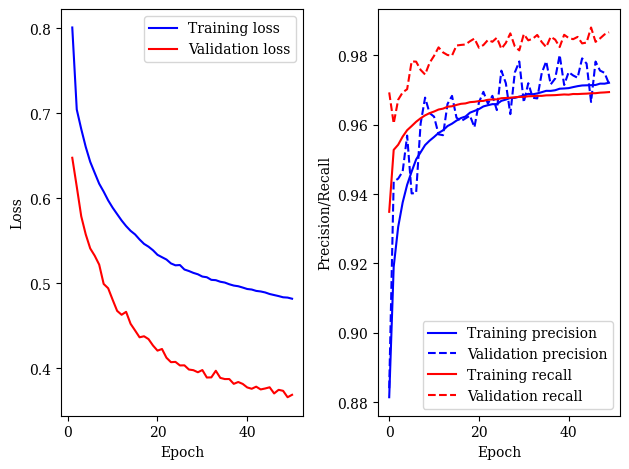

In [288]:
modal.plot_results(maxnorm_res_8)

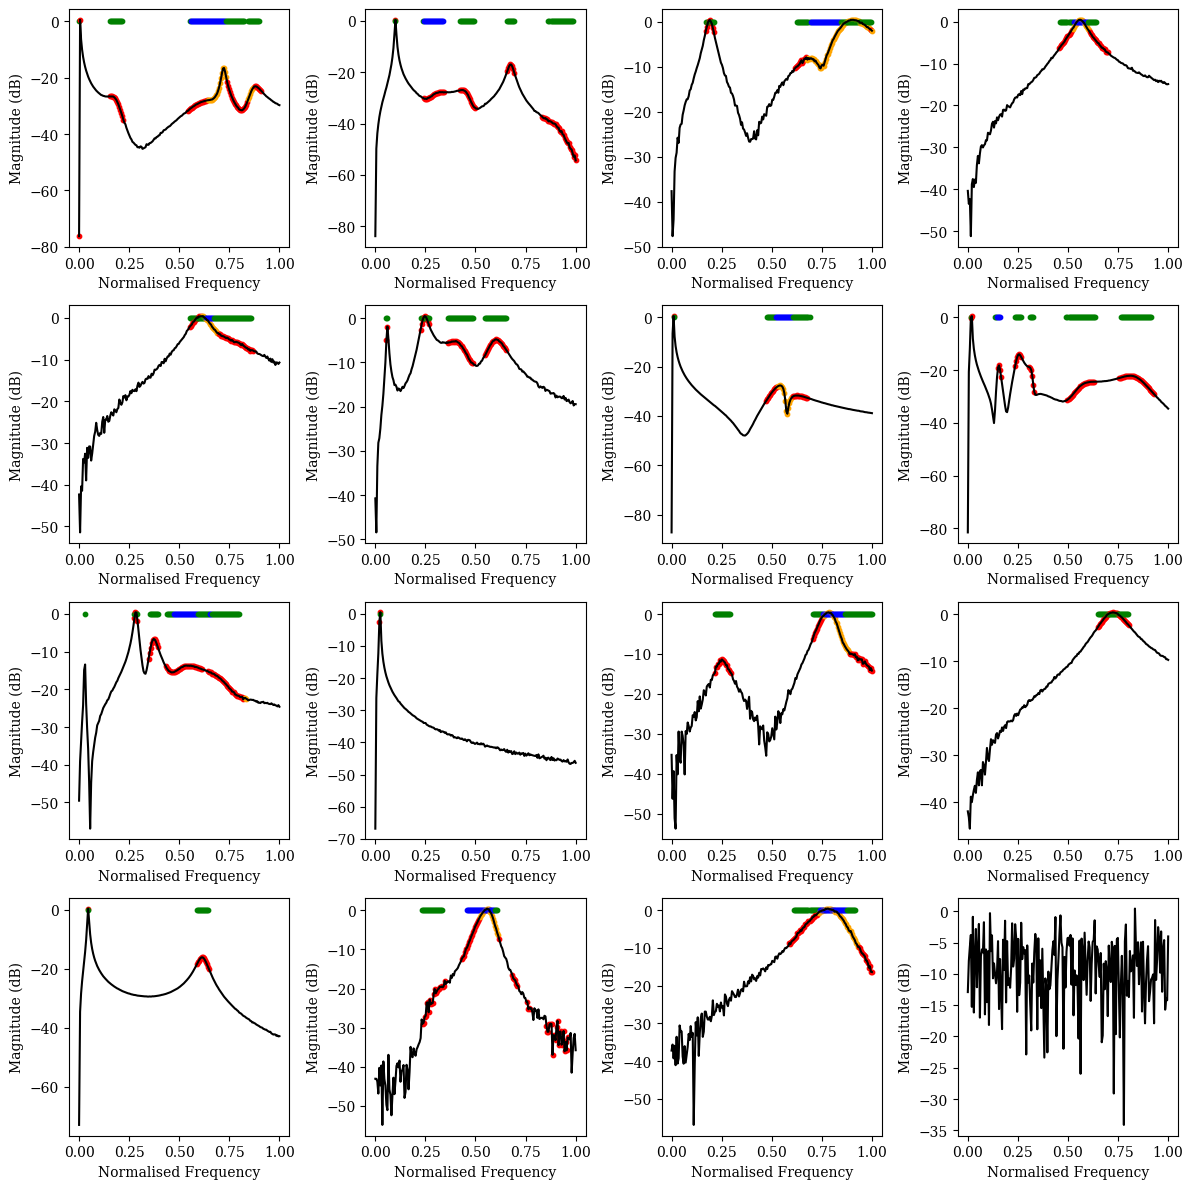

In [297]:
plot_predictions_extended(maxnorm_model_8, num_w_points=200, normalise=None, neg_an=True, multiclass=True, nrows=4, ncols=4, s=10, logmag=True, scaled_logmag=True)

### Different weights

In [284]:
weights_4 = torch.tensor([1, 4.0, 8.0])

In [285]:
maxnorm_model_9 = BiLSTM(input_size=5, hidden_size=70, num_layers=2, num_classes=3)
maxnorm_res_9 = train_model_multiclass(maxnorm_model_9, Xlog2, ylog2, Xlogval2, ylogval2, name='norm_95_max(16.02)_2', num_epochs=50, batch_size=128, weights=weights_4)

  2%|▏         | 1/50 [04:16<3:29:13, 256.20s/it]

Epoch [1/50], Loss: 0.8046370286941529, Precision: 0.8492363758847912, Recall: 0.9453176537288701
Val Loss: 0.6566980156898499, Validation Precision: 0.8754380451649196, Validation Recall: 0.9730832433869014


  4%|▍         | 2/50 [08:33<3:25:25, 256.79s/it]

Epoch [2/50], Loss: 0.7097139339447022, Precision: 0.9055628915581526, Recall: 0.9586373281425978
Val Loss: 0.5989955525398254, Validation Precision: 0.9129550077556624, Validation Recall: 0.9765683898815555


  6%|▌         | 3/50 [12:51<3:21:36, 257.38s/it]

Epoch [3/50], Loss: 0.6687434142827988, Precision: 0.9237245172828392, Recall: 0.9615407371194704
Val Loss: 0.5581041054725647, Validation Precision: 0.9301059313702823, Validation Recall: 0.9787701952643048


  8%|▊         | 4/50 [17:08<3:17:14, 257.28s/it]

Epoch [4/50], Loss: 0.6382407302856445, Precision: 0.9351071171493016, Recall: 0.963993333871834
Val Loss: 0.5324102149009705, Validation Precision: 0.9540076789348295, Validation Recall: 0.9763880459519824


 10%|█         | 5/50 [21:26<3:13:05, 257.45s/it]

Epoch [5/50], Loss: 0.6135193129777908, Precision: 0.9422428049077903, Recall: 0.9654677706884172
Val Loss: 0.4983720588684082, Validation Precision: 0.9630460346210267, Validation Recall: 0.9784325189671892


 12%|█▏        | 6/50 [25:44<3:08:55, 257.63s/it]

Epoch [6/50], Loss: 0.5939685196876526, Precision: 0.9474504432841105, Recall: 0.9665035663274898
Val Loss: 0.4749140532016754, Validation Precision: 0.9573703603950021, Validation Recall: 0.981684242652758


 14%|█▍        | 7/50 [30:02<3:04:40, 257.69s/it]

Epoch [7/50], Loss: 0.577501305937767, Precision: 0.9514031722042569, Recall: 0.9672786726209203
Val Loss: 0.4632672567367554, Validation Precision: 0.9602759505257458, Validation Recall: 0.9830416488867816


 16%|█▌        | 8/50 [34:20<3:00:35, 257.98s/it]

Epoch [8/50], Loss: 0.5657378258109093, Precision: 0.9537906225855409, Recall: 0.9678715481885803
Val Loss: 0.45052461528778076, Validation Precision: 0.9554841596091961, Validation Recall: 0.985033155995246


 18%|█▊        | 9/50 [38:40<2:56:36, 258.46s/it]

Epoch [9/50], Loss: 0.5552851940989494, Precision: 0.9553966901101301, Recall: 0.968284813241137
Val Loss: 0.4405506317615509, Validation Precision: 0.963953263832622, Validation Recall: 0.9835365667155939


 20%|██        | 10/50 [43:01<2:52:47, 259.19s/it]

Epoch [10/50], Loss: 0.5454639067649841, Precision: 0.957612049350391, Recall: 0.9688368630099885
Val Loss: 0.42816549038887025, Validation Precision: 0.9561233524049194, Validation Recall: 0.9871031943345752


 22%|██▏       | 11/50 [47:22<2:48:52, 259.81s/it]

Epoch [11/50], Loss: 0.5380942667126656, Precision: 0.959105236725811, Recall: 0.969188586663763
Val Loss: 0.423790833234787, Validation Precision: 0.9668297448921626, Validation Recall: 0.9852464179772256


 24%|██▍       | 12/50 [51:43<2:44:50, 260.27s/it]

Epoch [12/50], Loss: 0.5318426792621612, Precision: 0.9602083195970273, Recall: 0.9694552541070847
Val Loss: 0.41664010095596316, Validation Precision: 0.9644538597705943, Validation Recall: 0.9861784441893665


 26%|██▌       | 13/50 [56:04<2:40:39, 260.52s/it]

Epoch [13/50], Loss: 0.527200554907322, Precision: 0.9607207500071094, Recall: 0.9696753693365728
Val Loss: 0.41404775524139403, Validation Precision: 0.9728705054720101, Validation Recall: 0.9846597866480665


 28%|██▊       | 14/50 [1:00:25<2:36:22, 260.62s/it]

Epoch [14/50], Loss: 0.5217288796305657, Precision: 0.9622049110638596, Recall: 0.9699328732469437
Val Loss: 0.40723826456069945, Validation Precision: 0.9611076210802737, Validation Recall: 0.9877190293406535


 30%|███       | 15/50 [1:04:46<2:32:08, 260.81s/it]

Epoch [15/50], Loss: 0.5178893302083015, Precision: 0.962727350990174, Recall: 0.9701457546668546
Val Loss: 0.40642450642585753, Validation Precision: 0.9674724842935535, Validation Recall: 0.9868713004063473


 32%|███▏      | 16/50 [1:09:07<2:27:49, 260.86s/it]

Epoch [16/50], Loss: 0.512956705391407, Precision: 0.9636133554865703, Recall: 0.9703324470500813
Val Loss: 0.3994177768230438, Validation Precision: 0.9716671705113111, Validation Recall: 0.986000436395019


 34%|███▍      | 17/50 [1:13:31<2:23:59, 261.80s/it]

Epoch [17/50], Loss: 0.5081278861165047, Precision: 0.9645324396473193, Recall: 0.9704484359324652
Val Loss: 0.4009308843612671, Validation Precision: 0.9673877378669653, Validation Recall: 0.9868225411807536


 36%|███▌      | 18/50 [1:17:55<2:19:57, 262.41s/it]

Epoch [18/50], Loss: 0.5055093328952789, Precision: 0.9648882392603383, Recall: 0.970649290386606
Val Loss: 0.39505197310447693, Validation Precision: 0.9698438798649058, Validation Recall: 0.9867300911442713


 38%|███▊      | 19/50 [1:22:19<2:15:50, 262.91s/it]

Epoch [19/50], Loss: 0.5011338406205177, Precision: 0.9658976340564744, Recall: 0.9708347289764708
Val Loss: 0.3907179403305054, Validation Precision: 0.9619915268160393, Validation Recall: 0.9886897804110111


 40%|████      | 20/50 [1:26:42<2:11:28, 262.95s/it]

Epoch [20/50], Loss: 0.4984125580787659, Precision: 0.96606157586352, Recall: 0.9708844166568255
Val Loss: 0.3871590914726257, Validation Precision: 0.9691035971208062, Validation Recall: 0.9873171089436756


 42%|████▏     | 21/50 [1:31:06<2:07:13, 263.23s/it]

Epoch [21/50], Loss: 0.494436403632164, Precision: 0.9667571812803628, Recall: 0.9710472661789844
Val Loss: 0.3863720560073853, Validation Precision: 0.9653232801862645, Validation Recall: 0.9887418325158615


 44%|████▍     | 22/50 [1:35:30<2:02:58, 263.53s/it]

Epoch [22/50], Loss: 0.4919175863265991, Precision: 0.9671841087330196, Recall: 0.9711508005628202
Val Loss: 0.3820875482559204, Validation Precision: 0.9670559730396565, Validation Recall: 0.9881403244235178


 46%|████▌     | 23/50 [1:39:54<1:58:39, 263.67s/it]

Epoch [23/50], Loss: 0.488132406771183, Precision: 0.9672480710038872, Recall: 0.9713225374980375
Val Loss: 0.37705842208862306, Validation Precision: 0.9745320211228813, Validation Recall: 0.9873337446810275


 48%|████▊     | 24/50 [1:44:17<1:54:07, 263.37s/it]

Epoch [24/50], Loss: 0.48689659053087236, Precision: 0.9680054050537874, Recall: 0.9714438572470155
Val Loss: 0.38209396934509277, Validation Precision: 0.9767580461533318, Validation Recall: 0.9860818337151891


 50%|█████     | 25/50 [1:48:39<1:49:36, 263.05s/it]

Epoch [25/50], Loss: 0.48404036623239516, Precision: 0.9681289530165527, Recall: 0.9714540085447239
Val Loss: 0.37693743014335634, Validation Precision: 0.9713396691913521, Validation Recall: 0.9876407080795738


 52%|█████▏    | 26/50 [1:53:01<1:45:05, 262.71s/it]

Epoch [26/50], Loss: 0.48036740797758104, Precision: 0.9687489645485967, Recall: 0.9717285285580173
Val Loss: 0.37302856183052063, Validation Precision: 0.9747895076932029, Validation Recall: 0.9876144672957112


 54%|█████▍    | 27/50 [1:57:24<1:40:40, 262.62s/it]

Epoch [27/50], Loss: 0.4796291842460632, Precision: 0.968906690378869, Recall: 0.9715627672982816
Val Loss: 0.3827017755508423, Validation Precision: 0.9669637233454036, Validation Recall: 0.9883483295727475


 56%|█████▌    | 28/50 [2:01:45<1:36:10, 262.30s/it]

Epoch [28/50], Loss: 0.4775406207442284, Precision: 0.9690015004478025, Recall: 0.9718145358488743
Val Loss: 0.3666880240440369, Validation Precision: 0.970859151770703, Validation Recall: 0.9888310320519282


 58%|█████▊    | 29/50 [2:06:06<1:31:40, 261.95s/it]

Epoch [29/50], Loss: 0.47549483931064607, Precision: 0.9695285463007919, Recall: 0.9718697638772743
Val Loss: 0.3683856656551361, Validation Precision: 0.972013410667431, Validation Recall: 0.9887727511576841


 60%|██████    | 30/50 [2:10:28<1:27:16, 261.82s/it]

Epoch [30/50], Loss: 0.4723699302077293, Precision: 0.9698519387229909, Recall: 0.9720249354252531
Val Loss: 0.3684562981128693, Validation Precision: 0.974075642359001, Validation Recall: 0.9881615742965936


 62%|██████▏   | 31/50 [2:14:51<1:23:02, 262.25s/it]

Epoch [31/50], Loss: 0.4717197970151901, Precision: 0.969883030005733, Recall: 0.9721052029674105
Val Loss: 0.3747124791145325, Validation Precision: 0.9712259380378535, Validation Recall: 0.9882756682470241


 64%|██████▍   | 32/50 [2:19:14<1:18:45, 262.51s/it]

Epoch [32/50], Loss: 0.4702959004044533, Precision: 0.9699188110695101, Recall: 0.9719712335360935
Val Loss: 0.36899943566322324, Validation Precision: 0.973664526358656, Validation Recall: 0.9886268616342154


 66%|██████▌   | 33/50 [2:23:37<1:14:23, 262.55s/it]

Epoch [33/50], Loss: 0.467863073348999, Precision: 0.9706147427554421, Recall: 0.97217528134233
Val Loss: 0.36289884519577026, Validation Precision: 0.972191537885266, Validation Recall: 0.9892313187786845


 68%|██████▊   | 34/50 [2:27:59<1:09:58, 262.43s/it]

Epoch [34/50], Loss: 0.46604501628875733, Precision: 0.9704949678974488, Recall: 0.9722387755703018
Val Loss: 0.37010849261283874, Validation Precision: 0.9698109548100696, Validation Recall: 0.9890527647618829


 70%|███████   | 35/50 [2:32:22<1:05:41, 262.74s/it]

Epoch [35/50], Loss: 0.46436618250608447, Precision: 0.9709753393397063, Recall: 0.9722526246752262
Val Loss: 0.36043438768386843, Validation Precision: 0.97669508408915, Validation Recall: 0.9884388814079825


 72%|███████▏  | 36/50 [2:36:45<1:01:18, 262.74s/it]

Epoch [36/50], Loss: 0.461289215862751, Precision: 0.9711169011134766, Recall: 0.97235653252915
Val Loss: 0.35890522646903994, Validation Precision: 0.9771895202388668, Validation Recall: 0.9884915652589925


 74%|███████▍  | 37/50 [2:41:08<56:56, 262.83s/it]  

Epoch [37/50], Loss: 0.4609860153198242, Precision: 0.9711304811537326, Recall: 0.9723339436576283
Val Loss: 0.3629551591873169, Validation Precision: 0.9651551376691584, Validation Recall: 0.9902378077398515


 76%|███████▌  | 38/50 [2:45:31<52:33, 262.79s/it]

Epoch [38/50], Loss: 0.45909300416707993, Precision: 0.9714286060947508, Recall: 0.9725368469778645
Val Loss: 0.35758813881874085, Validation Precision: 0.9719509991339763, Validation Recall: 0.9895848825975626


 78%|███████▊  | 39/50 [2:49:53<48:09, 262.72s/it]

Epoch [39/50], Loss: 0.4577078927755356, Precision: 0.9713188793376559, Recall: 0.9724955605807001
Val Loss: 0.3549865097999573, Validation Precision: 0.9748867343246922, Validation Recall: 0.9891116143429134


 80%|████████  | 40/50 [2:54:16<43:45, 262.52s/it]

Epoch [40/50], Loss: 0.4566350154280662, Precision: 0.9717264159386332, Recall: 0.9724634556015447
Val Loss: 0.35868615508079527, Validation Precision: 0.9697145526617617, Validation Recall: 0.9900685853703565


 82%|████████▏ | 41/50 [2:58:38<39:23, 262.64s/it]

Epoch [41/50], Loss: 0.4541476145386696, Precision: 0.9719054474497286, Recall: 0.9725517460578584
Val Loss: 0.34741894555091857, Validation Precision: 0.9761608714641403, Validation Recall: 0.9895194774820465


 84%|████████▍ | 42/50 [3:03:01<35:00, 262.54s/it]

Epoch [42/50], Loss: 0.45239522790908815, Precision: 0.9722896929177208, Recall: 0.9726335520869969
Val Loss: 0.35300473308563235, Validation Precision: 0.9720967404377473, Validation Recall: 0.9899814275397898


 86%|████████▌ | 43/50 [3:07:23<30:37, 262.56s/it]

Epoch [43/50], Loss: 0.45111922758817674, Precision: 0.9722903123534753, Recall: 0.9727066078295709
Val Loss: 0.3589688708782196, Validation Precision: 0.976182794753399, Validation Recall: 0.9886328468924023


 88%|████████▊ | 44/50 [3:11:46<26:15, 262.63s/it]

Epoch [44/50], Loss: 0.4502060151696205, Precision: 0.9722681875888733, Recall: 0.9728170633060256
Val Loss: 0.34938699460029604, Validation Precision: 0.9745301137583611, Validation Recall: 0.9894012569870234


 90%|█████████ | 45/50 [3:16:09<21:52, 262.56s/it]

Epoch [45/50], Loss: 0.44779520469903944, Precision: 0.9725668494595953, Recall: 0.9729123856657146
Val Loss: 0.35244134831428525, Validation Precision: 0.9731473612752034, Validation Recall: 0.9898973435143308


 92%|█████████▏| 46/50 [3:20:29<17:28, 262.06s/it]

Epoch [46/50], Loss: 0.44890911984443665, Precision: 0.972210869099556, Recall: 0.9728477831396858
Val Loss: 0.3557873961925507, Validation Precision: 0.9803289476326833, Validation Recall: 0.9880011353987102


 94%|█████████▍| 47/50 [3:24:51<13:05, 261.90s/it]

Epoch [47/50], Loss: 0.4456872757077217, Precision: 0.9727939328071631, Recall: 0.972939277700657
Val Loss: 0.345721866607666, Validation Precision: 0.973164575780962, Validation Recall: 0.9903794961503641


 96%|█████████▌| 48/50 [3:29:13<08:43, 261.80s/it]

Epoch [48/50], Loss: 0.44492326146364214, Precision: 0.9725857404958519, Recall: 0.9729242748991906
Val Loss: 0.35117175889015195, Validation Precision: 0.9698954142832729, Validation Recall: 0.9907052625084561


 98%|█████████▊| 49/50 [3:33:33<04:21, 261.40s/it]

Epoch [49/50], Loss: 0.44353083038330077, Precision: 0.9729648728917787, Recall: 0.9729914203821957
Val Loss: 0.34598202252388, Validation Precision: 0.9749286409718338, Validation Recall: 0.9900433759941994


100%|██████████| 50/50 [3:37:53<00:00, 261.48s/it]

Epoch [50/50], Loss: 0.44210037517547607, Precision: 0.9731581436556694, Recall: 0.9729912311946903
Val Loss: 0.34838068413734435, Validation Precision: 0.9739959825287534, Validation Recall: 0.9899248934914053


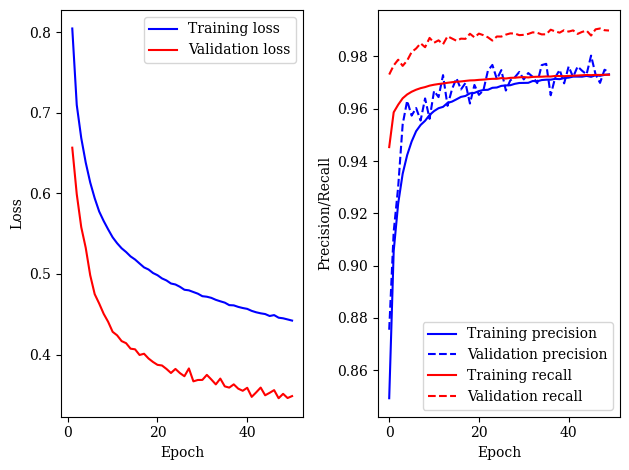

In [289]:
modal.plot_results(maxnorm_res_9)

In [3]:
plot_predictions_extended(maxnorm_model_9, num_w_points=200, normalise=None, neg_an=True, multiclass=True, nrows=4, ncols=4, s=10, logmag=True, scaled_logmag=True)

NameError: name 'maxnorm_model_9' is not defined

## 21/02

In [61]:
Xlog3, ylog3, _, __ = generate_dat_extended(32*500, 300, multiclass=True, normalise=None, neg_an=True, logmag=True, scaled_logmag=True)
Xlogval3, ylogval3, _, __ = generate_dat_extended(32*100, 300, multiclass=True, normalise=None, neg_an=True, logmag=True, scaled_logmag=True)

In [62]:
maxnorm_model_10 = BiLSTM(input_size=5, hidden_size=120, num_layers=3, num_classes=3)
maxnorm_res_10 = train_model_multiclass(maxnorm_model_10, Xlog3, ylog3, Xlogval3, ylogval3, name='norm_95_max(21.02)', num_epochs=25, batch_size=32, device='cpu')

  4%|▍         | 1/25 [05:05<2:02:12, 305.52s/it]

Epoch [1/25], Loss: 0.8101454516649246, Precision: 0.888252442598576, Recall: 0.930651893721672
Val Loss: 0.6497410798072815, Validation Precision: 0.9149824674901683, Validation Recall: 0.9547316033156673


  8%|▊         | 2/25 [10:07<1:56:20, 303.50s/it]

Epoch [2/25], Loss: 0.6983379249572754, Precision: 0.9236257267685307, Recall: 0.9518942021833435
Val Loss: 0.5926109904050827, Validation Precision: 0.9100221589471995, Validation Recall: 0.9719652909524467


 12%|█▏        | 3/25 [15:17<1:52:25, 306.60s/it]

Epoch [3/25], Loss: 0.6676035488843918, Precision: 0.9335596889602393, Recall: 0.9554928669839359
Val Loss: 0.5500536888837815, Validation Precision: 0.9529080803139794, Validation Recall: 0.9687308745310393


 16%|█▌        | 4/25 [20:39<1:49:25, 312.66s/it]

Epoch [4/25], Loss: 0.6429980524182319, Precision: 0.9414637794197873, Recall: 0.9567630001406693
Val Loss: 0.5327587807178498, Validation Precision: 0.9553086104702365, Validation Recall: 0.9709307913727807


 20%|██        | 5/25 [25:50<1:44:00, 312.03s/it]

Epoch [5/25], Loss: 0.6209395861625672, Precision: 0.9476763893367989, Recall: 0.9592661037855698
Val Loss: 0.500133641064167, Validation Precision: 0.9491500847607359, Validation Recall: 0.9774488075730919


 24%|██▍       | 6/25 [31:00<1:38:35, 311.37s/it]

Epoch [6/25], Loss: 0.5979022362232208, Precision: 0.9517263635601977, Recall: 0.9610366280362868
Val Loss: 0.4857120048999786, Validation Precision: 0.9528908225654433, Validation Recall: 0.978254265980084


 28%|██▊       | 7/25 [36:15<1:33:42, 312.37s/it]

Epoch [7/25], Loss: 0.5817154841423035, Precision: 0.955635916197618, Recall: 0.9623446694755096
Val Loss: 0.47448020994663237, Validation Precision: 0.9505823666651922, Validation Recall: 0.9807847068015879


 32%|███▏      | 8/25 [41:30<1:28:43, 313.16s/it]

Epoch [8/25], Loss: 0.5704027064442635, Precision: 0.9574780965306599, Recall: 0.963076620756327
Val Loss: 0.4702398145198822, Validation Precision: 0.9784013389577169, Validation Recall: 0.9721538266219517


 36%|███▌      | 9/25 [46:43<1:23:30, 313.14s/it]

Epoch [9/25], Loss: 0.558460914671421, Precision: 0.9587216112839277, Recall: 0.9640091690832071
Val Loss: 0.45574112951755524, Validation Precision: 0.9662686172243775, Validation Recall: 0.9779085565016756


 40%|████      | 10/25 [52:06<1:19:05, 316.35s/it]

Epoch [10/25], Loss: 0.5508820214867591, Precision: 0.9609760053701337, Recall: 0.9640429124259815
Val Loss: 0.4366532960534096, Validation Precision: 0.964969075711188, Validation Recall: 0.9822547324294029


 44%|████▍     | 11/25 [57:07<1:12:42, 311.61s/it]

Epoch [11/25], Loss: 0.5379558026194572, Precision: 0.9627309283741622, Recall: 0.9652134434076765
Val Loss: 0.4509440052509308, Validation Precision: 0.9553041580657577, Validation Recall: 0.9818919380797446


 48%|████▊     | 12/25 [1:02:23<1:07:46, 312.79s/it]

Epoch [12/25], Loss: 0.5287892304062843, Precision: 0.964306900952479, Recall: 0.9656345657101277
Val Loss: 0.42288791060447695, Validation Precision: 0.9573147862461308, Validation Recall: 0.9846235973444761


 52%|█████▏    | 13/25 [1:07:42<1:02:56, 314.71s/it]

Epoch [13/25], Loss: 0.5206402153968811, Precision: 0.965015268632476, Recall: 0.9663847668261727
Val Loss: 0.40609545558691024, Validation Precision: 0.9732262868324136, Validation Recall: 0.9819546042119923


 56%|█████▌    | 14/25 [1:12:52<57:27, 313.41s/it]  

Epoch [14/25], Loss: 0.5138455362915992, Precision: 0.9663421361319354, Recall: 0.9664015924502126
Val Loss: 0.4006016203761101, Validation Precision: 0.9696157571830814, Validation Recall: 0.9841337617177325


 60%|██████    | 15/25 [1:18:03<52:06, 312.65s/it]

Epoch [15/25], Loss: 0.5061394566893578, Precision: 0.9672498314073924, Recall: 0.9669174759235898
Val Loss: 0.4040455135703087, Validation Precision: 0.9676034159776948, Validation Recall: 0.9833003120153326


 64%|██████▍   | 16/25 [1:23:27<47:24, 316.10s/it]

Epoch [16/25], Loss: 0.49955112433433535, Precision: 0.9683758291336648, Recall: 0.967417936710799
Val Loss: 0.3986313569545746, Validation Precision: 0.9778954256301182, Validation Recall: 0.9810695940474807


 68%|██████▊   | 17/25 [1:28:30<41:37, 312.19s/it]

Epoch [17/25], Loss: 0.49281208133697507, Precision: 0.9694827463663709, Recall: 0.9675774996686742
Val Loss: 0.38938199609518054, Validation Precision: 0.9691678536053925, Validation Recall: 0.9854942825525864


 72%|███████▏  | 18/25 [1:33:30<35:59, 308.52s/it]

Epoch [18/25], Loss: 0.4867541627883911, Precision: 0.9693732934061916, Recall: 0.967842246659063
Val Loss: 0.39552785277366637, Validation Precision: 0.970391451781784, Validation Recall: 0.9840032247046036


 76%|███████▌  | 19/25 [1:38:38<30:49, 308.20s/it]

Epoch [19/25], Loss: 0.4807753649353981, Precision: 0.9705841393487615, Recall: 0.9681856332260845
Val Loss: 0.38574288815259933, Validation Precision: 0.9761670567532859, Validation Recall: 0.9839239698463994


 80%|████████  | 20/25 [1:43:57<25:57, 311.53s/it]

Epoch [20/25], Loss: 0.47619723063707353, Precision: 0.9710131519813047, Recall: 0.9682824788395884
Val Loss: 0.38077710270881654, Validation Precision: 0.9790051320161429, Validation Recall: 0.9831151409975101


 84%|████████▍ | 21/25 [1:49:18<20:57, 314.33s/it]

Epoch [21/25], Loss: 0.46960833328962326, Precision: 0.9717531849501239, Recall: 0.9687241566162518
Val Loss: 0.3789388602972031, Validation Precision: 0.9710465362749336, Validation Recall: 0.985577910681239


 88%|████████▊ | 22/25 [1:54:43<15:52, 317.56s/it]

Epoch [22/25], Loss: 0.4651076272726059, Precision: 0.9721251236135895, Recall: 0.9690343975186951
Val Loss: 0.37838534846901895, Validation Precision: 0.9692898608344287, Validation Recall: 0.9863228011190722


 92%|█████████▏| 23/25 [2:00:00<10:34, 317.30s/it]

Epoch [23/25], Loss: 0.46087292128801344, Precision: 0.9725490709641245, Recall: 0.9689788106924333
Val Loss: 0.3770626963675022, Validation Precision: 0.9786145750637061, Validation Recall: 0.9837833683901287


 96%|█████████▌| 24/25 [2:05:04<05:13, 313.44s/it]

Epoch [24/25], Loss: 0.4550000539422035, Precision: 0.972839101113181, Recall: 0.969361854153801
Val Loss: 0.3752874131500721, Validation Precision: 0.9719686876777167, Validation Recall: 0.985382946603667


100%|██████████| 25/25 [2:10:19<00:00, 312.78s/it]

Epoch [25/25], Loss: 0.45367887526750567, Precision: 0.9726648482633286, Recall: 0.9694027808633602
Val Loss: 0.37710478752851484, Validation Precision: 0.9793882984455259, Validation Recall: 0.9836758359515488


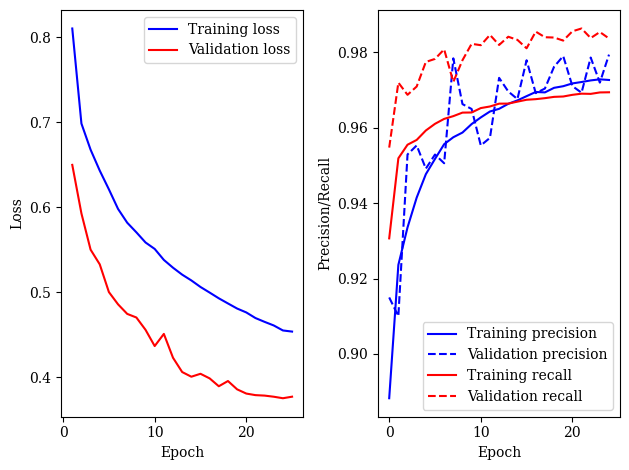

In [63]:
modal.plot_results(maxnorm_res_10)

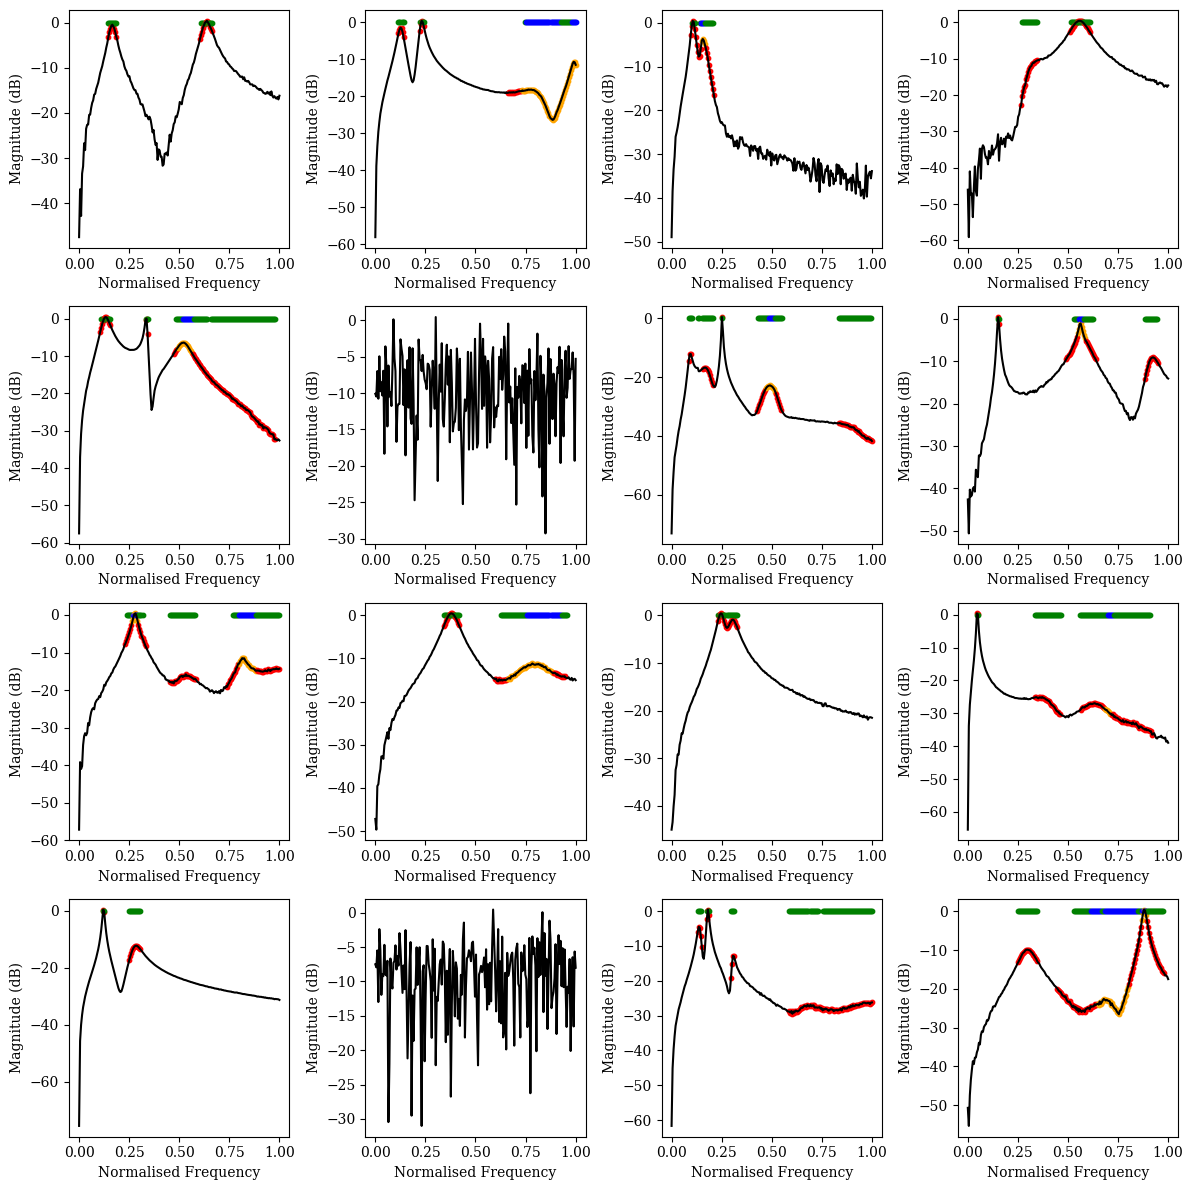

In [64]:
plot_predictions_extended(maxnorm_model_10, num_w_points=200, normalise=None, neg_an=True, multiclass=True, nrows=4, ncols=4, s=10, logmag=True, scaled_logmag=True)

## 22/02

### No logmag, changed neg_an implementation so that a_n below 0.5 are not generated

In [23]:
X, y, _, __ = generate_dat_extended(32*500, 300, multiclass=True, normalise=None, neg_an=True, sigma_max=0.2)
Xval, yval, _, __ = generate_dat_extended(32*100, 300, multiclass=True, normalise=None, neg_an=True, sigma_max=0.2)

In [120]:
maxnorm_model_11 = BiLSTM(input_size=4, hidden_size=120, num_layers=3, num_classes=3)
maxnorm_res_11 = train_model_multiclass(maxnorm_model_11, X, y, Xval, yval, name='norm_95_max(22.02)', num_epochs=25, batch_size=32, device='cpu')

  4%|▍         | 1/25 [04:55<1:58:16, 295.70s/it]

Epoch [1/25], Loss: 0.8251870864629746, Precision: 0.8655613359838507, Recall: 0.9355584667220348
Val Loss: 0.6597753509879112, Validation Precision: 0.9325982215423259, Validation Recall: 0.9588558832657889


  8%|▊         | 2/25 [09:37<1:50:10, 287.41s/it]

Epoch [2/25], Loss: 0.6951320923566818, Precision: 0.9201536071210956, Recall: 0.9610761602526021
Val Loss: 0.5779225003719329, Validation Precision: 0.9252043429981329, Validation Recall: 0.9788388812617137


 12%|█▏        | 3/25 [14:14<1:43:39, 282.70s/it]

Epoch [3/25], Loss: 0.6488277209997177, Precision: 0.9341861126895491, Recall: 0.9643822109866579
Val Loss: 0.5495576906204224, Validation Precision: 0.9306849876906782, Validation Recall: 0.9864838031781464


 16%|█▌        | 4/25 [19:00<1:39:21, 283.86s/it]

Epoch [4/25], Loss: 0.6303780038356781, Precision: 0.9391673434229962, Recall: 0.9652950376723994
Val Loss: 0.5136567008495331, Validation Precision: 0.9473296425913738, Validation Recall: 0.9837973896756924


 20%|██        | 5/25 [23:36<1:33:41, 281.08s/it]

Epoch [5/25], Loss: 0.6055421271324157, Precision: 0.9454559232327856, Recall: 0.9670014702584929
Val Loss: 0.4899711784720421, Validation Precision: 0.9424666019411427, Validation Recall: 0.9855659304954263


 24%|██▍       | 6/25 [28:10<1:28:14, 278.66s/it]

Epoch [6/25], Loss: 0.5792783465385437, Precision: 0.951215901391687, Recall: 0.9688379524445179
Val Loss: 0.4527850779891014, Validation Precision: 0.9579834397846543, Validation Recall: 0.9862910645586408


 28%|██▊       | 7/25 [32:48<1:23:33, 278.54s/it]

Epoch [7/25], Loss: 0.5691952894926071, Precision: 0.9526476104900201, Recall: 0.968935047608247
Val Loss: 0.47039455562829974, Validation Precision: 0.9559811096619742, Validation Recall: 0.9829411623298047


 32%|███▏      | 8/25 [37:35<1:19:40, 281.22s/it]

Epoch [8/25], Loss: 0.5517034344077111, Precision: 0.9567568712163357, Recall: 0.9697248250927731
Val Loss: 0.43609657138586044, Validation Precision: 0.9687639348086098, Validation Recall: 0.9839824250121528


 36%|███▌      | 9/25 [42:27<1:15:52, 284.56s/it]

Epoch [9/25], Loss: 0.5344800301194191, Precision: 0.958980172714824, Recall: 0.9704699328220572
Val Loss: 0.41747815877199174, Validation Precision: 0.9601331511212876, Validation Recall: 0.9873537122316829


 40%|████      | 10/25 [47:15<1:11:24, 285.65s/it]

Epoch [10/25], Loss: 0.5103556258678437, Precision: 0.9638776738407283, Recall: 0.9715920209071564
Val Loss: 0.392952381670475, Validation Precision: 0.9620207100807083, Validation Recall: 0.9901056058737332


 44%|████▍     | 11/25 [51:56<1:06:20, 284.30s/it]

Epoch [11/25], Loss: 0.49120771074295044, Precision: 0.9661557153128841, Recall: 0.9722347659458032
Val Loss: 0.38014404982328415, Validation Precision: 0.9680771960367087, Validation Recall: 0.9891182783233795


 48%|████▊     | 12/25 [56:41<1:01:38, 284.53s/it]

Epoch [12/25], Loss: 0.4789075908064842, Precision: 0.9681680776446482, Recall: 0.9726667909109191
Val Loss: 0.3593082344532013, Validation Precision: 0.9644240892731679, Validation Recall: 0.992236143089378


 52%|█████▏    | 13/25 [1:01:26<56:54, 284.58s/it]

Epoch [13/25], Loss: 0.4680726307630539, Precision: 0.9689385718683211, Recall: 0.9730236322638464
Val Loss: 0.3454712261259556, Validation Precision: 0.9686854445853008, Validation Recall: 0.9919177803984404


 56%|█████▌    | 14/25 [1:50:30<3:19:26, 1087.83s/it]

Epoch [14/25], Loss: 0.4568317517638206, Precision: 0.9703558362956013, Recall: 0.9734020916295483
Val Loss: 0.34346659198403356, Validation Precision: 0.9724516016631098, Validation Recall: 0.9910838001160639


 60%|██████    | 15/25 [1:55:19<2:21:10, 847.01s/it] 

Epoch [15/25], Loss: 0.4498999264240265, Precision: 0.9722556516215686, Recall: 0.9736602992642334
Val Loss: 0.32829408928751946, Validation Precision: 0.9742917056791428, Validation Recall: 0.9913115529767231


 64%|██████▍   | 16/25 [2:00:18<1:42:19, 682.21s/it]

Epoch [16/25], Loss: 0.43995530098676683, Precision: 0.9727335378389398, Recall: 0.9739269833270863
Val Loss: 0.3371983236074448, Validation Precision: 0.9719131880855437, Validation Recall: 0.9920561755546475


 68%|██████▊   | 17/25 [2:05:06<1:15:07, 563.48s/it]

Epoch [17/25], Loss: 0.4337425163388252, Precision: 0.9734472061622006, Recall: 0.9740088492332375
Val Loss: 0.3440949860215187, Validation Precision: 0.9719668450097386, Validation Recall: 0.9910574433970339


 72%|███████▏  | 18/25 [2:10:09<56:37, 485.32s/it]  

Epoch [18/25], Loss: 0.4256539480090141, Precision: 0.9740169261805187, Recall: 0.9741813462144575
Val Loss: 0.31801808685064314, Validation Precision: 0.9744722586241541, Validation Recall: 0.9931706284601014


 76%|███████▌  | 19/25 [2:15:15<43:08, 431.34s/it]

Epoch [19/25], Loss: 0.41774773472547533, Precision: 0.9753402810303574, Recall: 0.9746023620675688
Val Loss: 0.3269327720999718, Validation Precision: 0.9679249864451518, Validation Recall: 0.9942300859627333


 80%|████████  | 20/25 [2:20:21<32:49, 393.92s/it]

Epoch [20/25], Loss: 0.41164650112390516, Precision: 0.9752250927070196, Recall: 0.9746442376910351
Val Loss: 0.3056223085522652, Validation Precision: 0.9800010382135729, Validation Recall: 0.9926816179866127


 84%|████████▍ | 21/25 [2:25:16<24:17, 364.30s/it]

Epoch [21/25], Loss: 0.40411397150158884, Precision: 0.9765963514430109, Recall: 0.9750610921324628
Val Loss: 0.31059644162654876, Validation Precision: 0.9732661975406053, Validation Recall: 0.9931797491888054


 88%|████████▊ | 22/25 [2:30:08<17:07, 342.45s/it]

Epoch [22/25], Loss: 0.3983695988059044, Precision: 0.977377094244644, Recall: 0.9752961130147167
Val Loss: 0.3137709486484528, Validation Precision: 0.9831045978005577, Validation Recall: 0.9898885587343342


 92%|█████████▏| 23/25 [2:35:00<10:54, 327.36s/it]

Epoch [23/25], Loss: 0.38910579338669776, Precision: 0.9781419333756373, Recall: 0.9753823954399686
Val Loss: 0.29719189792871475, Validation Precision: 0.9747256590330083, Validation Recall: 0.9943789876138014


 96%|█████████▌| 24/25 [2:39:54<05:17, 317.37s/it]

Epoch [24/25], Loss: 0.38956959068775177, Precision: 0.9781020629173027, Recall: 0.9752181139569573
Val Loss: 0.2908648011088371, Validation Precision: 0.9797803627335818, Validation Recall: 0.9934925608311375


100%|██████████| 25/25 [2:44:44<00:00, 395.38s/it]

Epoch [25/25], Loss: 0.3821292952299118, Precision: 0.9789713500280195, Recall: 0.9754255159758932
Val Loss: 0.29429944887757303, Validation Precision: 0.978395600145215, Validation Recall: 0.9935895015241738


In [17]:
maxnorm_model_11 = torch.load('norm_95_max(22.02).pth')

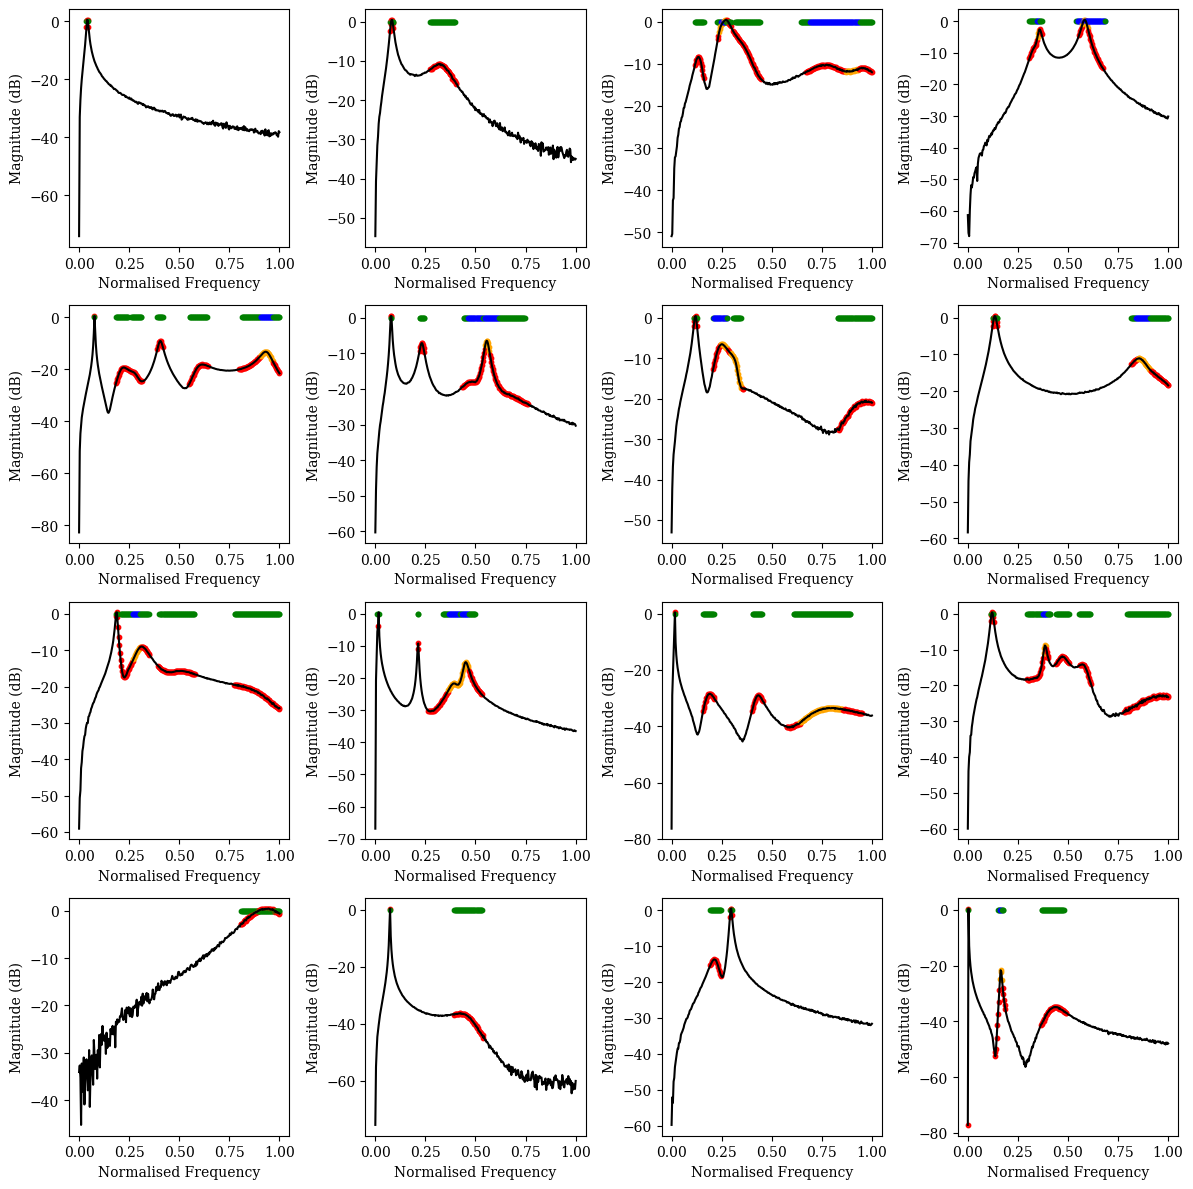

In [20]:
plot_predictions_extended(maxnorm_model_11, num_w_points=300, normalise=None, neg_an=True, multiclass=True, nrows=4, ncols=4, s=10)

(Note had to regenerate the training and val data here ...)

In [25]:
maxnorm_res_11_2 = train_model_multiclass(maxnorm_model_11, X, y, Xval, yval, name='norm_95_max(22.02)_50epochs', num_epochs=25, batch_size=32, device='cpu')

  4%|▍         | 1/25 [06:00<2:24:18, 360.76s/it]

Epoch [1/25], Loss: 0.409370651781559, Precision: 0.977606991310173, Recall: 0.9751949090444275
Val Loss: 0.2705755181610584, Validation Precision: 0.9741694143829122, Validation Recall: 0.9955309344073882


  8%|▊         | 2/25 [12:00<2:17:58, 359.95s/it]

Epoch [2/25], Loss: 0.39613077729940416, Precision: 0.9783461183420307, Recall: 0.9754291089914956
Val Loss: 0.2930575966835022, Validation Precision: 0.9791477702547724, Validation Recall: 0.9924160316620317


 12%|█▏        | 3/25 [18:08<2:13:21, 363.72s/it]

Epoch [3/25], Loss: 0.3879838727712631, Precision: 0.9792174114615431, Recall: 0.9755562109516619
Val Loss: 0.2799894578754902, Validation Precision: 0.9839868188820889, Validation Recall: 0.9925330606174709


 16%|█▌        | 4/25 [24:04<2:06:16, 360.79s/it]

Epoch [4/25], Loss: 0.37860915797948835, Precision: 0.9797295216417268, Recall: 0.9758351666528493
Val Loss: 0.2812400721013546, Validation Precision: 0.9722930259532258, Validation Recall: 0.9954320683116618


 20%|██        | 5/25 [29:52<1:58:44, 356.22s/it]

Epoch [5/25], Loss: 0.3730722309350967, Precision: 0.9798745479403143, Recall: 0.9758093075846364
Val Loss: 0.2714813582599163, Validation Precision: 0.9754262274001642, Validation Recall: 0.9951390592239022


 24%|██▍       | 6/25 [35:36<1:51:25, 351.88s/it]

Epoch [6/25], Loss: 0.36406942385435104, Precision: 0.9805339844896701, Recall: 0.9760177482436109
Val Loss: 0.25808207914233205, Validation Precision: 0.9786328647432831, Validation Recall: 0.9953580486690546


 28%|██▊       | 7/25 [41:16<1:44:25, 348.10s/it]

Epoch [7/25], Loss: 0.358417563021183, Precision: 0.9811132574255147, Recall: 0.9760485728964392
Val Loss: 0.26528340950608253, Validation Precision: 0.9858573541666601, Validation Recall: 0.9924392055865477


 32%|███▏      | 8/25 [46:59<1:38:10, 346.53s/it]

Epoch [8/25], Loss: 0.3536885439157486, Precision: 0.9815537589632585, Recall: 0.9761019546055522
Val Loss: 0.26772752121090887, Validation Precision: 0.9809505842790455, Validation Recall: 0.9941726348691937


 36%|███▌      | 9/25 [52:51<1:32:49, 348.07s/it]

Epoch [9/25], Loss: 0.3542363134026527, Precision: 0.9810161681209313, Recall: 0.9760363487334962
Val Loss: 0.27582395419478417, Validation Precision: 0.9847106311635784, Validation Recall: 0.9923156137076593


 40%|████      | 10/25 [58:51<1:27:55, 351.71s/it]

Epoch [10/25], Loss: 0.34609602198004724, Precision: 0.9818397328478324, Recall: 0.9762156008723891
Val Loss: 0.2741491475701332, Validation Precision: 0.9816208827855469, Validation Recall: 0.9930945794618974


 44%|████▍     | 11/25 [1:04:46<1:22:19, 352.84s/it]

Epoch [11/25], Loss: 0.34248767340183256, Precision: 0.9820389631014872, Recall: 0.9764328762665946
Val Loss: 0.28373965054750444, Validation Precision: 0.9793601837266803, Validation Recall: 0.9948303268116909


 48%|████▊     | 12/25 [1:10:47<1:16:57, 355.22s/it]

Epoch [12/25], Loss: 0.33829145491123197, Precision: 0.9825368789411378, Recall: 0.9763487525209992
Val Loss: 0.27532552912831304, Validation Precision: 0.9771592654636452, Validation Recall: 0.9943740551660238


 52%|█████▏    | 13/25 [1:17:00<1:12:09, 360.75s/it]

Epoch [13/25], Loss: 0.33312264025211336, Precision: 0.9824452830493674, Recall: 0.9763645777261089
Val Loss: 0.2801720243692398, Validation Precision: 0.9810720882578123, Validation Recall: 0.9938126920561814


 56%|█████▌    | 14/25 [1:23:16<1:06:59, 365.39s/it]

Epoch [14/25], Loss: 0.3275083270072937, Precision: 0.982675050088894, Recall: 0.9766146498505683
Val Loss: 0.28215930581092835, Validation Precision: 0.9778017207160764, Validation Recall: 0.9950975971855017


 60%|██████    | 15/25 [1:29:29<1:01:15, 367.57s/it]

Epoch [15/25], Loss: 0.325035388559103, Precision: 0.9828904733620429, Recall: 0.9766947483535696
Val Loss: 0.27076492115855216, Validation Precision: 0.9791520206152992, Validation Recall: 0.9954162455519121


 64%|██████▍   | 16/25 [1:35:44<55:28, 369.87s/it]  

Epoch [16/25], Loss: 0.3180123535990715, Precision: 0.9834372115905636, Recall: 0.9766901440384312
Val Loss: 0.27293638423085215, Validation Precision: 0.9793563333453571, Validation Recall: 0.9951147749382766


 68%|██████▊   | 17/25 [1:41:58<49:29, 371.24s/it]

Epoch [17/25], Loss: 0.3159160759449005, Precision: 0.9831202695010144, Recall: 0.9767792808495085
Val Loss: 0.2736200447380543, Validation Precision: 0.983369997210581, Validation Recall: 0.9944723599837474


 72%|███████▏  | 18/25 [1:48:09<43:17, 371.10s/it]

Epoch [18/25], Loss: 0.31425838321447375, Precision: 0.9833337323172503, Recall: 0.9767139324276704
Val Loss: 0.28348823353648184, Validation Precision: 0.9799165306085866, Validation Recall: 0.9945656592697049


 76%|███████▌  | 19/25 [1:54:25<37:15, 372.65s/it]

Epoch [19/25], Loss: 0.3127533949315548, Precision: 0.9835292192509033, Recall: 0.9768293027637448
Val Loss: 0.2669388616085053, Validation Precision: 0.9821427086445341, Validation Recall: 0.9951033035435455


 80%|████████  | 20/25 [2:00:41<31:07, 373.56s/it]

Epoch [20/25], Loss: 0.30836101388931275, Precision: 0.9834142501531219, Recall: 0.9765558139074122
Val Loss: 0.27291208520531657, Validation Precision: 0.9835054542862933, Validation Recall: 0.9940961476091291


 84%|████████▍ | 21/25 [2:06:58<24:58, 374.52s/it]

Epoch [21/25], Loss: 0.3054923510849476, Precision: 0.9836690945521251, Recall: 0.9767454823752368
Val Loss: 0.26677764505147933, Validation Precision: 0.9797023735630697, Validation Recall: 0.9958377213707911


 88%|████████▊ | 22/25 [2:13:12<18:43, 374.45s/it]

Epoch [22/25], Loss: 0.2996616199314594, Precision: 0.9838956376043768, Recall: 0.9768655023792813
Val Loss: 0.28846316620707513, Validation Precision: 0.9802835550694331, Validation Recall: 0.9952651490115173


 92%|█████████▏| 23/25 [2:19:30<12:30, 375.32s/it]

Epoch [23/25], Loss: 0.29860579219460487, Precision: 0.9839158925571532, Recall: 0.9769145353457698
Val Loss: 0.2821004964411259, Validation Precision: 0.9840384851098998, Validation Recall: 0.9944945397126271


 96%|█████████▌| 24/25 [2:25:48<06:16, 376.35s/it]

Epoch [24/25], Loss: 0.2949036789238453, Precision: 0.9839794555645862, Recall: 0.9768817795217822
Val Loss: 0.28321336559951305, Validation Precision: 0.9850027646955131, Validation Recall: 0.9934062689574664


100%|██████████| 25/25 [2:32:07<00:00, 365.10s/it]

Epoch [25/25], Loss: 0.2972832089662552, Precision: 0.984120275870727, Recall: 0.9767092557195308
Val Loss: 0.28912248969078064, Validation Precision: 0.977298811536037, Validation Recall: 0.9957055483061831


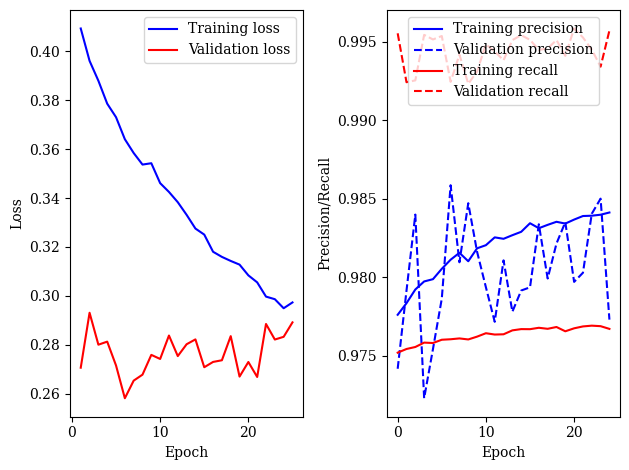

In [26]:
modal.plot_results(maxnorm_res_11_2)

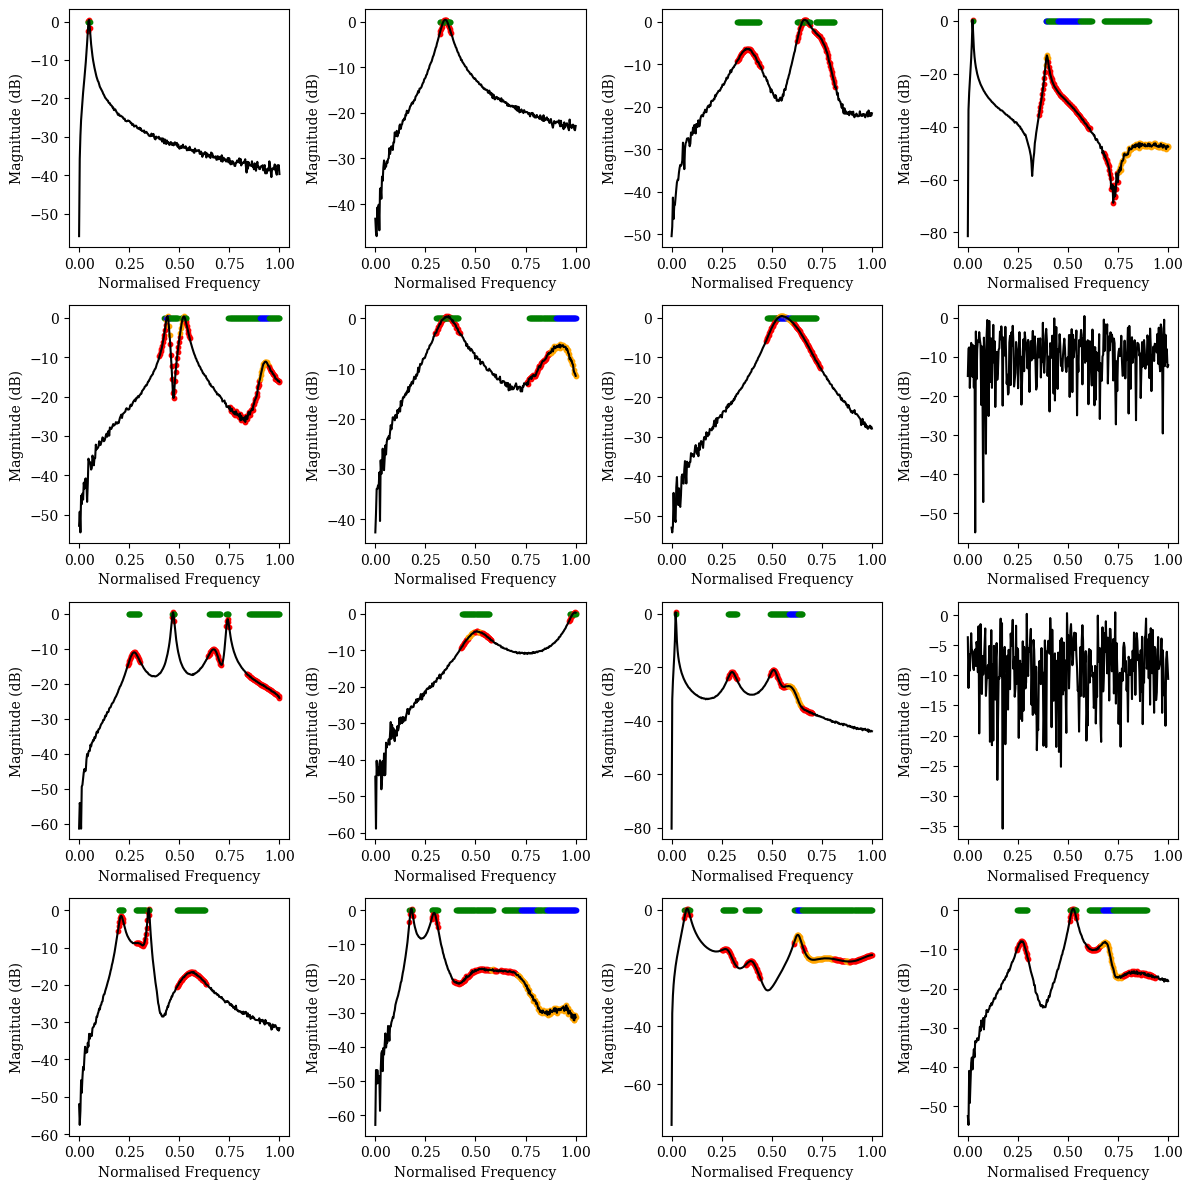

In [29]:
plot_predictions_extended(maxnorm_model_11, num_w_points=300, normalise=None, neg_an=True, multiclass=True, nrows=4, ncols=4, s=10)

## 27/02

### Changed a_n implementation back to before, also allowed a_n to be complex. Implemented log spacing for sampling of zeta (and changed range of zeta)

In [47]:
X, y, _, __ = generate_dat_extended(32*600, 300, multiclass=True, normalise=None, neg_an=True, sigma_max=0.2, a_max=3)
Xval, yval, _, __ = generate_dat_extended(32*100, 300, multiclass=True, normalise=None, neg_an=True, sigma_max=0.2, a_max=3)

In [48]:
maxnorm_model_12 = BiLSTM(input_size=4, hidden_size=125, num_layers=3, num_classes=3)
maxnorm_res_12 = train_model_multiclass(maxnorm_model_12, X, y, Xval, yval, name='norm_95_max(27.02)', num_epochs=75, batch_size=32, device='cpu')

  1%|▏         | 1/75 [06:52<8:28:36, 412.38s/it]

Epoch [1/75], Loss: 0.7766170768936476, Precision: 0.9735705791001537, Recall: 0.9030368022577963
Val Loss: 0.6573580124974251, Validation Precision: 0.9775559029340762, Validation Recall: 0.9111726715193665


  3%|▎         | 2/75 [14:18<8:45:52, 432.22s/it]

Epoch [2/75], Loss: 0.6324649003644784, Precision: 0.9224874784719744, Recall: 0.9362628172283992
Val Loss: 0.49207821756601333, Validation Precision: 0.9536556839993579, Validation Recall: 0.9481789085568108


  4%|▍         | 3/75 [21:51<8:49:48, 441.51s/it]

Epoch [3/75], Loss: 0.5609292289117972, Precision: 0.9349800852268428, Recall: 0.9506504057230009
Val Loss: 0.43515245482325554, Validation Precision: 0.9597439622355952, Validation Recall: 0.9592742071690381


  5%|▌         | 4/75 [29:42<8:56:18, 453.22s/it]

Epoch [4/75], Loss: 0.5245745207369328, Precision: 0.9402888500461796, Recall: 0.9569573679137644
Val Loss: 0.4141066801548004, Validation Precision: 0.9190235378724059, Validation Recall: 0.9754979146984226


  7%|▋         | 5/75 [37:28<8:54:25, 458.08s/it]

Epoch [5/75], Loss: 0.48408495003978413, Precision: 0.9480297999111106, Recall: 0.9630879471699946
Val Loss: 0.3764102676510811, Validation Precision: 0.9718344361030695, Validation Recall: 0.9680426311659356


  8%|▊         | 6/75 [45:17<8:50:46, 461.54s/it]

Epoch [6/75], Loss: 0.45954417551557225, Precision: 0.9536386059391663, Recall: 0.9664525623996019
Val Loss: 0.34134978175163266, Validation Precision: 0.9674347847238915, Validation Recall: 0.9743248391804836


  9%|▉         | 7/75 [53:12<8:48:09, 466.02s/it]

Epoch [7/75], Loss: 0.43838921705881756, Precision: 0.9593233875973637, Recall: 0.9685804825246492
Val Loss: 0.32796348810195924, Validation Precision: 0.9702119217780958, Validation Recall: 0.9761785275415129


 11%|█         | 8/75 [1:01:03<8:42:09, 467.60s/it]

Epoch [8/75], Loss: 0.4276882297048966, Precision: 0.9620386584771495, Recall: 0.9700133634315612
Val Loss: 0.3307866276800632, Validation Precision: 0.9603280908105799, Validation Recall: 0.9794127819627737


 12%|█▏        | 9/75 [1:08:54<8:35:36, 468.74s/it]

Epoch [9/75], Loss: 0.41781230678160985, Precision: 0.964251873031483, Recall: 0.9712221018078165
Val Loss: 0.30255764290690423, Validation Precision: 0.9689978766725116, Validation Recall: 0.9806644170731034


 13%|█▎        | 10/75 [1:16:44<8:28:11, 469.10s/it]

Epoch [10/75], Loss: 0.4078982034077247, Precision: 0.9659802526998148, Recall: 0.972241774262467
Val Loss: 0.2994926802814007, Validation Precision: 0.9802569116869724, Validation Recall: 0.9783190960449721


 15%|█▍        | 11/75 [1:24:33<8:20:20, 469.07s/it]

Epoch [11/75], Loss: 0.4006664747993151, Precision: 0.9678263921620862, Recall: 0.9729236984140687
Val Loss: 0.3032928569614887, Validation Precision: 0.9676844622760831, Validation Recall: 0.9806971869402377


 16%|█▌        | 12/75 [1:32:19<8:11:34, 468.17s/it]

Epoch [12/75], Loss: 0.39121401955684026, Precision: 0.9693815567450392, Recall: 0.9738442756904601
Val Loss: 0.29961974382400514, Validation Precision: 0.9782209606996907, Validation Recall: 0.9789385761250929


 17%|█▋        | 13/75 [1:40:13<8:05:24, 469.75s/it]

Epoch [13/75], Loss: 0.38834592488904796, Precision: 0.9692174177911868, Recall: 0.9741297152986965
Val Loss: 0.28858580335974693, Validation Precision: 0.9653378108026329, Validation Recall: 0.9848352483863282


 19%|█▊        | 14/75 [1:48:00<7:56:55, 469.11s/it]

Epoch [14/75], Loss: 0.3795868460337321, Precision: 0.9713400238784328, Recall: 0.975154284717866
Val Loss: 0.27915575489401817, Validation Precision: 0.9729568439943119, Validation Recall: 0.9839636292819027


 20%|██        | 15/75 [1:55:59<7:52:10, 472.18s/it]

Epoch [15/75], Loss: 0.3754552427927653, Precision: 0.9721440519513366, Recall: 0.975401626155764
Val Loss: 0.31557110354304313, Validation Precision: 0.9466661317705813, Validation Recall: 0.9852520324465861


 21%|██▏       | 16/75 [2:03:46<7:42:37, 470.47s/it]

Epoch [16/75], Loss: 0.3700779779752095, Precision: 0.9721832174129439, Recall: 0.975915158448978
Val Loss: 0.2797282161563635, Validation Precision: 0.9818423817704481, Validation Recall: 0.9812301736488336


 23%|██▎       | 17/75 [2:11:23<7:30:51, 466.40s/it]

Epoch [17/75], Loss: 0.3672243309269349, Precision: 0.9724871644709867, Recall: 0.9760660730159941
Val Loss: 0.2756242980062962, Validation Precision: 0.9760383184317206, Validation Recall: 0.98341810259809


 24%|██▍       | 18/75 [2:47:35<15:29:55, 978.87s/it]

Epoch [18/75], Loss: 0.36016361594200136, Precision: 0.9731826513407157, Recall: 0.9767940192821457
Val Loss: 0.2749458543211222, Validation Precision: 0.9797781092442027, Validation Recall: 0.9824916375202348


 25%|██▌       | 19/75 [2:56:00<13:00:54, 836.69s/it]

Epoch [19/75], Loss: 0.3573246395339568, Precision: 0.9736247168353509, Recall: 0.9769345206557042
Val Loss: 0.28367724165320396, Validation Precision: 0.9761765518332112, Validation Recall: 0.9826407099379889


 27%|██▋       | 20/75 [3:19:57<15:32:12, 1016.95s/it]

Epoch [20/75], Loss: 0.35148563981056213, Precision: 0.974569109057213, Recall: 0.9775421522748725
Val Loss: 0.2692894943058491, Validation Precision: 0.9784610560476118, Validation Recall: 0.9836477679095094


 28%|██▊       | 21/75 [3:52:25<19:26:39, 1296.29s/it]

Epoch [21/75], Loss: 0.3537140271315972, Precision: 0.9740757966892549, Recall: 0.97717849419031
Val Loss: 0.2897857075929642, Validation Precision: 0.959173263727847, Validation Recall: 0.9862638902574343


 29%|██▉       | 22/75 [4:02:07<15:55:47, 1082.03s/it]

Epoch [22/75], Loss: 0.3467971412092447, Precision: 0.9746839582187028, Recall: 0.9777687906322712
Val Loss: 0.26913190133869647, Validation Precision: 0.9744659774296959, Validation Recall: 0.9863375401498007


 31%|███       | 23/75 [4:54:46<24:37:48, 1705.16s/it]

Epoch [23/75], Loss: 0.3406834461043278, Precision: 0.975535416074073, Recall: 0.9782626124050751
Val Loss: 0.2702529235929251, Validation Precision: 0.9752892303571541, Validation Recall: 0.9853064367086187


 32%|███▏      | 24/75 [5:03:40<19:10:39, 1353.72s/it]

Epoch [24/75], Loss: 0.33419804150859517, Precision: 0.9762125599999065, Recall: 0.9787317297072877
Val Loss: 0.2738021293282509, Validation Precision: 0.9803730187149085, Validation Recall: 0.9841604450680366


 33%|███▎      | 25/75 [5:48:50<24:27:22, 1760.86s/it]

Epoch [25/75], Loss: 0.3324749565621217, Precision: 0.9759106799510747, Recall: 0.9788684390411488
Val Loss: 0.2678618334978819, Validation Precision: 0.9762200124277126, Validation Recall: 0.9851304355032329


 35%|███▍      | 26/75 [5:58:00<19:01:14, 1397.43s/it]

Epoch [26/75], Loss: 0.328970880980293, Precision: 0.9761769311811834, Recall: 0.9790556484917176
Val Loss: 0.2694307105988264, Validation Precision: 0.9807177951514983, Validation Recall: 0.9842202652787251


 36%|███▌      | 27/75 [6:46:34<24:42:03, 1852.58s/it]

Epoch [27/75], Loss: 0.32383764567474527, Precision: 0.9767378104016124, Recall: 0.9794162382337336
Val Loss: 0.26620767891407016, Validation Precision: 0.975186021977654, Validation Recall: 0.9862861482781138


 37%|███▋      | 28/75 [6:54:22<18:45:39, 1437.02s/it]

Epoch [28/75], Loss: 0.32131470734874407, Precision: 0.9769008551515367, Recall: 0.9797977798720033
Val Loss: 0.2665641607344151, Validation Precision: 0.973141750369551, Validation Recall: 0.9866606517538138


 39%|███▊      | 29/75 [7:01:52<14:34:47, 1141.03s/it]

Epoch [29/75], Loss: 0.3159164649248123, Precision: 0.9765336233978424, Recall: 0.9798153140677941
Val Loss: 0.2699531466513872, Validation Precision: 0.9805383858464787, Validation Recall: 0.9849541452666046


 40%|████      | 30/75 [7:09:24<11:40:38, 934.19s/it] 

Epoch [30/75], Loss: 0.31174457309146725, Precision: 0.9773014933373052, Recall: 0.98025293173367
Val Loss: 0.2768469672650099, Validation Precision: 0.9796959826291642, Validation Recall: 0.9847003985270326


 41%|████▏     | 31/75 [7:16:50<9:37:36, 787.64s/it] 

Epoch [31/75], Loss: 0.3077147495001554, Precision: 0.9773813729539108, Recall: 0.9802560887120602
Val Loss: 0.27512710824608805, Validation Precision: 0.9786913268057539, Validation Recall: 0.9853290375339272


 43%|████▎     | 32/75 [7:24:19<8:11:47, 686.21s/it]

Epoch [32/75], Loss: 0.3051425028840701, Precision: 0.9775018185891239, Recall: 0.9806522218268549
Val Loss: 0.2790721562504768, Validation Precision: 0.9761103433023542, Validation Recall: 0.985506811469396


 44%|████▍     | 33/75 [7:32:02<7:13:27, 619.23s/it]

Epoch [33/75], Loss: 0.30458315670490266, Precision: 0.9772394831266189, Recall: 0.9806493117845584
Val Loss: 0.27557590544223787, Validation Precision: 0.9792509339483912, Validation Recall: 0.9854575406255868


 45%|████▌     | 34/75 [7:39:44<6:30:53, 572.03s/it]

Epoch [34/75], Loss: 0.29396608014901476, Precision: 0.9785782881834041, Recall: 0.9813087591693112
Val Loss: 0.29802246026694773, Validation Precision: 0.9764091686105975, Validation Recall: 0.9859476901763554


 47%|████▋     | 35/75 [7:47:12<5:56:29, 534.73s/it]

Epoch [35/75], Loss: 0.2959064933905999, Precision: 0.9778770161085644, Recall: 0.9811559975202151
Val Loss: 0.2876454383134842, Validation Precision: 0.9808393889081616, Validation Recall: 0.9840390835544202


 48%|████▊     | 36/75 [7:54:51<5:32:50, 512.06s/it]

Epoch [36/75], Loss: 0.2886638344079256, Precision: 0.9786802656477156, Recall: 0.9814894289974613
Val Loss: 0.31106031440198423, Validation Precision: 0.9796625608090391, Validation Recall: 0.9847671494136171


 49%|████▉     | 37/75 [8:02:29<5:14:05, 495.93s/it]

Epoch [37/75], Loss: 0.2880493961274624, Precision: 0.9781757023481125, Recall: 0.981484946585649
Val Loss: 0.29239770032465456, Validation Precision: 0.9818120908945432, Validation Recall: 0.9849876730223247


 51%|█████     | 38/75 [8:09:54<4:56:21, 480.57s/it]

Epoch [38/75], Loss: 0.2792560452967882, Precision: 0.9790422614104463, Recall: 0.9820831683382
Val Loss: 0.29420448035001756, Validation Precision: 0.9779856765883713, Validation Recall: 0.9858816694618281


 52%|█████▏    | 39/75 [8:17:19<4:41:59, 469.98s/it]

Epoch [39/75], Loss: 0.2799279887229204, Precision: 0.9788291955622662, Recall: 0.9821209069353635
Val Loss: 0.2880647356808186, Validation Precision: 0.9698552028692907, Validation Recall: 0.987710021298689


 53%|█████▎    | 40/75 [8:24:43<4:29:35, 462.15s/it]

Epoch [40/75], Loss: 0.27831961755951246, Precision: 0.97902087511871, Recall: 0.9819121597530214
Val Loss: 0.3056642150133848, Validation Precision: 0.9715897518232357, Validation Recall: 0.9871748022685147


 55%|█████▍    | 41/75 [8:32:09<4:19:11, 457.39s/it]

Epoch [41/75], Loss: 0.2720237681766351, Precision: 0.9795489065708916, Recall: 0.9824822382307936
Val Loss: 0.30623385079205034, Validation Precision: 0.9749545466290996, Validation Recall: 0.9866777627938477


 56%|█████▌    | 42/75 [8:39:45<4:11:16, 456.87s/it]

Epoch [42/75], Loss: 0.2681310715526342, Precision: 0.9798091979048468, Recall: 0.9826400934783197
Val Loss: 0.3116578114777803, Validation Precision: 0.9772729933481363, Validation Recall: 0.9860829848431436


 57%|█████▋    | 43/75 [8:47:03<4:00:42, 451.32s/it]

Epoch [43/75], Loss: 0.265882506420215, Precision: 0.980076352877713, Recall: 0.9828279219616314
Val Loss: 0.3198425780981779, Validation Precision: 0.9752570156558815, Validation Recall: 0.9866316061011235


 59%|█████▊    | 44/75 [8:54:29<3:52:20, 449.68s/it]

Epoch [44/75], Loss: 0.2632818714777629, Precision: 0.9802829157002537, Recall: 0.9828889270054071
Val Loss: 0.32255208276212216, Validation Precision: 0.9788379142777169, Validation Recall: 0.9854626737220771


 60%|██████    | 45/75 [9:02:05<3:45:45, 451.52s/it]

Epoch [45/75], Loss: 0.25926293844978016, Precision: 0.980355792323211, Recall: 0.9831283586880185
Val Loss: 0.31943091832101345, Validation Precision: 0.9756041723458962, Validation Recall: 0.9862728184314413


 61%|██████▏   | 46/75 [9:09:56<3:41:04, 457.40s/it]

Epoch [46/75], Loss: 0.254900085652868, Precision: 0.9809448724723493, Recall: 0.9835152283306473
Val Loss: 0.31103770539164544, Validation Precision: 0.9751789401451219, Validation Recall: 0.9870181833750952


 63%|██████▎   | 47/75 [9:17:24<3:32:09, 454.63s/it]

Epoch [47/75], Loss: 0.2560876661042372, Precision: 0.9805129587784012, Recall: 0.9834260554002043
Val Loss: 0.3272120966762304, Validation Precision: 0.9731803041967504, Validation Recall: 0.986441214124381


 64%|██████▍   | 48/75 [9:24:52<3:23:41, 452.64s/it]

Epoch [48/75], Loss: 0.25599284363289676, Precision: 0.9806328642815045, Recall: 0.9834569851819303
Val Loss: 0.34254018433392047, Validation Precision: 0.9818174991888658, Validation Recall: 0.9843630028655497


 65%|██████▌   | 49/75 [9:32:23<3:15:54, 452.11s/it]

Epoch [49/75], Loss: 0.2576108198116223, Precision: 0.9806558565787471, Recall: 0.9832383584755422
Val Loss: 0.3367488665878773, Validation Precision: 0.9806672099321068, Validation Recall: 0.9855627153027678


 67%|██████▋   | 50/75 [9:39:50<3:07:40, 450.44s/it]

Epoch [50/75], Loss: 0.2450372452288866, Precision: 0.9817740262816324, Recall: 0.9838923883352166
Val Loss: 0.32887002401053905, Validation Precision: 0.9768342398582911, Validation Recall: 0.9862656946971101


 68%|██████▊   | 51/75 [9:47:36<3:02:06, 455.25s/it]

Epoch [51/75], Loss: 0.24562216674288115, Precision: 0.9816790175549206, Recall: 0.9838130910973524
Val Loss: 0.3213797362148762, Validation Precision: 0.975672631845526, Validation Recall: 0.9867201282043147


 69%|██████▉   | 52/75 [9:55:01<2:53:20, 452.18s/it]

Epoch [52/75], Loss: 0.2432589666545391, Precision: 0.9818755674812217, Recall: 0.9841036006407997
Val Loss: 0.3435801877081394, Validation Precision: 0.9788199188885627, Validation Recall: 0.9850774579143053


 71%|███████   | 53/75 [10:02:47<2:47:18, 456.28s/it]

Epoch [53/75], Loss: 0.2361435768008232, Precision: 0.9826007143648242, Recall: 0.9846040097290029
Val Loss: 0.34777875177562234, Validation Precision: 0.9766256681173674, Validation Recall: 0.9866093727425047


 72%|███████▏  | 54/75 [10:10:12<2:38:28, 452.77s/it]

Epoch [54/75], Loss: 0.23935929988821347, Precision: 0.9822423088055369, Recall: 0.9843310292916889
Val Loss: 0.352399537563324, Validation Precision: 0.976625679726503, Validation Recall: 0.9859769810395265


 73%|███████▎  | 55/75 [10:17:33<2:29:49, 449.46s/it]

Epoch [55/75], Loss: 0.23889814575513205, Precision: 0.982388983918889, Recall: 0.9843605958410152
Val Loss: 0.35068190202116967, Validation Precision: 0.9786697449668895, Validation Recall: 0.9858113838122768


 75%|███████▍  | 56/75 [10:25:17<2:23:40, 453.69s/it]

Epoch [56/75], Loss: 0.2311811679104964, Precision: 0.9832337480975311, Recall: 0.9847886933860197
Val Loss: 0.3547646174579859, Validation Precision: 0.9781888703551763, Validation Recall: 0.9863652924601821


 76%|███████▌  | 57/75 [10:32:56<2:16:35, 455.30s/it]

Epoch [57/75], Loss: 0.25266258264581365, Precision: 0.9810940895118944, Recall: 0.9836873026922276
Val Loss: 0.3489563350379467, Validation Precision: 0.9822144769183113, Validation Recall: 0.9852610748538353


 77%|███████▋  | 58/75 [10:40:24<2:08:22, 453.06s/it]

Epoch [58/75], Loss: 0.23360732786357402, Precision: 0.9828516142515457, Recall: 0.9845396944896015
Val Loss: 0.3555676706135273, Validation Precision: 0.9809612765805611, Validation Recall: 0.9851526803418943


 79%|███████▊  | 59/75 [10:47:49<2:00:11, 450.73s/it]

Epoch [59/75], Loss: 0.23087202293177445, Precision: 0.983357760730157, Recall: 0.9848433895913897
Val Loss: 0.3625664972513914, Validation Precision: 0.9783855848563902, Validation Recall: 0.9861844780525864


 80%|████████  | 60/75 [10:55:09<1:51:53, 447.56s/it]

Epoch [60/75], Loss: 0.22924529301623503, Precision: 0.9833300369057548, Recall: 0.984968413418024
Val Loss: 0.3751949772238731, Validation Precision: 0.979904373938343, Validation Recall: 0.9846562907500289


 81%|████████▏ | 61/75 [11:02:41<1:44:44, 448.87s/it]

Epoch [61/75], Loss: 0.2303005086630583, Precision: 0.9830995015889719, Recall: 0.9847974661090431
Val Loss: 0.3709811405092478, Validation Precision: 0.9735377034865428, Validation Recall: 0.9861983690062975


 83%|████████▎ | 62/75 [11:10:17<1:37:40, 450.83s/it]

Epoch [62/75], Loss: 0.2265722910563151, Precision: 0.9834885891613122, Recall: 0.9851307652535884
Val Loss: 0.367582932561636, Validation Precision: 0.9805774626742371, Validation Recall: 0.985111746633942


 84%|████████▍ | 63/75 [11:17:47<1:30:09, 450.79s/it]

Epoch [63/75], Loss: 0.22277637672921022, Precision: 0.9841007109040136, Recall: 0.9852302089379372
Val Loss: 0.3852527540922165, Validation Precision: 0.9791100293857252, Validation Recall: 0.9859623740828867


 85%|████████▌ | 64/75 [11:25:29<1:23:14, 454.05s/it]

Epoch [64/75], Loss: 0.21897690184414387, Precision: 0.9843971374780267, Recall: 0.985436359649409
Val Loss: 0.39524762384593487, Validation Precision: 0.9828191196711703, Validation Recall: 0.985048458189162


 87%|████████▋ | 65/75 [11:33:16<1:16:20, 458.07s/it]

Epoch [65/75], Loss: 0.21493541759749255, Precision: 0.9848923804287574, Recall: 0.9856846313054107
Val Loss: 0.40537624172866343, Validation Precision: 0.9850917411565835, Validation Recall: 0.9841804289375298


 88%|████████▊ | 66/75 [11:40:33<1:07:44, 451.63s/it]

Epoch [66/75], Loss: 0.21887299545109273, Precision: 0.9843672500004365, Recall: 0.9855783727294956
Val Loss: 0.3735430773347616, Validation Precision: 0.9822322367256507, Validation Recall: 0.9853696822895729


 89%|████████▉ | 67/75 [11:47:49<59:36, 447.04s/it]  

Epoch [67/75], Loss: 0.2192320227374633, Precision: 0.9845437725127972, Recall: 0.9854701007759564
Val Loss: 0.3783598528057337, Validation Precision: 0.9790270758879687, Validation Recall: 0.9860724159934843


 91%|█████████ | 68/75 [11:55:19<52:15, 447.94s/it]

Epoch [68/75], Loss: 0.22046189847091835, Precision: 0.984220020800895, Recall: 0.9853877518553442
Val Loss: 0.39684878453612327, Validation Precision: 0.9815236522941571, Validation Recall: 0.9852961006287241


 92%|█████████▏| 69/75 [12:03:00<45:11, 451.87s/it]

Epoch [69/75], Loss: 0.21796474687755107, Precision: 0.9845060910287773, Recall: 0.9854904516965507
Val Loss: 0.37673389963805676, Validation Precision: 0.980584582326179, Validation Recall: 0.9853585238662617


 93%|█████████▎| 70/75 [12:10:38<37:48, 453.61s/it]

Epoch [70/75], Loss: 0.21431124560534953, Precision: 0.9851469594870036, Recall: 0.9858635081912447
Val Loss: 0.3952378875762224, Validation Precision: 0.9811948883127137, Validation Recall: 0.9855603578394024


 95%|█████████▍| 71/75 [12:18:08<30:09, 452.47s/it]

Epoch [71/75], Loss: 0.21663147307932376, Precision: 0.9846444268317385, Recall: 0.985634250246999
Val Loss: 0.3742441591620445, Validation Precision: 0.9805561604633692, Validation Recall: 0.9860382043793439


 96%|█████████▌| 72/75 [12:25:34<22:31, 450.43s/it]

Epoch [72/75], Loss: 0.21269450026253858, Precision: 0.985041125221786, Recall: 0.9858594489090924
Val Loss: 0.38493845537304877, Validation Precision: 0.9824702516897789, Validation Recall: 0.9851598200689169


 97%|█████████▋| 73/75 [12:33:00<14:58, 449.33s/it]

Epoch [73/75], Loss: 0.20840075319012005, Precision: 0.9856989348632784, Recall: 0.9860950395961832
Val Loss: 0.37491736829280853, Validation Precision: 0.9781032526802513, Validation Recall: 0.985594332380151


 99%|█████████▊| 74/75 [12:40:29<07:29, 449.02s/it]

Epoch [74/75], Loss: 0.21537031079332034, Precision: 0.9848390625086535, Recall: 0.9854625044502626
Val Loss: 0.38164710491895676, Validation Precision: 0.9823371974430702, Validation Recall: 0.985426215857742


100%|██████████| 75/75 [12:47:45<00:00, 614.21s/it]

Epoch [75/75], Loss: 0.2111430707325538, Precision: 0.985368441082128, Recall: 0.9858787833933824
Val Loss: 0.3843179815262556, Validation Precision: 0.979202251541152, Validation Recall: 0.9866348369880754


In [51]:
# print number of model parameters
print(sum(p.numel() for p in maxnorm_model_12.parameters() if p.requires_grad))

885753


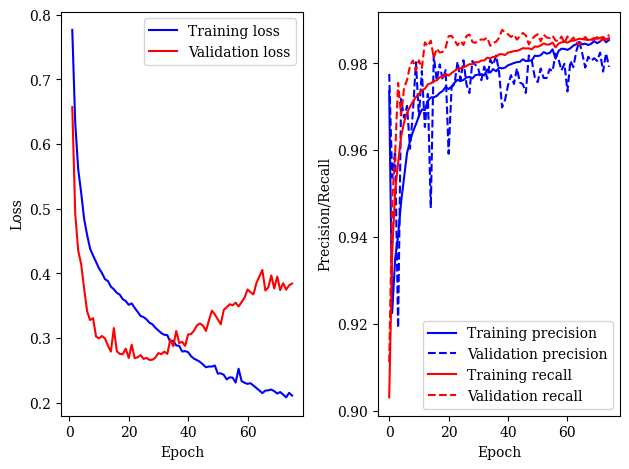

In [49]:
modal.plot_results(maxnorm_res_12)

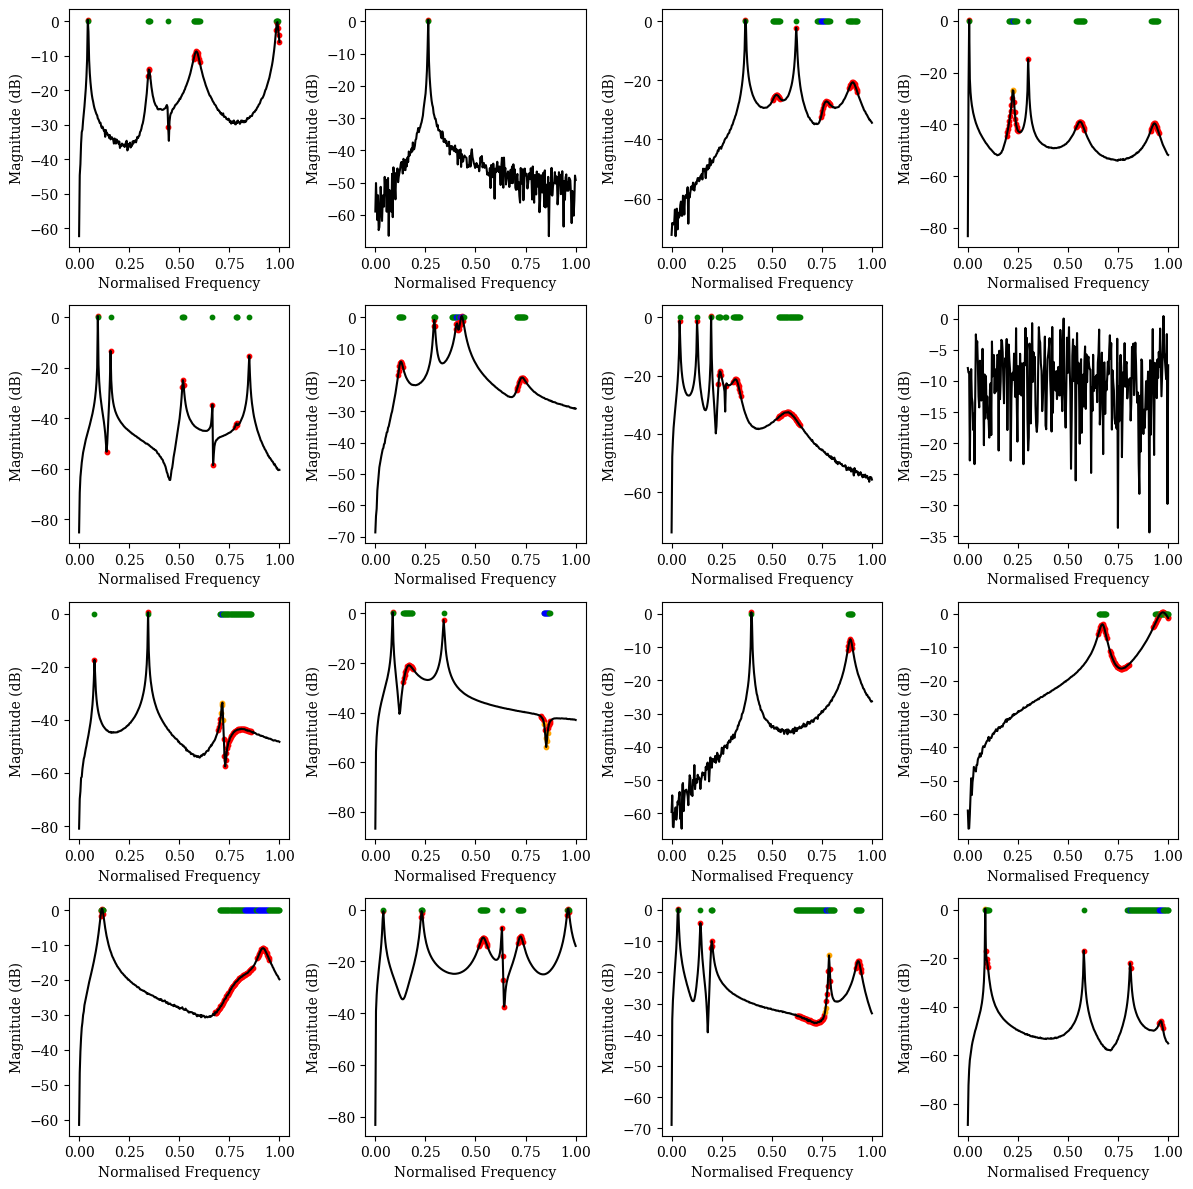

In [50]:
plot_predictions_extended(maxnorm_model_12, num_w_points=300, normalise=None, neg_an=True, multiclass=True, nrows=4, ncols=4, s=10)

### Same model but for fewer epochs to prevent overfitting (don't know why early stopping didnt work in previous test)

In [53]:
maxnorm_model_13 = BiLSTM(input_size=4, hidden_size=125, num_layers=3, num_classes=3)
maxnorm_res_13 = train_model_multiclass(maxnorm_model_13, X, y, Xval, yval, name='norm_95_max(28.02)', num_epochs=30, batch_size=32, device='cpu')

  0%|          | 0/30 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [56]:
maxnorm_model_13 = torch.load('norm_95_max(28.02).pth')

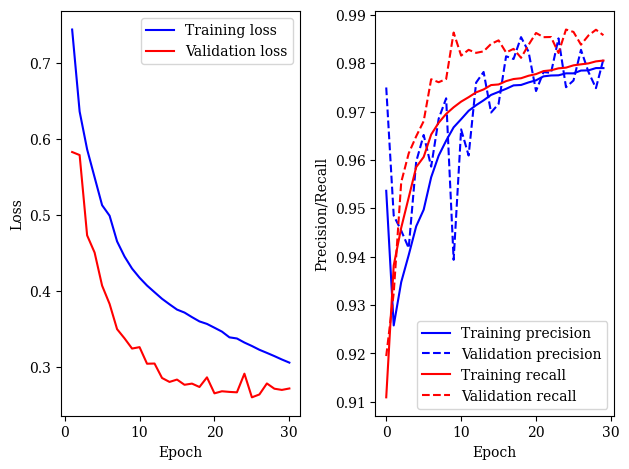

In [54]:
modal.plot_results(maxnorm_res_13)

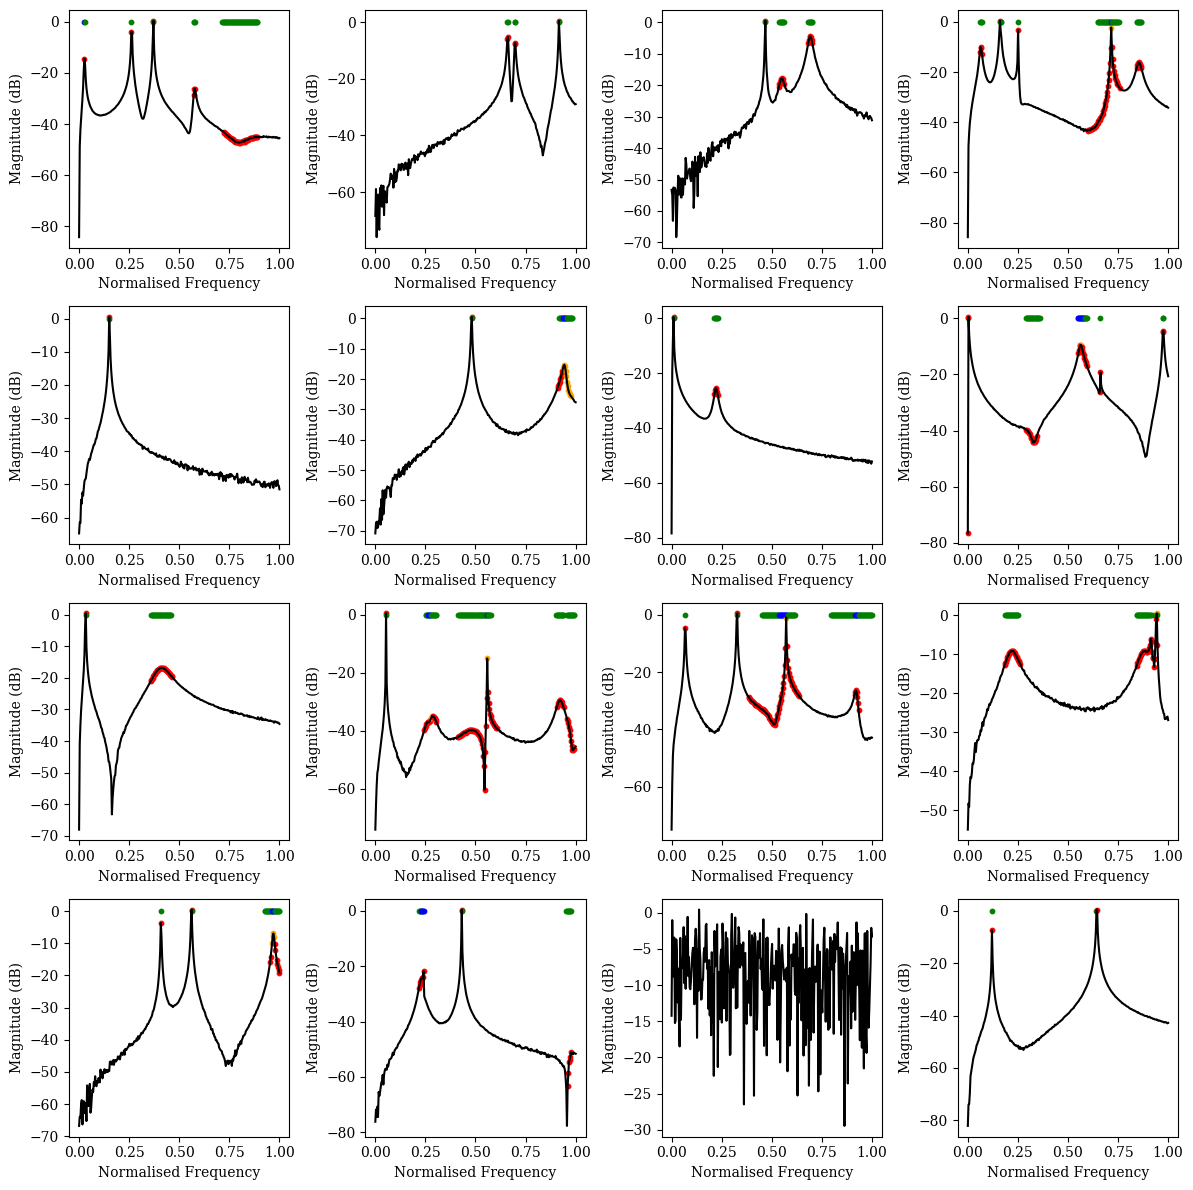

In [59]:
plot_predictions_extended(maxnorm_model_13, num_w_points=300, normalise=None, neg_an=True, multiclass=True, nrows=4, ncols=4, s=10)

## 07/03

### Train new model with longer sequences to try improve predictive performance on noisy data (spikes)

In [13]:
X, y, _, __ = generate_dat_extended(32*450, 400, multiclass=True, normalise=None, neg_an=True, sigma_max=0.2, a_max=3)
Xval, yval, _, __ = generate_dat_extended(32*100, 400, multiclass=True, normalise=None, neg_an=True, sigma_max=0.2, a_max=3)

In [14]:
maxnorm_model_14 = BiLSTM(input_size=4, hidden_size=125, num_layers=3, num_classes=3)
maxnorm_res_14 = train_model_multiclass(maxnorm_model_14, X, y, Xval, yval, name='norm_95_max(07.03)', num_epochs=30, batch_size=32, device='cpu')

  3%|▎         | 1/30 [07:40<3:42:23, 460.12s/it]

Epoch [1/30], Loss: 0.7518182094891867, Precision: 0.9532928475102341, Recall: 0.9134154740099494
Val Loss: 0.622658174932003, Validation Precision: 0.9072336806056072, Validation Recall: 0.9384942309971737


  7%|▋         | 2/30 [15:40<3:40:09, 471.78s/it]

Epoch [2/30], Loss: 0.6681009746922387, Precision: 0.9264211000446149, Recall: 0.9324903848754283
Val Loss: 0.5520320305228233, Validation Precision: 0.9314445535816493, Validation Recall: 0.9437114425048927


 10%|█         | 3/30 [23:37<3:33:25, 474.27s/it]

Epoch [3/30], Loss: 0.6218951635890537, Precision: 0.930850748392664, Recall: 0.9398217566682616
Val Loss: 0.5269769692420959, Validation Precision: 0.9557452326378411, Validation Recall: 0.9439230753406187


 13%|█▎        | 4/30 [31:40<3:27:01, 477.75s/it]

Epoch [4/30], Loss: 0.5969216336806615, Precision: 0.9361819741018742, Recall: 0.9448569238112488
Val Loss: 0.5023195984959602, Validation Precision: 0.9519225746605983, Validation Recall: 0.947653261229366


 17%|█▋        | 5/30 [39:44<3:19:57, 479.92s/it]

Epoch [5/30], Loss: 0.5680917133887609, Precision: 0.9402444305523712, Recall: 0.9496133493227077
Val Loss: 0.4697012737393379, Validation Precision: 0.9394432483983488, Validation Recall: 0.9588793911844056


 20%|██        | 6/30 [47:29<3:10:01, 475.07s/it]

Epoch [6/30], Loss: 0.5513760848840078, Precision: 0.9438686584068874, Recall: 0.9518082246914444
Val Loss: 0.46045754313468934, Validation Precision: 0.9550115176751903, Validation Recall: 0.9532915444096071


 23%|██▎       | 7/30 [55:17<3:01:07, 472.52s/it]

Epoch [7/30], Loss: 0.5391591803232829, Precision: 0.9461116149902923, Recall: 0.9541019781020793
Val Loss: 0.44556299567222596, Validation Precision: 0.9544978901073532, Validation Recall: 0.9581313251671328


 27%|██▋       | 8/30 [1:03:02<2:52:26, 470.29s/it]

Epoch [8/30], Loss: 0.5257300191455417, Precision: 0.948603625580624, Recall: 0.9560477234817627
Val Loss: 0.4313857451081276, Validation Precision: 0.9564637027916535, Validation Recall: 0.9596459754408475


 30%|███       | 9/30 [1:10:51<2:44:30, 470.00s/it]

Epoch [9/30], Loss: 0.5168503043386671, Precision: 0.951364394313155, Recall: 0.9570114476402657
Val Loss: 0.4248495626449585, Validation Precision: 0.9601280211222298, Validation Recall: 0.9591640522822474


 33%|███▎      | 10/30 [1:18:33<2:35:47, 467.39s/it]

Epoch [10/30], Loss: 0.5164495675431358, Precision: 0.9516281573872702, Recall: 0.9573491068508602
Val Loss: 0.4169693464040756, Validation Precision: 0.97083420186974, Validation Recall: 0.9581029974625099


 37%|███▋      | 11/30 [1:26:00<2:26:02, 461.16s/it]

Epoch [11/30], Loss: 0.5006106860107846, Precision: 0.9540598954462756, Recall: 0.959699549030974
Val Loss: 0.40721333980560304, Validation Precision: 0.9533499954857926, Validation Recall: 0.9658086074223597


 40%|████      | 12/30 [1:40:04<2:53:17, 577.62s/it]

Epoch [12/30], Loss: 0.4908098731438319, Precision: 0.9557780457738461, Recall: 0.9609626692487571
Val Loss: 0.4070994457602501, Validation Precision: 0.9472130608845996, Validation Recall: 0.9670198710602204


 43%|████▎     | 13/30 [2:43:50<7:22:28, 1561.68s/it]

Epoch [13/30], Loss: 0.48410431338681115, Precision: 0.9575123445883033, Recall: 0.9618477651249596
Val Loss: 0.39141364306211474, Validation Precision: 0.9512621684968142, Validation Recall: 0.96941350618442


 47%|████▋     | 14/30 [2:52:19<5:31:39, 1243.72s/it]

Epoch [14/30], Loss: 0.4743983832332823, Precision: 0.9585640290023043, Recall: 0.9632480665869247
Val Loss: 0.3786775353550911, Validation Precision: 0.9652544718805527, Validation Recall: 0.967363012451271


 50%|█████     | 15/30 [3:00:20<4:13:28, 1013.93s/it]

Epoch [15/30], Loss: 0.4669172576400969, Precision: 0.9596915822082395, Recall: 0.9644753392489641
Val Loss: 0.37618002861738203, Validation Precision: 0.9641283427173868, Validation Recall: 0.9683241806710926


 53%|█████▎    | 16/30 [3:08:37<3:20:16, 858.29s/it] 

Epoch [16/30], Loss: 0.46024942961004045, Precision: 0.9604512139766762, Recall: 0.9652878730211891
Val Loss: 0.3708046963810921, Validation Precision: 0.9630030490521361, Validation Recall: 0.9701045086304585


 57%|█████▋    | 17/30 [3:16:48<2:42:02, 747.87s/it]

Epoch [17/30], Loss: 0.45238639467292363, Precision: 0.9610131053068494, Recall: 0.9662445646262896
Val Loss: 0.36766742408275604, Validation Precision: 0.9569851469721283, Validation Recall: 0.9719393440211581


 60%|██████    | 18/30 [3:24:56<2:13:56, 669.73s/it]

Epoch [18/30], Loss: 0.44957087794939676, Precision: 0.9609132592299151, Recall: 0.9668673863196742
Val Loss: 0.3685117706656456, Validation Precision: 0.9667646595759785, Validation Recall: 0.9685541907519819


 63%|██████▎   | 19/30 [3:32:53<1:52:10, 611.82s/it]

Epoch [19/30], Loss: 0.44210402290026346, Precision: 0.9631069707958636, Recall: 0.9676367505997912
Val Loss: 0.35723651707172394, Validation Precision: 0.9603906887340697, Validation Recall: 0.9728236966876314


 67%|██████▋   | 20/30 [3:40:54<1:35:25, 572.51s/it]

Epoch [20/30], Loss: 0.43535306062963275, Precision: 0.9629873362891781, Recall: 0.9685792595759153
Val Loss: 0.3529488441348076, Validation Precision: 0.9645529895901691, Validation Recall: 0.9727660410737723


 70%|███████   | 21/30 [3:49:03<1:22:07, 547.55s/it]

Epoch [21/30], Loss: 0.4302271039618386, Precision: 0.963705993543407, Recall: 0.9691404355732619
Val Loss: 0.351329508125782, Validation Precision: 0.9584634307412137, Validation Recall: 0.9744166436169595


 73%|███████▎  | 22/30 [3:57:14<1:10:42, 530.37s/it]

Epoch [22/30], Loss: 0.42368317584196724, Precision: 0.9644407240141396, Recall: 0.9699837540725291
Val Loss: 0.35265798687934874, Validation Precision: 0.9734187718815943, Validation Recall: 0.9696586735723303


 77%|███████▋  | 23/30 [4:05:15<1:00:09, 515.69s/it]

Epoch [23/30], Loss: 0.4202839324871699, Precision: 0.9645647968935035, Recall: 0.9700575942803724
Val Loss: 0.3517868290841579, Validation Precision: 0.9531844002610154, Validation Recall: 0.9766141653231556


 80%|████████  | 24/30 [4:13:18<50:35, 505.84s/it]  

Epoch [24/30], Loss: 0.4143181797530916, Precision: 0.9648925379375618, Recall: 0.970912417359751
Val Loss: 0.35401233583688735, Validation Precision: 0.9752031589373957, Validation Recall: 0.9696275170101789


 83%|████████▎ | 25/30 [4:21:26<41:42, 500.55s/it]

Epoch [25/30], Loss: 0.40972122463915084, Precision: 0.9656991531162724, Recall: 0.9711301665603078
Val Loss: 0.35235432639718056, Validation Precision: 0.9714877867014536, Validation Recall: 0.971981217954831


 87%|████████▋ | 26/30 [4:29:28<33:00, 495.03s/it]

Epoch [26/30], Loss: 0.4018277284502983, Precision: 0.9664369384421416, Recall: 0.9720723415307932
Val Loss: 0.3559860868752003, Validation Precision: 0.9626878174086699, Validation Recall: 0.9741898787187838


 90%|█████████ | 27/30 [4:37:36<24:38, 492.71s/it]

Epoch [27/30], Loss: 0.39805683109495377, Precision: 0.9668408534944603, Recall: 0.9724629547582901
Val Loss: 0.34783307552337644, Validation Precision: 0.9696900405094473, Validation Recall: 0.973789731716386


 93%|█████████▎| 28/30 [4:45:54<16:28, 494.28s/it]

Epoch [28/30], Loss: 0.3925899150636461, Precision: 0.9674122183717805, Recall: 0.9729694522032879
Val Loss: 0.34571554005146027, Validation Precision: 0.969563198514815, Validation Recall: 0.9737538899383068


 97%|█████████▋| 29/30 [4:54:01<08:12, 492.23s/it]

Epoch [29/30], Loss: 0.38846147239208223, Precision: 0.9670765104771044, Recall: 0.9733089357218898
Val Loss: 0.349988631606102, Validation Precision: 0.9712808089687023, Validation Recall: 0.9733238966467884


100%|██████████| 30/30 [5:02:11<00:00, 604.40s/it]

Epoch [30/30], Loss: 0.3888087559408612, Precision: 0.9670512942960945, Recall: 0.9733406770181019
Val Loss: 0.3473670007288456, Validation Precision: 0.9648459033755091, Validation Recall: 0.9749607478743504


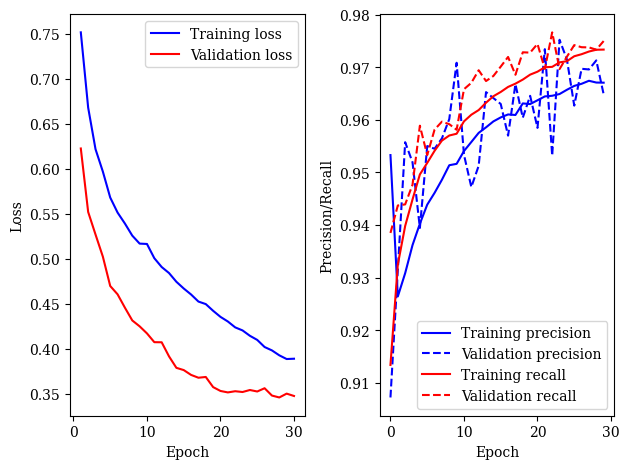

In [15]:
modal.plot_results(maxnorm_res_14)

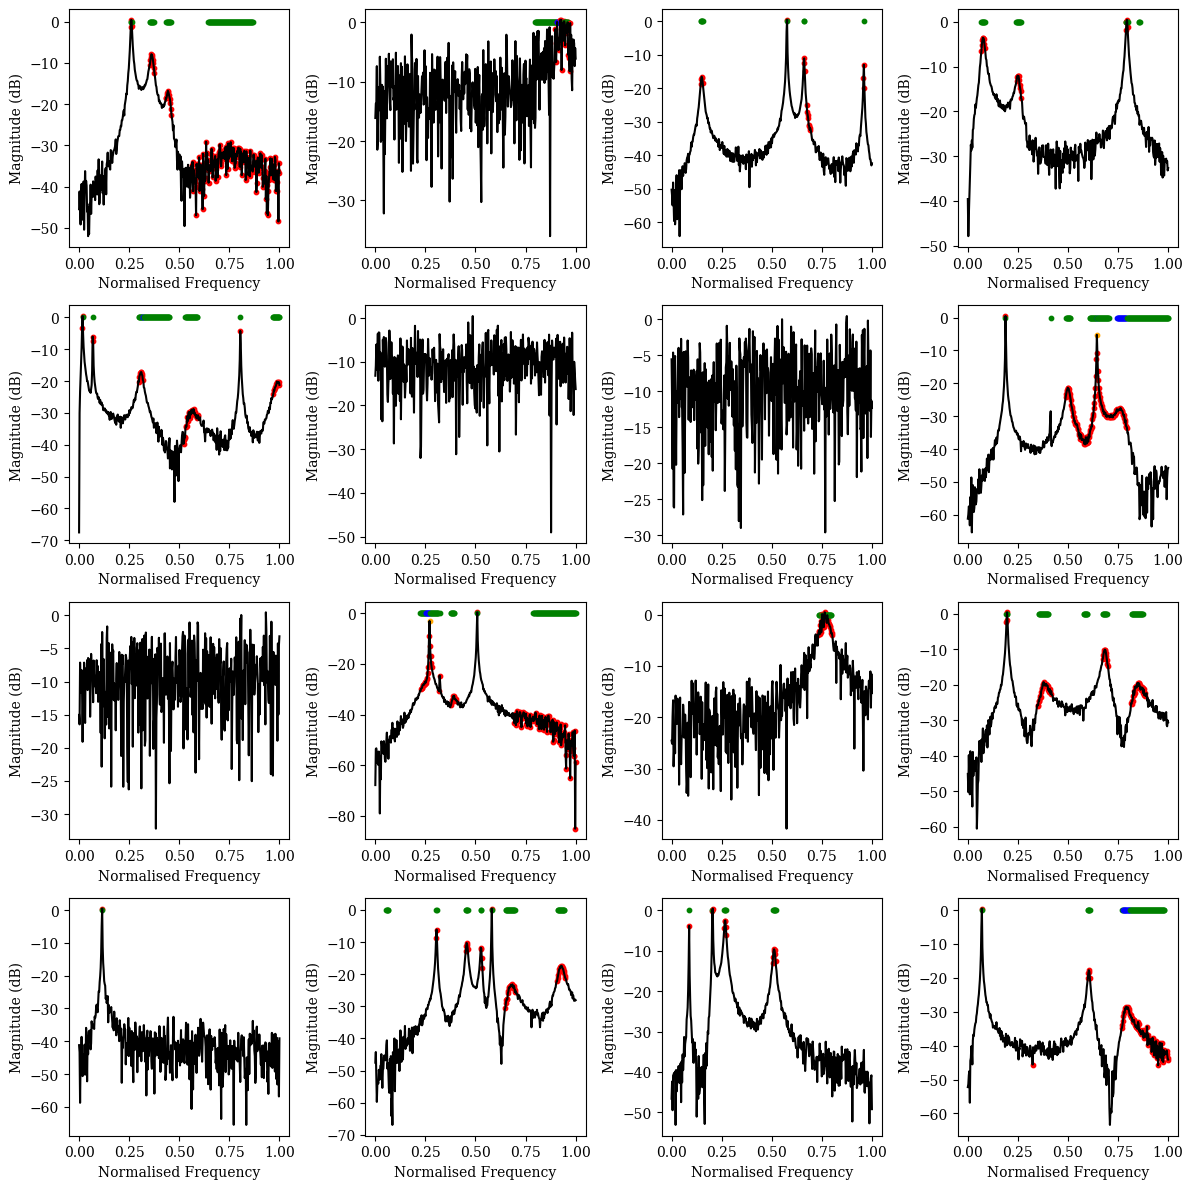

In [19]:
plot_predictions_extended(maxnorm_model_14, num_w_points=400, normalise=None, neg_an=True, multiclass=True, nrows=4, ncols=4, s=10)

## 15/05

In [16]:
class BiLSTM_larger(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        # calls parent class constructor
        super(BiLSTM_larger, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=0.1)
        # hidden_size * 2 because we are using a bidirectional RNN (double the length of the hidden state)
        self.fc = nn.Linear(hidden_size*2, hidden_size*2)
        self.fc2 = nn.Linear(hidden_size*2, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(0.1)
        # self.bn = nn.BatchNorm1d(hidden_size*2)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        # out = out.permute(0, 2, 1)
        # out = self.bn(out)
        # sequence-to-sequence classification problem where you want to classify each time step in the sequence independently.
        # Pass each time step's output through a fully connected layer
        out = self.fc(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.dropout(out)
        return out

In [18]:
X, y, _, __ = generate_dat_extended(32*525, 300, multiclass=True, normalise=None, neg_an=True, sigma_max=0.20, a_max=2.8)
Xval, yval, _, __ = generate_dat_extended(32*100, 300, multiclass=True, normalise=None, neg_an=True, sigma_max=0.2, a_max=2.8)

In [22]:
maxnorm_model_15 = BiLSTM_larger(input_size=4, hidden_size=125, num_layers=3, num_classes=3)
maxnorm_res_15 = train_model_multiclass(maxnorm_model_15, X, y, Xval, yval, name='norm_95_max(15.05)', num_epochs=30, batch_size=32, device='cpu')

  0%|          | 0/30 [00:05<?, ?it/s]


KeyboardInterrupt: 

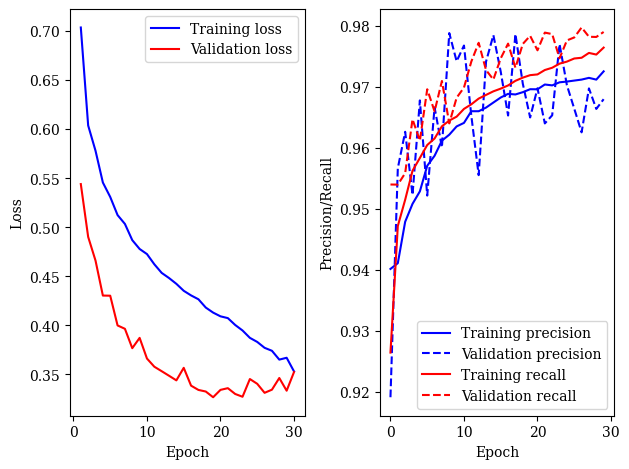

In [23]:
modal.plot_results(maxnorm_res_15)

In [25]:
import pickle

In [34]:
with open("results_15_05.txt", "wb") as myFile:
    pickle.dump(maxnorm_res_15, myFile)

In [35]:
with open("results_15_05.txt", "rb") as myFile:
    myNewPulledInDictionary = pickle.load(myFile)

In [28]:
maxnorm_model_15 = torch.load('norm_95_max(15.05).pth')

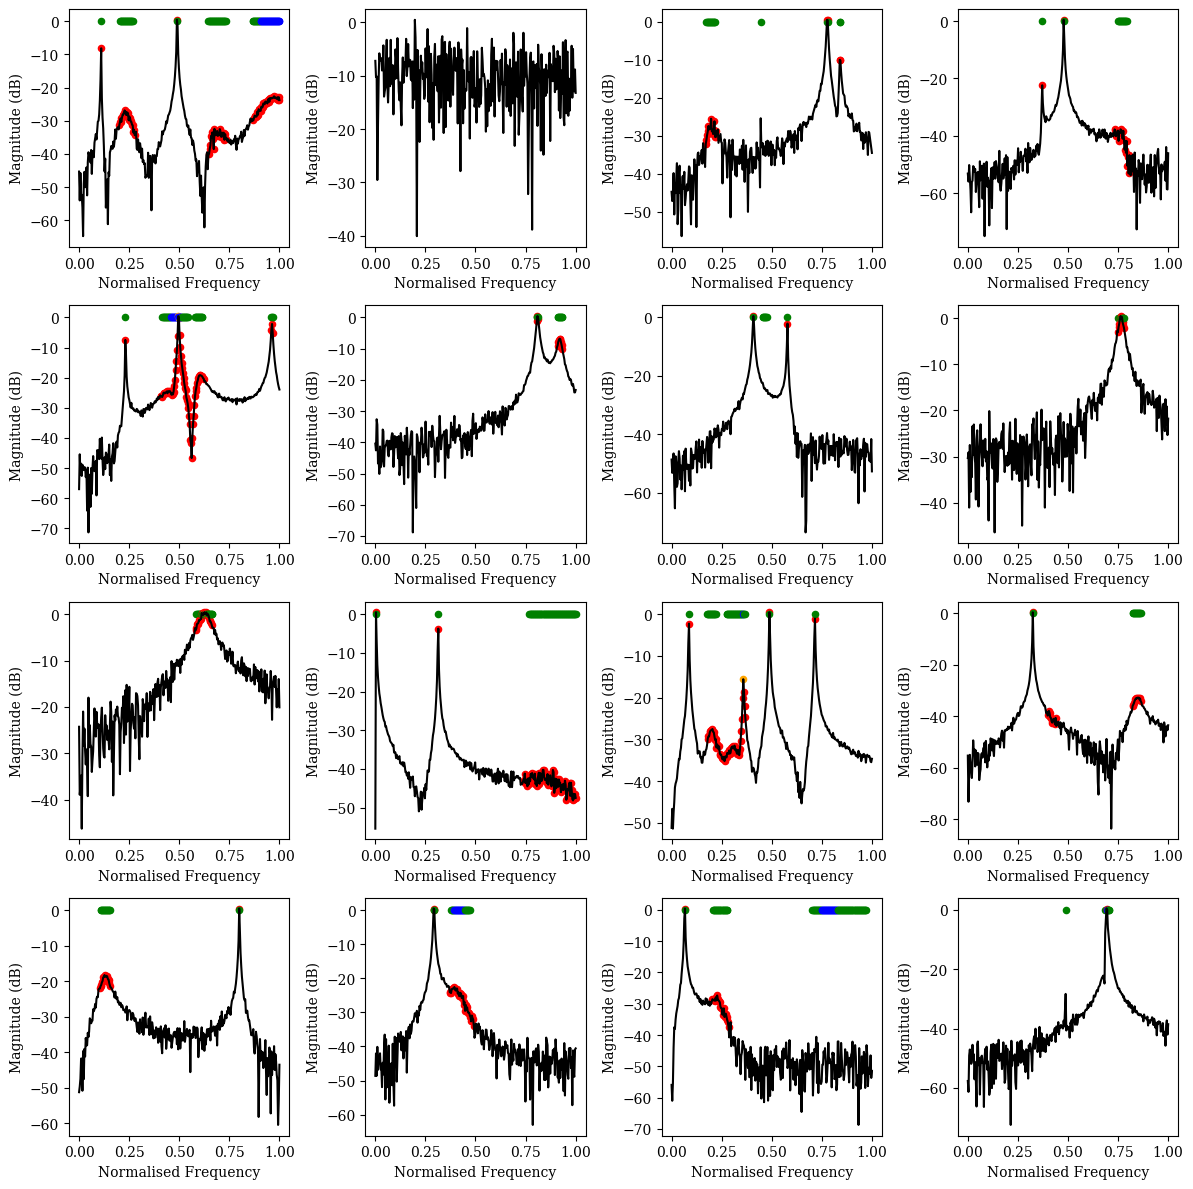

In [40]:
plot_predictions_extended(maxnorm_model_15, num_w_points=300, neg_an=True, multiclass=True, sigma_max=0.2, a_max=2.8)

### Training for fewer epochs, reduced dropout to 0.1

In [17]:
X, y, _, __ = generate_dat_extended(32*500, 300, multiclass=True, normalise=None, neg_an=True, sigma_max=0.20, a_max=2.8, max_modes=6)
Xval, yval, _, __ = generate_dat_extended(32*100, 300, multiclass=True, normalise=None, neg_an=True, sigma_max=0.2, a_max=2.8, max_modes=6)

In [18]:
maxnorm_model_16 = BiLSTM_larger(input_size=4, hidden_size=100, num_layers=3, num_classes=3)
maxnorm_res_16 = train_model_multiclass(maxnorm_model_16, X, y, Xval, yval, name='norm_95_max(16.05)', num_epochs=20, batch_size=32, device='cpu')

  5%|▌         | 1/20 [06:28<2:03:10, 388.97s/it]

Epoch [1/20], Loss: 0.595575974881649, Precision: 0.9526004779988919, Recall: 0.9335163053904529
Val Loss: 0.49542370408773423, Validation Precision: 0.937135198715711, Validation Recall: 0.9536173459516345


 10%|█         | 2/20 [12:35<1:52:39, 375.55s/it]

Epoch [2/20], Loss: 0.4781064519882202, Precision: 0.9508097502392925, Recall: 0.956845700044648
Val Loss: 0.4264551618695259, Validation Precision: 0.9527906218442217, Validation Recall: 0.9613071661789735


 15%|█▌        | 3/20 [19:05<1:48:18, 382.28s/it]

Epoch [3/20], Loss: 0.451844321757555, Precision: 0.9529595782711424, Recall: 0.9614072011956069
Val Loss: 0.40707410529255866, Validation Precision: 0.951403856678096, Validation Recall: 0.9653826734725431


 20%|██        | 4/20 [25:00<1:39:05, 371.61s/it]

Epoch [4/20], Loss: 0.424301818549633, Precision: 0.9563760641928248, Recall: 0.9653503685453068
Val Loss: 0.3805692607164383, Validation Precision: 0.9595838388268997, Validation Recall: 0.9668805157567419


 25%|██▌       | 5/20 [31:42<1:35:38, 382.56s/it]

Epoch [5/20], Loss: 0.40480651557445524, Precision: 0.9586865924511436, Recall: 0.9681266050617305
Val Loss: 0.36710307851433754, Validation Precision: 0.9739949094522444, Validation Recall: 0.965819057789426


 30%|███       | 6/20 [38:23<1:30:41, 388.65s/it]

Epoch [6/20], Loss: 0.3869900840818882, Precision: 0.9617746666101717, Recall: 0.9700733675210453
Val Loss: 0.3501575294137001, Validation Precision: 0.9673698512244502, Validation Recall: 0.970183102502536


 35%|███▌      | 7/20 [44:58<1:24:41, 390.88s/it]

Epoch [7/20], Loss: 0.37211643582582477, Precision: 0.9648293513093649, Recall: 0.9716396423639592
Val Loss: 0.3371599467098713, Validation Precision: 0.9666767612591797, Validation Recall: 0.9720913155850915


 40%|████      | 8/20 [51:50<1:19:32, 397.71s/it]

Epoch [8/20], Loss: 0.35969307920336724, Precision: 0.9669228775288962, Recall: 0.9726757489413342
Val Loss: 0.3263561324775219, Validation Precision: 0.9712142232771592, Validation Recall: 0.9730935791135984


 45%|████▌     | 9/20 [58:24<1:12:40, 396.38s/it]

Epoch [9/20], Loss: 0.3474696504175663, Precision: 0.9690097201691942, Recall: 0.9740189209450096
Val Loss: 0.3156247837841511, Validation Precision: 0.9748441739269248, Validation Recall: 0.9739600849878294


 50%|█████     | 10/20 [1:05:18<1:06:59, 401.95s/it]

Epoch [10/20], Loss: 0.3364389373064041, Precision: 0.9706002286946457, Recall: 0.9753747010643752
Val Loss: 0.30854554325342176, Validation Precision: 0.9691595877795066, Validation Recall: 0.9761849614630077


 55%|█████▌    | 11/20 [1:12:29<1:01:36, 410.70s/it]

Epoch [11/20], Loss: 0.32902220672369004, Precision: 0.97140949695672, Recall: 0.9760669394127538
Val Loss: 0.3064532969892025, Validation Precision: 0.9770587146088956, Validation Recall: 0.9741254414609446


 60%|██████    | 12/20 [1:19:41<55:37, 417.18s/it]  

Epoch [12/20], Loss: 0.3262808097600937, Precision: 0.9716255837427556, Recall: 0.9763127093702122
Val Loss: 0.3152985917031765, Validation Precision: 0.9679187531259451, Validation Recall: 0.976237435996183


 65%|██████▌   | 13/20 [1:26:37<48:37, 416.84s/it]

Epoch [13/20], Loss: 0.31741110426187513, Precision: 0.9719545474629112, Recall: 0.9773166895247872
Val Loss: 0.2936244400590658, Validation Precision: 0.973562526823897, Validation Recall: 0.9772687346646107


 70%|███████   | 14/20 [1:33:24<41:24, 414.02s/it]

Epoch [14/20], Loss: 0.3117191474437714, Precision: 0.9728726359076512, Recall: 0.9779897246474798
Val Loss: 0.30437662921845915, Validation Precision: 0.985203507357728, Validation Recall: 0.9725666371101929


 75%|███████▌  | 15/20 [1:40:07<34:13, 410.63s/it]

Epoch [15/20], Loss: 0.30559907364845273, Precision: 0.973428783940787, Recall: 0.9787311716399195
Val Loss: 0.29965307384729384, Validation Precision: 0.9829735076356704, Validation Recall: 0.9738505193996363


 80%|████████  | 16/20 [1:46:52<27:15, 408.87s/it]

Epoch [16/20], Loss: 0.30009117141366004, Precision: 0.9739496970729854, Recall: 0.9792516797136951
Val Loss: 0.2880689582973719, Validation Precision: 0.9717725522846901, Validation Recall: 0.9789925807248643


 85%|████████▌ | 17/20 [1:53:23<20:10, 403.51s/it]

Epoch [17/20], Loss: 0.2936917204260826, Precision: 0.9737791675140193, Recall: 0.9796512427115425
Val Loss: 0.28373451516032216, Validation Precision: 0.9729128763342811, Validation Recall: 0.9789013983442519


 90%|█████████ | 18/20 [2:00:16<13:33, 406.51s/it]

Epoch [18/20], Loss: 0.28693462547659876, Precision: 0.9745954523931519, Recall: 0.9805454919905039
Val Loss: 0.2888824814558029, Validation Precision: 0.9778498529276693, Validation Recall: 0.9779428308062377


 95%|█████████▌| 19/20 [2:06:54<06:43, 403.68s/it]

Epoch [19/20], Loss: 0.2817114776521921, Precision: 0.9752263794105596, Recall: 0.9808992611956813
Val Loss: 0.2871941592544317, Validation Precision: 0.9722203220545507, Validation Recall: 0.9788113392245585


100%|██████████| 20/20 [2:13:43<00:00, 401.19s/it]

Epoch [20/20], Loss: 0.28088280469179155, Precision: 0.9748975648339443, Recall: 0.9811185184452202
Val Loss: 0.28277622297406196, Validation Precision: 0.9673235042256411, Validation Recall: 0.9815462747247197


In [26]:
with open("results_16_05.txt", "wb") as myFile:
    pickle.dump(maxnorm_res_16, myFile)

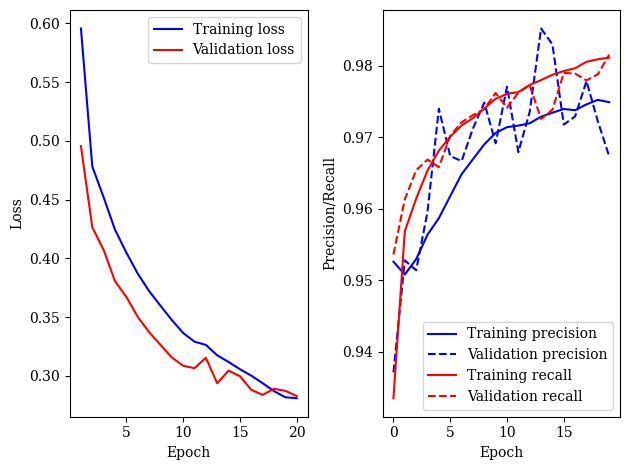

In [19]:
modal.plot_results(maxnorm_res_16)

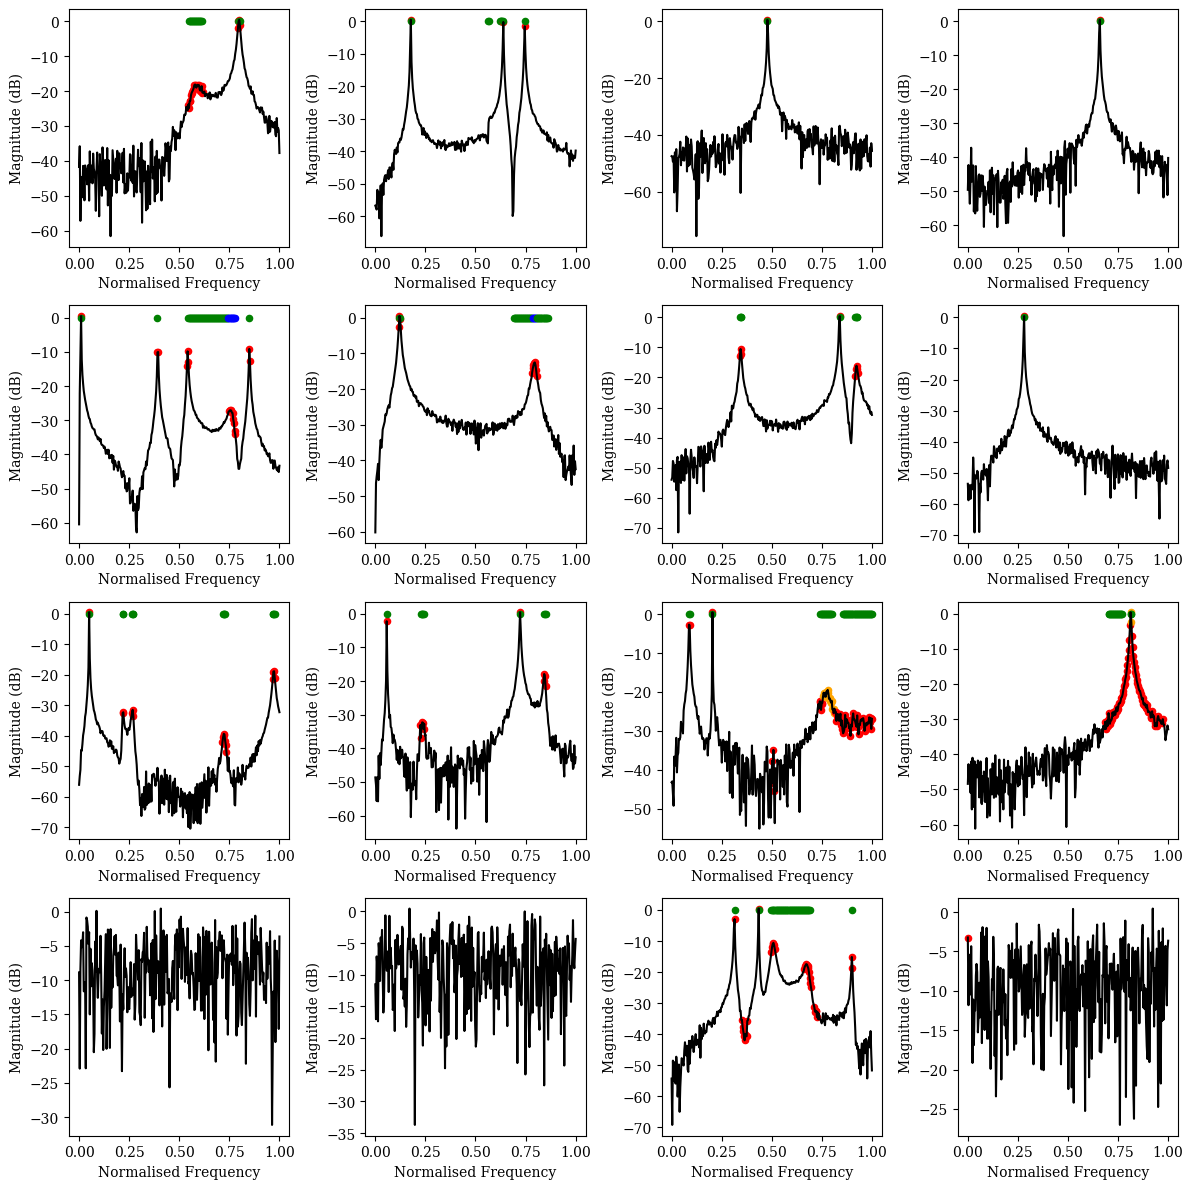

In [22]:
plot_predictions_extended(maxnorm_model_16, num_w_points=300, neg_an=True, multiclass=True, sigma_max=0.2, a_max=2.8)

## Testing a transformer

In [14]:
class PositionalEncoding(nn.Module):
    """Implement the positional encoding function.

    Code used from PyTorch documentation:
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        Args:
            x: embeddings (batch_size, seq_len, d_model)

        Returns:
            x: embeddings + positional encodings (batch_size, seq_len, d_model)
        """
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        x = self.dropout(x)
        return x

class TransformerModel(nn.Module):
    def __init__(
        self, d_model=256, n_head=8, n_layers=6, dropout=0.1, dim_feedforward=512, num_classes=3
    ):
        super(TransformerModel, self).__init__()
        assert d_model % n_head == 0, "d_model must be divisible by n_head"

        self.relu = nn.ReLU()

        self.embedding1 = nn.Linear(4, int(d_model / 2))
        self.embedding2 = nn.Linear(int(d_model / 2), int(d_model / 2))
        self.embedding3 = nn.Linear(int(d_model / 2), d_model)

        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model,
            nhead=n_head,
            batch_first=True,
            dropout=dropout,
            dim_feedforward=dim_feedforward,
        )
        self.encoder = nn.TransformerEncoder(
            self.encoder_layer, num_layers=n_layers
        )  # Multi-layer transformer encoder

        self.decoder1 = nn.Linear(d_model, int(d_model / 2))
        self.decoder2 = nn.Linear(int(d_model / 2), int(d_model / 2))
        self.decoder3 = nn.Linear(int(d_model / 2), num_classes)

    def forward(self, x):
        """
        Args:
            x: input data (batch_size, seq_len, 1)
        """
        x = self.embedding1(x)
        x = self.relu(x)
        x = self.embedding2(x)
        x = self.relu(x)
        x = self.embedding3(x)

        src = self.pos_encoder(x)  # (batch_size, seq_len, d_model)
        output = self.encoder(src)  # (batch_size, seq_len, d_model)

        output = self.decoder1(output)  # (batch_size, seq_len, d_model/2)
        output = self.relu(output)
        output = self.decoder2(output)  # (batch_size, seq_len, d_model/2)
        output = self.relu(output)
        output = self.decoder3(output)  # (batch_size, seq_len, 1)
        return output

In [34]:
def calculate_precision_and_recall(outputs, targets):
    """Calculate precision and recall for a multiclass problem."""

    ### THIS IS NOT CORRECT ### !!!
    # Convert the outputs to class predictions (index of max value along the last dimension)
    _, predicted = torch.max(outputs, dim=-1)

    # Flatten the predictions and targets to 1D tensors
    predicted_flat = predicted.view(-1)
    targets_flat = targets.view(-1)

    true_positives = (predicted_flat == targets_flat).sum().item()
    false_positives = ((predicted_flat == 1) & (targets_flat == 0)).sum().item()
    false_negatives = ((predicted_flat == 0) & (targets_flat == 1)).sum().item()

    precision = (
        true_positives / (true_positives + false_positives)
        if (true_positives + false_positives) > 0
        else 0
    )
    recall = (
        true_positives / (true_positives + false_negatives)
        if (true_positives + false_negatives) > 0
        else 0
    )

    return precision, recall

In [41]:
def train_model_multiclass(model, X, y, valX, valy, name, num_epochs=150,batch_size=32,weights=None, device='cpu'):
    device = torch.device(device)
    model.to(device)
    X = torch.from_numpy(X).to(torch.float32)
    y = torch.from_numpy(y).to(torch.long)
    val_X = torch.from_numpy(valX).to(torch.float32)
    val_y = torch.from_numpy(valy).to(torch.long)

    # X = X.reshape(X.shape[0], X.shape[1], -1)
    y = y.reshape(y.shape[0], y.shape[1], -1)
    # val_X = val_X.reshape(val_X.shape[0], val_X.shape[1], -1)
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1], -1)

    # print(X.shape)
    # print(y.shape)

    dataset = TensorDataset(X, y)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)

    val_dataset = TensorDataset(val_X, val_y)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,pin_memory=True, num_workers=4)

    if weights is not None:
        criterion = nn.CrossEntropyLoss(weight = weights.detach().clone())
    else:
        # criterion = nn.CrossEntropyLoss(weight = torch.tensor([1.0, 3.0, 6.5])) 
        criterion = nn.CrossEntropyLoss(weight = torch.tensor([1.0, 3.0, 6.0])) 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    result_dict = {
        'training_loss': [],
        'validation_loss': [],
        'training_precision': [],
        'training_recall': [],
        'validation_precision': [],
        'validation_recall': [],
        'epochs': []
    }

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        total_loss = 0.0
        total_precision = 0.0
        total_recall = 0.0
        total_samples = 0

        total_val_loss = 0.0
        total_val_precision = 0.0
        total_val_recall = 0.0
        total_val_samples = 0

        best_val_loss = float('inf')  # Initialize best validation loss
        no_improvement_count = 0  # Initialize counter for no improvement
        early_stopping_patience = 4  # Number of epochs to wait before early stopping

        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # print(inputs.shape)
            # print(targets.shape)
            optimizer.zero_grad()
            outputs = model(inputs)

            targets = targets.view(-1)
            targets = targets.to(device)
            loss = criterion(outputs.view(-1, 3), targets)
            # loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            # print(outputs.shape)
            # print(targets.shape)

            batch_precision, batch_recall = calculate_precision_and_recall(outputs, targets)
            total_loss += loss.item() * len(inputs)
            total_precision += batch_precision * len(inputs)
            total_recall += batch_recall * len(inputs)
            total_samples += len(inputs)

        model.eval() # !!!
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                targets = targets.view(-1)
                loss = criterion(outputs.view(-1, 3), targets)
                # loss = criterion(outputs, targets)
                total_val_loss += loss.item() * len(inputs)
                batch_precision, batch_recall = calculate_precision_and_recall(outputs, targets)
                total_val_precision += batch_precision * len(inputs)
                total_val_recall += batch_recall * len(inputs)
                total_val_samples += len(inputs) 

        average_loss = total_loss / total_samples
        average_precision = total_precision / total_samples
        average_recall = total_recall / total_samples
        # average_accuracy = total_accuracy / total_samples
        average_val_loss = total_val_loss / total_val_samples
        average_val_precision = total_val_precision / total_val_samples
        average_val_recall = total_val_recall / total_val_samples

        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}, Accuracy: {average_accuracy}')
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}, Precision: {average_precision}, Recall: {average_recall}')
        print(f'Val Loss: {average_val_loss}, Validation Precision: {average_val_precision}, Validation Recall: {average_val_recall}')

        result_dict['training_loss'].append(average_loss)
        result_dict['validation_loss'].append(average_val_loss)
        result_dict['training_precision'].append(average_precision)
        result_dict['training_recall'].append(average_recall)
        result_dict['validation_precision'].append(average_val_precision)
        result_dict['validation_recall'].append(average_val_recall)
        result_dict['epochs'].append(epoch+1)

        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1
            if no_improvement_count >= early_stopping_patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                torch.save(model, f'{name}.pth')
                return result_dict

    torch.save(model, f'{name}.pth')
    return result_dict

In [42]:
X, y, _, __ = generate_dat_extended(32*500, 300, multiclass=True, normalise=None, neg_an=True, sigma_max=0.20, a_max=2.8, max_modes=6)
Xval, yval, _, __ = generate_dat_extended(32*100, 300, multiclass=True, normalise=None, neg_an=True, sigma_max=0.2, a_max=2.8, max_modes=6)

In [43]:
transformer1 = TransformerModel(d_model=128, n_head=8, n_layers=3, num_classes=3)

In [44]:
# print number of model parameters
total_params = sum(p.numel() for p in transformer1.parameters())
print(total_params)

818499


In [46]:
tr1_res = train_model_multiclass(transformer1, X, y, Xval, yval, name='transformer1(16.05)', num_epochs=20, batch_size=32, device='cpu')

  0%|          | 0/20 [00:02<?, ?it/s]


KeyboardInterrupt: 

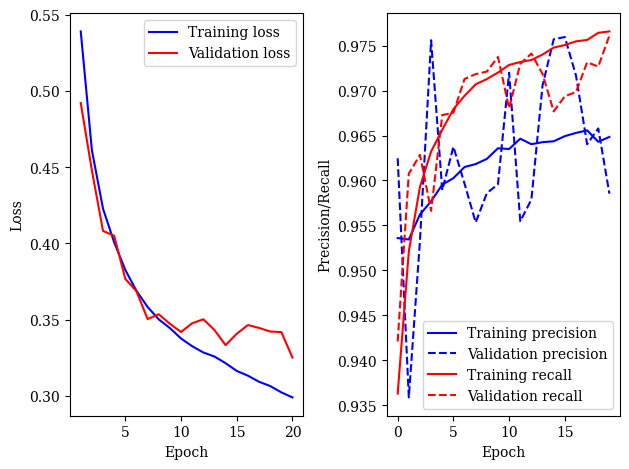

In [47]:
modal.plot_results(tr1_res)

torch.Size([32, 250, 4])
torch.Size([32, 250, 3])


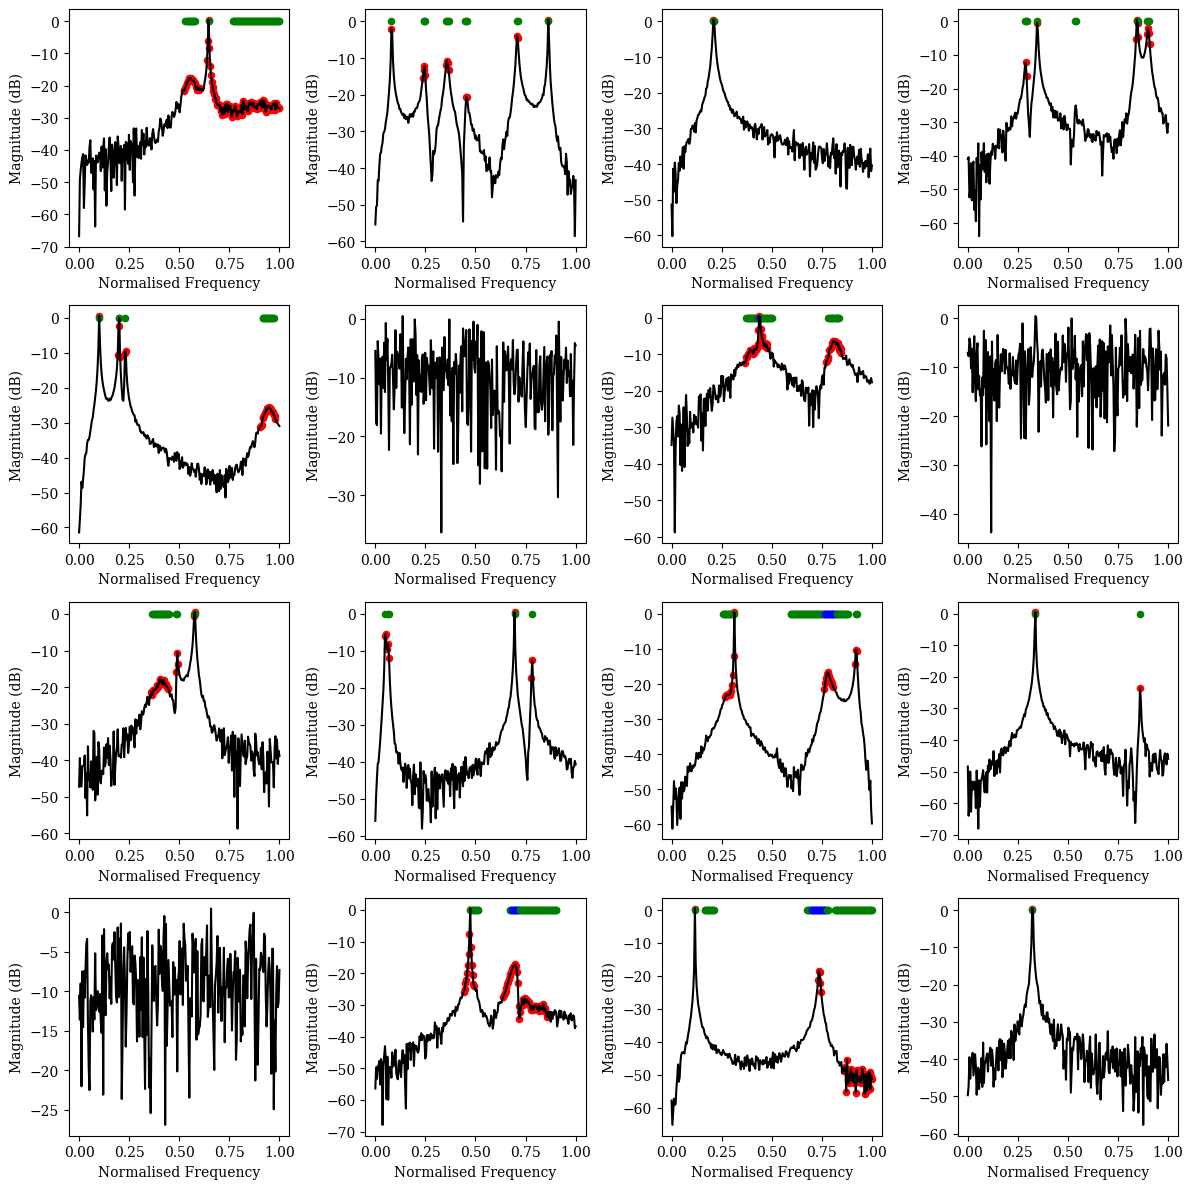

In [52]:
plot_predictions_extended(transformer1, num_w_points=250, neg_an=True, multiclass=True, sigma_max=0.2, a_max=2.8)